In [ ]:
%pylab inline

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import glob
import sys

from math import *

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import copy
from PIL import Image

from IPython import display
import time

import pickle

import scipy.cluster.hierarchy as sch
import seaborn as sns

import os
from torch.utils.data import Dataset

def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

def toivar(x):
    return Variable(torch.LongTensor(x).cuda(), requires_grad = False)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from scipy.stats import fisher_exact
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
class Embed(nn.Module):
    def __init__(self):
        super(Embed,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,9,padding=4)
        torch.nn.init.orthogonal(self.conv1.weight)

        self.p1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32,96,3,padding=1)
        torch.nn.init.orthogonal(self.conv2.weight)
        self.conv2b = nn.Conv2d(96,48,1)
        torch.nn.init.orthogonal(self.conv2b.weight)
        self.p2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(48,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv3.weight)
        self.conv3b = nn.Conv2d(128,64,1)
        torch.nn.init.orthogonal(self.conv3b.weight)        
        self.p3 = nn.MaxPool2d(2)
        
        self.conv4 = nn.Conv2d(64,96,3,padding=1)
        torch.nn.init.orthogonal(self.conv4.weight)        
        self.p4 = nn.MaxPool2d(2)
        
        self.conv5 = nn.Conv2d(96,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv5.weight)        
        self.conv6 = nn.Conv2d(128,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv6.weight)        
        self.p5 = nn.MaxPool2d(2)
        
        self.dense1 = nn.Linear(10*128,256)
        self.dense2 = nn.Linear(256,256)
        self.dense3 = nn.Linear(256,64)
        
    def inter(self, x):
        z = self.p1(F.elu(self.conv1(x)))
        #z = self.p2(F.elu(self.conv2b(F.elu(self.conv2(z)))))
        #z = self.p3(F.elu(self.conv3b(F.elu(self.conv3(z)))))
        #z = self.p4(F.elu(self.conv4(z)))
        
        #z = F.elu(self.conv5(z))
        #z = z + F.elu(self.conv6(z))
        
        return z

    def forward(self, x):
        z = self.p1(F.elu(self.conv1(x)))
        z = self.p2(F.elu(self.conv2b(F.elu(self.conv2(z)))))
        z = self.p3(F.elu(self.conv3b(F.elu(self.conv3(z)))))
        z = self.p4(F.elu(self.conv4(z)))
        
        z = F.elu(self.conv5(z))
        z = z + F.elu(self.conv6(z))
        z = self.p5(z)
        
        s = z.size()
        z = z.permute(0,1,2,3).contiguous().view(s[0],s[1]*s[2]*s[3])
        
        z = F.elu(self.dense1(z))
        z = F.elu(self.dense2(z))
        z = self.dense3(z)
        
        z = z / torch.sqrt(torch.sum(z**2,1,keepdim=True)+1e-16)
        
        return z
        
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.embed = Embed()
        self.dense1 = nn.Linear(64,96)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(96,96)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(96,96)
        self.drop3 = nn.Dropout(0.5)
        self.dense4 = nn.Linear(96,NUM_LABELS)
        
        self.adam = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def get_embedding(self,x):
        return self.embed(x)
    
    def predict(self, z):
        z = self.drop1(F.elu(self.dense1(z)))
        z = self.drop2(F.elu(self.dense2(z)))
        z = self.drop3(F.elu(self.dense3(z)))
        p = F.softmax(self.dense4(z),dim=1)
        
        return p
        
    def forward(self,x1,x2,x3):
        z1 = self.get_embedding(x1)
        z2 = self.get_embedding(x2)
        z3 = self.get_embedding(x3)
        
        p = self.predict(z1)
        
        return p,z1,z2,z3    

    def triplet(self,z1,z2,z3):
        return torch.mean((z1-z2)**2) - torch.mean((z1-z3)**2)
    
    def loss(self,p,z1,z2,z3,y):
        tloss = self.triplet(z1,z2,z3)
        
        p = torch.clamp(p,1e-6,1-1e-6)
        idx = torch.LongTensor(np.arange(p.size()[0])).cuda()        
        loss = torch.mean(-torch.log(p[idx,y[idx]]))
        
        reg = 0
        for param in self.parameters():
            reg = reg + torch.mean(param**2)
            
        loss = loss + 6e-5*reg + 0.1 * tloss
        
        return loss

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis Materials/data_ordered.csv').iloc[1500:].reset_index(drop=True)
comimics_table = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis Materials/comimics.csv')
comimics_table = comimics_table.drop(index=11).reset_index(drop=True)
comimics_subspecies = list(set(comimics_table['Melpomene'].tolist())) + list(set(comimics_table['Erato'].tolist()))

In [ ]:
comimics_table

Melpomene       Erato
0        cythera      cyrbia
1        aglaope   lativitta
2        amandus     phyllis
3      amaryllis   favorinus
4      burchelli     phyllis
5   ecuadorensis      etylus
6    thelxiopeia       erato
7      melpomene      hydara
8       xenoclea   microclea
9          nanna     phyllis
10      plesseni   notabilis
11        rosina  petiverana
12        rosina   demophoon
13      vulcanus       venus

### Loading Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
NUM_LABELS = 12
erato_net = Net().cuda()
erato_net.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Thesis Materials/Models with hybrids/erato_hybrids.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
NUM_LABELS = 12
melpomene_net = Net().cuda()
melpomene_net.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Thesis Materials/Models with hybrids/melpomene_hybrids.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
NUM_LABELS = 12
mimicry_labels_net = Net().cuda()
mimicry_labels_net.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Thesis Materials/Models with hybrids/all_hybrids.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
NUM_LABELS = 25
comimics_net = Net().cuda()
comimics_net.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Thesis Materials/Models with hybrids/comimics.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
NUM_LABELS = 25
all_comimics_net = Net().cuda()
all_comimics_net.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Thesis Materials/Models with hybrids/only_comimics.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
NUM_LABELS = 25
nonmimics_net = Net().cuda()
nonmimics_net.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Thesis Materials/Models with hybrids/nonmimic.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
NUM_LABELS = 37
triplet_net = Net().cuda()
triplet_net.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Thesis Materials/Models with hybrids/same.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
NUM_LABELS = 37
hard_negatives_net = Net().cuda()
hard_negatives_net.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Thesis Materials/Models with hybrids/hard_negatives.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
NUM_LABELS = 37
regular_net = Net().cuda()
regular_net.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Thesis Materials/Models with hybrids/retrained_original.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        # self.img_labels = pd.read_csv(annotations_file)
        self.img_labels = annotations_file
        self.img_dir = '/content/drive/MyDrive/Butterflies_Shared/LowResolution'
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        im = np.array(Image.open(img_path)).transpose(2,0,1)
        iarr = np.ones((3,64,160))*240
        x0 = int((160-im.shape[2])/2)
        iarr[:,:,x0:x0+im.shape[2]] = im
        img = (iarr-127.5)/128.0
        image = torch.from_numpy(img)
        image = image.to(dtype=torch.float32)
        image = torch.clamp(image, 0, 1)
        label = self.img_labels.iloc[idx, 13]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
negative_data = data.copy()
LE = LabelEncoder()
negative_labels = LE.fit_transform(data['Subspecies'])
negative_data['Label'] = negative_labels
test_dataset = CustomImageDataset(negative_data)
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, **kwargs)

In [ ]:
def load_data(dataset, img_idx, label_idx) : 
  data = []
  tlabels = []
  subspecies = []

  for i in range(dataset.shape[0]):
      im = np.array(Image.open("/content/drive/My Drive/Butterflies_Shared/LowResolution/"+dataset.iloc[i,img_idx])).transpose(2,0,1)
      subspecies.append(dataset['Subspecies'][i])
      iarr = np.ones((3,64,160))*240
      x0 = int((160-im.shape[2])/2)
      iarr[:,:,x0:x0+im.shape[2]] = im
      
      data.append((iarr-127.5)/128.0)
      tlabels.append(dataset.iloc[i,label_idx])

  LE = LabelEncoder()
  labels = LE.fit_transform(tlabels)
  data = np.array(data)

  return data, labels, subspecies

In [ ]:
data_orig, labels_orig, subspecies_orig = load_data(data, 1, 4)

In [ ]:
melpomene = ['cythera',
 'aglaope',
 'nanna',
 'amaryllis',
 'ecuadorensis',
 'thelxiopeia',
 'melpomene',
 'xenoclea',
 'plesseni',
 'N. rosina',
 'S. rosina',
 'vulcanus']
erato = ['cyrbia',
 'lativitta',
 'phyllis',
 'favorinus',
 'etylus',
 'erato',
 'hydara',
 'microclea',
 'notabilis',
 'petiverana',
 'demophoon',
 'venus']
comimics_labels = {erato[i] : i for i in range(len(erato))}
comimics_labels_melpomene = {melpomene[i] : i for i in range(len(melpomene))}
comimics_labels.update(comimics_labels_melpomene)
comimics_labels['burchelli'] = comimics_labels['phyllis']
comimics_rosina = erato + melpomene + ['rosina', 'burchelli']

subspecies_updated = []
all_numbered = data[data['Subspecies'].isin(comimics_rosina)].reset_index(drop=True)
for i in range(len(all_numbered)) : 
  if all_numbered['Subspecies'][i] != 'rosina' : 
    subspecies_updated.append(all_numbered['Subspecies'][i])
  else : 
    if all_numbered['Locality latitude'][i] > 9.92 : 
      subspecies_updated.append('N. rosina')
    elif all_numbered['Locality latitude'][i] < 9.92 : 
      subspecies_updated.append('S. rosina')
    else : 
      all_numbered = all_numbered.drop(index=i)

all_numbered = all_numbered.reset_index(drop=True)

all_numbered['Subspecies'] = subspecies_updated
all_numbered['Label'] = [comimics_labels[all_numbered['Subspecies'][i]] for i in range(len(all_numbered))]

In [ ]:
only_comimics = data[data['Subspecies'].isin(comimics_subspecies)].reset_index(drop=True)

In [ ]:
len({all_numbered['Subspecies'][i] : all_numbered['Label'][i] for i in range(len(all_numbered)) } )

25

In [ ]:
data_only_comimics, labels_only_comimics, subspecies_only_comimics = load_data(only_comimics, 1, 4)

In [ ]:
data_mimic, labels_mimic, subspecies_mimic = load_data(all_numbered, 1, 13)

In [ ]:
all_numbered_erato = all_numbered[all_numbered['Species'] == 'erato'].reset_index(drop=True)
data_erato, labels_erato, subspecies_erato = load_data(all_numbered_erato, 1, 13)
all_numbered_melpomene = all_numbered[all_numbered['Species'] == 'melpomene'].reset_index(drop=True)
data_melpomene, labels_melpomene, subspecies_melpomene = load_data(all_numbered_melpomene, 1, 13)

In [ ]:
def get_accuracy_breakdown(data, labels, subspecies, net, dataset) : 
  breakdowns = {ss : [0,0] for ss in subspecies}
  net.eval()
  for i in range(len(data)) : 
    batch = tovar(data[i:i+1])
    l = labels[i:i+1]
    z = net.get_embedding(batch)                
    p = net.predict(z).cpu().data.numpy()     
    breakdowns[subspecies[i]][0] += 1
    if np.argmax(p) == l : 
      breakdowns[subspecies[i]][1] += 1
  return {ss : breakdowns[ss][1] / breakdowns[ss][0] for ss in breakdowns}

In [ ]:
def get_accuracy_breakdown_negatives(dataloader, net, dataset) : 
  breakdowns = {ss : [0,0] for ss in dataset['Subspecies'].tolist()}
  net.eval()
  batch_size = 100
  for index, (test_features, test_labels) in enumerate(dataloader) : 
    l = test_labels.data.numpy()
    z = net.get_embedding(test_features.cuda())
    
    p = net.predict(z).cpu().data.numpy() 
    z = z.cpu().data.numpy()

    curr_data = dataset.iloc[index*batch_size:(index*batch_size)+batch_size].reset_index(drop=True)

    for i in range(len(test_labels)) : 
      ss = curr_data['Subspecies'][i]
      breakdowns[ss][0] += 1
      if np.argmax(p[i]) == l[i] : 
        breakdowns[ss][1] += 1
  return {ss : breakdowns[ss][1] / breakdowns[ss][0] for ss in breakdowns}

In [ ]:
def get_accuracy_negatives(dataloader, net, dataset) : 
  count =0
  correct = 0
  batch_size = 100
  no_hybrid = 0
  no_hybrid_correct = 0
  net.eval()
  for index, (test_features, test_labels) in enumerate(dataloader) : 
    l = test_labels.data.numpy()
    z = net.get_embedding(test_features.cuda())
    p = net.predict(z).cpu().data.numpy() 
    z = z.cpu().data.numpy()
    correct += np.sum(np.argmax(p,axis=1)==l)
    count += len(test_labels)

    curr_data = data.iloc[index*batch_size:(index*batch_size)+batch_size].reset_index(drop=True)

    for i in range(len(test_labels)) : 
      if curr_data['Hybrid status of additional taxonomic information'][i] != 'hybrid' :
        no_hybrid += 1 
        if np.argmax(p[i]) == l[i] : 
          no_hybrid_correct += 1
  return correct/count, no_hybrid_correct/no_hybrid

In [ ]:
def get_accuracy(data, labels, subspecies, net, dataset) : 
  count =0
  correct = 0
  no_hybrid = 0
  no_hybrid_correct = 0
  incorrect_subspecies = []
  net.eval()
  for i in range(len(data)) : 
    batch = tovar(data[i:i+1])
    l = labels[i:i+1]
    z = net.get_embedding(batch)                
    p = net.predict(z).cpu().data.numpy()
    if np.argmax(p) == l : 
      correct += 1
    else : 
      incorrect_subspecies.append(subspecies[i])
    if dataset['Hybrid status of additional taxonomic information'][i] != 'hybrid' : 
      no_hybrid += 1
      if np.argmax(p) == l : 
        no_hybrid_correct += 1
    count += 1
  return correct/count, no_hybrid_correct/no_hybrid

### Accuracy Breakdown

In [ ]:
def get_embeddings(net, data) : 
  test_embs = []
  for i in range(0, data.shape[0], 100) : 
    batch = tovar(data[i:i+100])
    z = net.get_embedding(batch)  
    z = z.cpu().data.numpy()
    for zm in z:
      test_embs.append(zm.copy())
  return np.array(test_embs)

In [ ]:
erato_embs = get_embeddings(erato_net, data_erato)
melpomene_embs = get_embeddings(melpomene_net, data_melpomene)
kmeans_erato = KMeans(n_clusters=11, random_state=0).fit(erato_embs)
kmeans_melpomene = KMeans(n_clusters=11, random_state=0).fit(melpomene_embs)
erato_dict = {kmeans_erato.labels_[i] : labels_erato[i] for i in range(len(labels_erato))}
melpomene_dict = {kmeans_melpomene.labels_[i] : labels_melpomene[i] for i in range(len(labels_melpomene))}

In [ ]:
def clustering_accuracies(net, kmeans, labels) :
  subspecies = list(set(all_numbered['Subspecies'].tolist()))
  subspecies.sort()
  counts = {ss : 0 for ss in subspecies}
  correct = {ss : 0 for ss in subspecies}
  for i in range(len(all_numbered)) : 
    name = np.array(all_numbered['Subspecies'])[i]
    l = labels_mimic[i]
    batch = tovar(data_mimic[i:i+1])
    z = net.get_embedding(batch)  
    z = z.cpu().data.numpy()
    p = kmeans.predict(z)[0]
    counts[name] += 1
    if labels[p] == l :
      correct[name] += 1
  accs = {ss : (correct[ss] / counts[ss]) for ss in correct}
  return accs

In [ ]:
erato_net_accs = clustering_accuracies(erato_net, kmeans_erato, erato_dict)
melpomene_net_accs = clustering_accuracies(melpomene_net, kmeans_melpomene, melpomene_dict)

In [ ]:
subspecies_ordered = ['M. cythera', 'M. aglaope', 'M. amaryllis', 'M. burchelli', 'M. nanna',
       'M. ecuadorensis', 'M. thelxiopeia', 'M. melpomene', 'M. xenoclea',
       'M. plesseni', 'M. rosina', 'M. N. rosina', 'M. S. rosina', 'M. vulcanus', 'E. cyrbia', 'E. lativitta',
       'E. favorinus', 'E. phyllis', 'E. etylus', 'E. erato', 'E. hydara',
       'E. microclea', 'E. notabilis', 'E. petiverana', 'E. demophoon',
       'E. venus']

In [ ]:
for i in range(len(subspecies_ordered)) : 
  ss = subspecies_ordered[i]
  count = subspecies_orig.count(ss[3:])
  if ss[3:] == 'N. rosina' : 
    count = subspecies_mimic.count(ss[3:])
  if ss[3:] == 'S. rosina' : 
    count = subspecies_mimic.count(ss[3:])
  subspecies_ordered[i] = ss + ' (' + str(count) + ')'

In [ ]:
regular_breakdown = get_accuracy_breakdown(data_orig, labels_orig, subspecies_orig, regular_net, data)
triplet_breakdown = get_accuracy_breakdown(data_orig, labels_orig, subspecies_orig, triplet_net, data)
comimics_breakdown = get_accuracy_breakdown(data_only_comimics, labels_only_comimics, subspecies_only_comimics, comimics_net, only_comimics)
nonmimics_breakdown = get_accuracy_breakdown(data_only_comimics, labels_only_comimics, subspecies_only_comimics, nonmimics_net, only_comimics)
all_comimics_breakdown = get_accuracy_breakdown(data_only_comimics, labels_only_comimics, subspecies_only_comimics, all_comimics_net, only_comimics)
erato_breakdown = get_accuracy_breakdown(data_mimic, labels_mimic, subspecies_mimic, erato_net, all_numbered)
melpomene_breakdown = get_accuracy_breakdown(data_mimic, labels_mimic, subspecies_mimic, melpomene_net, all_numbered)
mimicry_labels_breakdown = get_accuracy_breakdown(data_mimic, labels_mimic, subspecies_mimic, mimicry_labels_net, all_numbered)
hard_negatives_breakdown = get_accuracy_breakdown_negatives(test_loader, hard_negatives_net, negative_data)

In [ ]:
heatmap_data = []
all_breakdowns = [regular_breakdown, triplet_breakdown, hard_negatives_breakdown, all_comimics_breakdown, comimics_breakdown, nonmimics_breakdown, mimicry_labels_breakdown, erato_breakdown, melpomene_breakdown]
all_breakdowns.reverse()
for breakdown in all_breakdowns : 
  ss_breakdown = []
  for ss in subspecies_ordered : 
    if ss[3:] in breakdown : 
      ss_breakdown.append(breakdown[ss[3:]])
    else : ss_breakdown.append(0)
  heatmap_data.append(ss_breakdown)

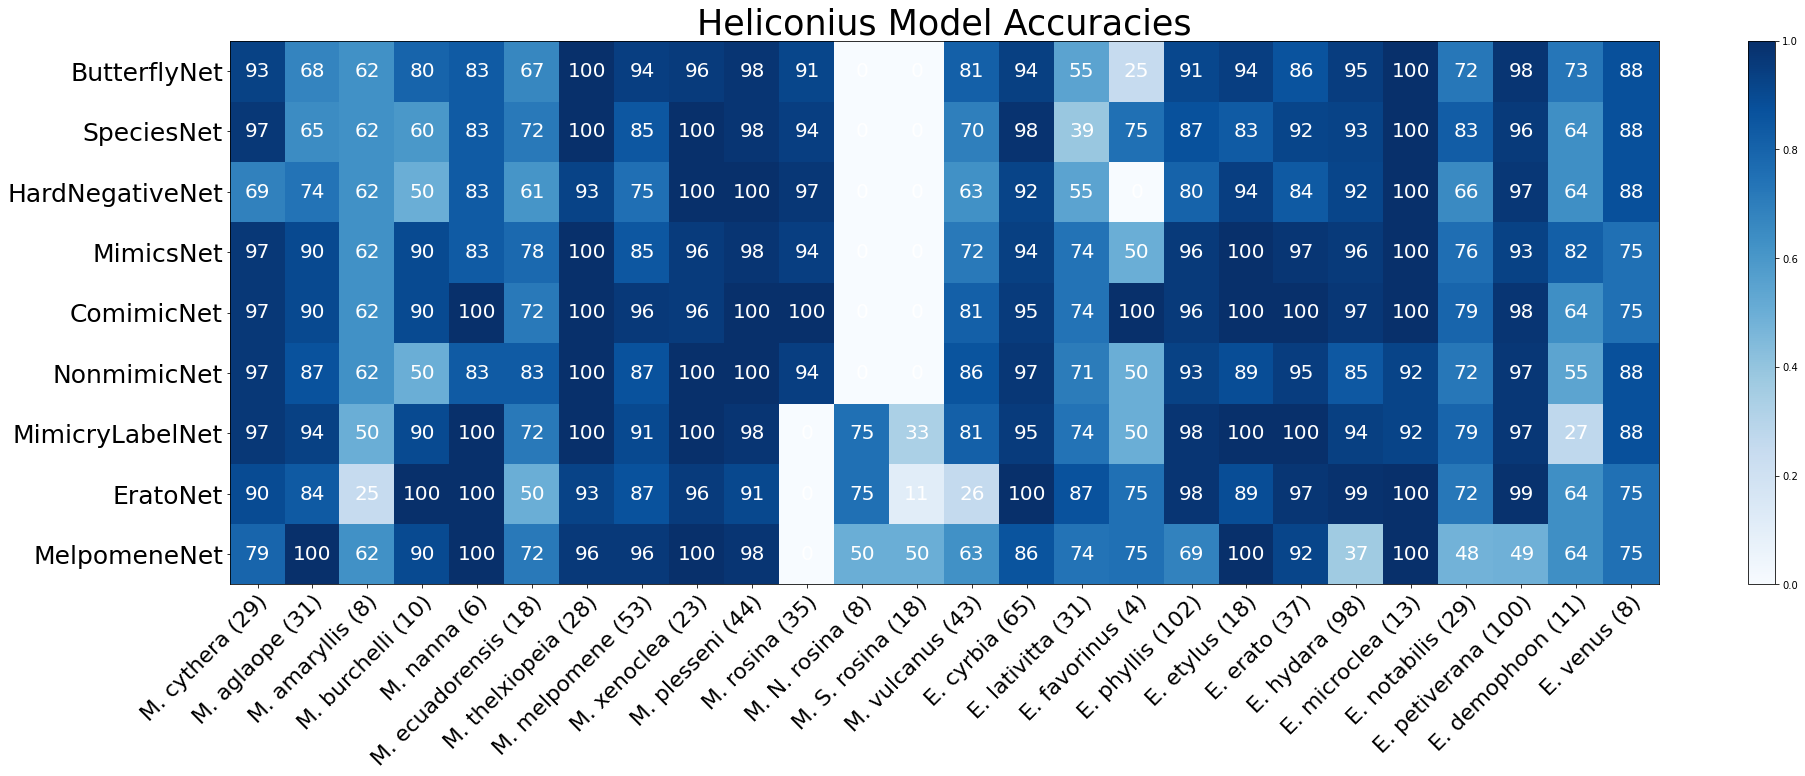

In [ ]:
fig, ax = plt.subplots(figsize=(32, 10))  
colorbar = ax.pcolormesh( heatmap_data , cmap = 'Blues' )
  
ax.set_title( 'Heliconius Model Accuracies', fontsize=35)
test = ['ButterflyNet', 'SpeciesNet','HardNegativeNet','MimicsNet', 'ComimicNet', 'NonmimicNet','MimicryLabelNet', 'EratoNet', 'MelpomeneNet']
test.reverse()
ax.set_xticks(np.arange(len(subspecies_ordered))+0.5)
ax.set_xticklabels(subspecies_ordered, fontsize=22)
ax.set_yticks(np.arange(len(test))+0.5)
ax.set_yticklabels(test, fontsize=25)
labels = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(test)):
    for j in range(len(subspecies_ordered)):
        # if test[i] == 'Network trained \nwith hard negatives' : 
        #   color = 'tab:blue' 
        # else : color='w'
        text = ax.text(j+0.5, i+0.5, round(heatmap_data[i][j]*100),
                       ha="center", va="center", color='w', size=20)
plt.colorbar(colorbar)
fig.subplots_adjust(wspace=0, hspace=0)

### Individual Accuracies

In [ ]:
get_accuracy(data_orig, labels_orig, subspecies_orig, regular_net, data)

(0.8478260869565217, 0.8649425287356322)

In [ ]:
get_accuracy(data_orig, labels_orig, subspecies_orig, triplet_net, data)

(0.8302277432712215, 0.8649425287356322)

In [ ]:
get_accuracy(data_only_comimics, labels_only_comimics, subspecies_only_comimics, comimics_net, only_comimics)

(0.931924882629108, 0.9571428571428572)

In [ ]:
get_accuracy(data_only_comimics, labels_only_comimics, subspecies_only_comimics, nonmimics_net, only_comimics)

(0.892018779342723, 0.9158730158730158)

In [ ]:
get_accuracy(data_only_comimics, labels_only_comimics, subspecies_only_comimics, all_comimics_net, only_comimics)

(0.9061032863849765, 0.9333333333333333)

In [ ]:
get_accuracy(data_mimic, labels_mimic, subspecies_mimic, erato_net, all_numbered)

(0.8646706586826347, 0.9178743961352657)

In [ ]:
get_accuracy(data_mimic, labels_mimic, subspecies_mimic, melpomene_net, all_numbered)

(0.718562874251497, 0.7600644122383253)

In [ ]:
get_accuracy(data_mimic, labels_mimic, subspecies_mimic, mimicry_labels_net, all_numbered)

(0.9029940119760479, 0.9146537842190016)

In [ ]:
get_accuracy(data_erato, labels_erato, subspecies_erato, erato_net, all_numbered_erato)

(0.9496124031007752, 0.9722222222222222)

In [ ]:
get_accuracy(data_melpomene, labels_melpomene, subspecies_melpomene, erato_net, all_numbered_melpomene)

(0.7272727272727273, 0.8222222222222222)

In [ ]:
get_accuracy(data_melpomene, labels_melpomene, subspecies_melpomene, melpomene_net, all_numbered_melpomene)

(0.8495297805642633, 0.8888888888888888)

In [ ]:
get_accuracy(data_erato, labels_erato, subspecies_erato, melpomene_net, all_numbered_erato)

(0.6375968992248062, 0.6868686868686869)

In [ ]:
get_accuracy_negatives(test_loader, hard_negatives_net, negative_data)

(0.7908902691511387, 0.8275862068965517)

### Check if correlation between correct prediction and hybrid status?

In [ ]:
def get_stats_negative(dataloader, net, dataset) : 
  hybrid_correct = 0
  hybrid_incorrect =0
  nonhybrid_correct = 0
  nonhybrid_incorrect = 0

  breakdowns = {ss : [0,0] for ss in dataset['Subspecies'].tolist()}
  net.eval()
  batch_size = 100
  for index, (test_features, test_labels) in enumerate(dataloader) : 
    l = test_labels.data.numpy()
    z = net.get_embedding(test_features.cuda())
    
    p = net.predict(z).cpu().data.numpy() 
    z = z.cpu().data.numpy()

    curr_data = data.iloc[index*batch_size:(index*batch_size)+batch_size].reset_index(drop=True)

    for i in range(len(test_labels)) : 
      if np.argmax(p[i]) == l[i] : 
        if curr_data['Hybrid status of additional taxonomic information'][i] == 'hybrid' : 
          hybrid_correct += 1
        else : 
          nonhybrid_correct += 1
      else : 
        if curr_data['Hybrid status of additional taxonomic information'][i] == 'hybrid' :
          hybrid_incorrect += 1
        else : 
          nonhybrid_incorrect += 1
  table = [[hybrid_correct, nonhybrid_correct], [hybrid_incorrect, nonhybrid_incorrect]]
  oddsr, p = fisher_exact(table)
  print(p)
  if p < 0.05 : print('significant')
  else : print('insignificant')

In [ ]:
def get_stats(data, labels, net, dataset) : 
  hybrid_correct = 0
  hybrid_incorrect =0
  nonhybrid_correct = 0
  nonhybrid_incorrect = 0
  for i in range(len(data)) : 
    batch = tovar(data[i:i+1])
    l = labels[i:i+1]
    z = net.get_embedding(batch)                
    p = net.predict(z).cpu().data.numpy()
    if np.argmax(p) == l :         
      if dataset['Hybrid status of additional taxonomic information'][i] == 'hybrid' : 
        hybrid_correct += 1
      else : 
        nonhybrid_correct += 1
    else : 
      if dataset['Hybrid status of additional taxonomic information'][i] == 'hybrid' :
        hybrid_incorrect += 1
      else : 
        nonhybrid_incorrect += 1
  table = [[hybrid_correct, nonhybrid_correct], [hybrid_incorrect, nonhybrid_incorrect]]
  oddsr, p = fisher_exact(table)
  print(p)
  if p < 0.05 : print('significant')
  else : print('insignificant')

In [ ]:
get_stats_negative(test_loader, hard_negatives_net, negative_data)

1.3709728420259574e-05
significant


In [ ]:
get_stats(data_orig, labels_orig, regular_net, data)

0.021457167213000686
significant


In [ ]:
get_stats(data_orig, labels_orig, triplet_net, data)

9.327404518857651e-06
significant


In [ ]:
get_stats(data_only_comimics, labels_only_comimics, comimics_net, only_comimics)

3.966070562621256e-06
significant


In [ ]:
get_stats(data_only_comimics, labels_only_comimics, nonmimics_net, only_comimics)

0.00036425378590411206
significant


In [ ]:
get_stats(data_only_comimics, labels_only_comimics, all_comimics_net, only_comimics)

1.363921533478778e-05
significant


In [ ]:
get_stats(data_mimic, labels_mimic, erato_net, all_numbered)

1.9320628544107412e-20
significant


In [ ]:
get_stats(data_mimic, labels_mimic, melpomene_net, all_numbered)

0.0002359708089200507
significant


In [ ]:
get_stats(data_mimic, labels_mimic, mimicry_labels_net, all_numbered)

4.777019230485716e-07
significant


In [ ]:
get_stats(data_erato, labels_erato, erato_net, all_numbered_erato)

1.2816080649119171e-06
significant


In [ ]:
get_stats(data_melpomene, labels_melpomene, erato_net, all_numbered_melpomene)

5.523264872809278e-14
significant


In [ ]:
get_stats(data_melpomene, labels_melpomene, melpomene_net, all_numbered_melpomene)

0.8156838512760186
insignificant


In [ ]:
get_stats(data_erato, labels_erato, melpomene_net, all_numbered_erato)

1.1729276701145265e-07
significant


## Clustering

### First check accuracy from clustering

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [ ]:
def get_embeddings(net, data) : 
  test_embs = []
  net.eval()
  for i in range(0, data.shape[0], 50) : 
    batch = tovar(data[i:i+50])
    z = net.get_embedding(batch)  
    z = z.cpu().data.numpy()
    for zm in z:
      test_embs.append(zm.copy())
  return np.array(test_embs)

In [ ]:
def get_embeddings_negative(net, dataloader) : 
  test_embs = []
  labels = []
  net.eval()
  for index, (test_features, test_labels) in enumerate(dataloader) : 
    z = net.get_embedding(test_features.cuda())
    z = z.cpu().data.numpy()
    for i in range(len(z)) : 
      test_embs.append(z[i].copy())
      labels.append(test_labels[i])
  return np.array(test_embs), np.array(labels)

In [ ]:
def get_pca(net, data, labels, ax = None, negative=False) : 
  if negative : 
    embeddings, labels = get_embeddings_negative(net, data)

  else : embeddings = get_embeddings(net, data)
  if not ax : fig, ax = plt.subplots(figsize=(10, 10))
  pca = PCA()
  reduction = pca.fit_transform(embeddings)
  ax.scatter(reduction[:,0],reduction[:,1], c=labels, cmap='viridis')

Text(0.5, 1.0, 'MelpomeneNet')

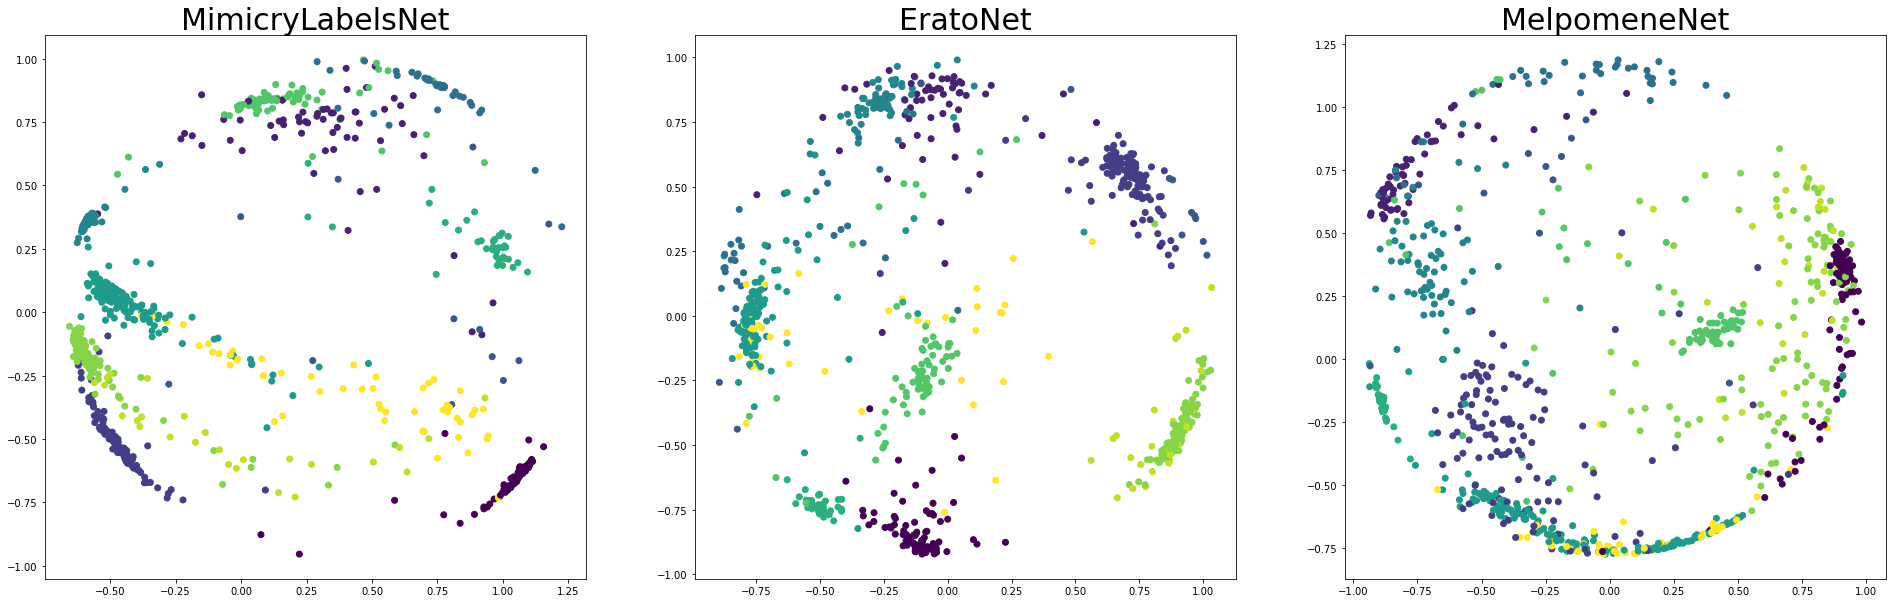

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
get_pca(mimicry_labels_net, data_mimic, labels_mimic, ax=ax0)
ax0.set_title('MimicryLabelsNet', fontsize=30)
get_pca(erato_net, data_mimic, labels_mimic, ax=ax1)
ax1.set_title('EratoNet', fontsize=30)
get_pca(melpomene_net, data_mimic, labels_mimic, ax=ax2)
ax2.set_title('MelpomeneNet', fontsize=30)

Text(0.5, 1.0, 'MelpomeneNet, Erato Images')

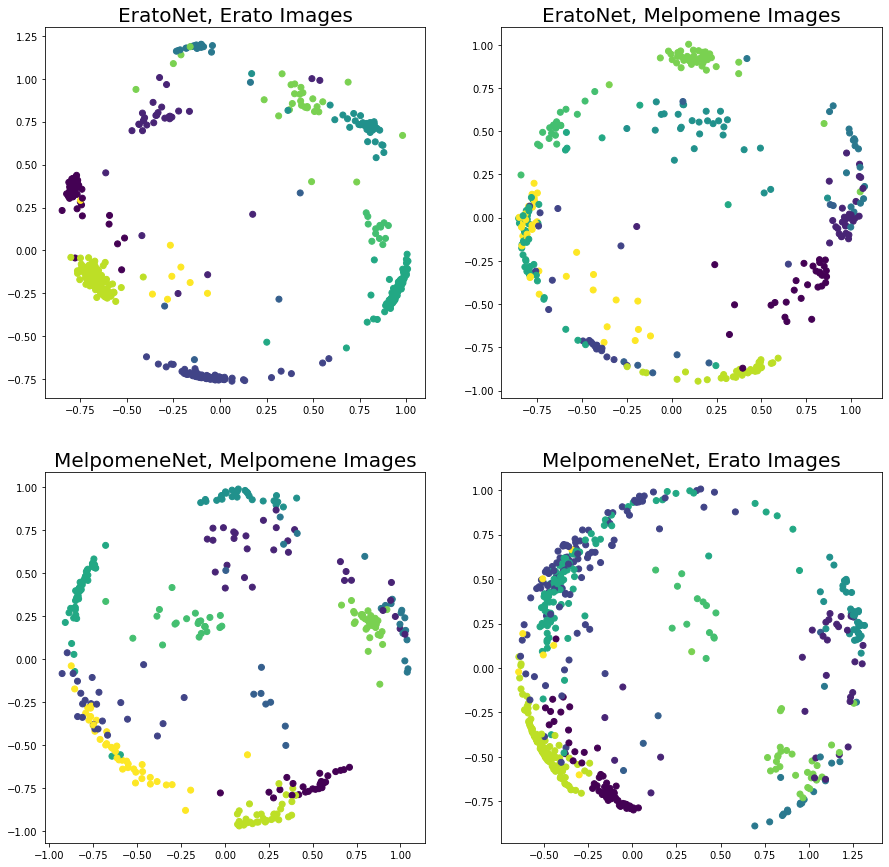

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
get_pca(erato_net, data_erato, labels_erato, ax=axs[0,0])
axs[0,0].set_title('EratoNet, Erato Images', fontsize=20)
get_pca(erato_net, data_melpomene, labels_melpomene, ax=axs[0,1])
axs[0,1].set_title('EratoNet, Melpomene Images', fontsize=20)
get_pca(melpomene_net, data_melpomene, labels_melpomene, ax=axs[1,0])
axs[1,0].set_title('MelpomeneNet, Melpomene Images', fontsize=20)
get_pca(melpomene_net, data_erato, labels_erato, ax=axs[1,1])
axs[1,1].set_title('MelpomeneNet, Erato Images', fontsize=20)

Text(0.5, 1.0, 'NonmimicNet')

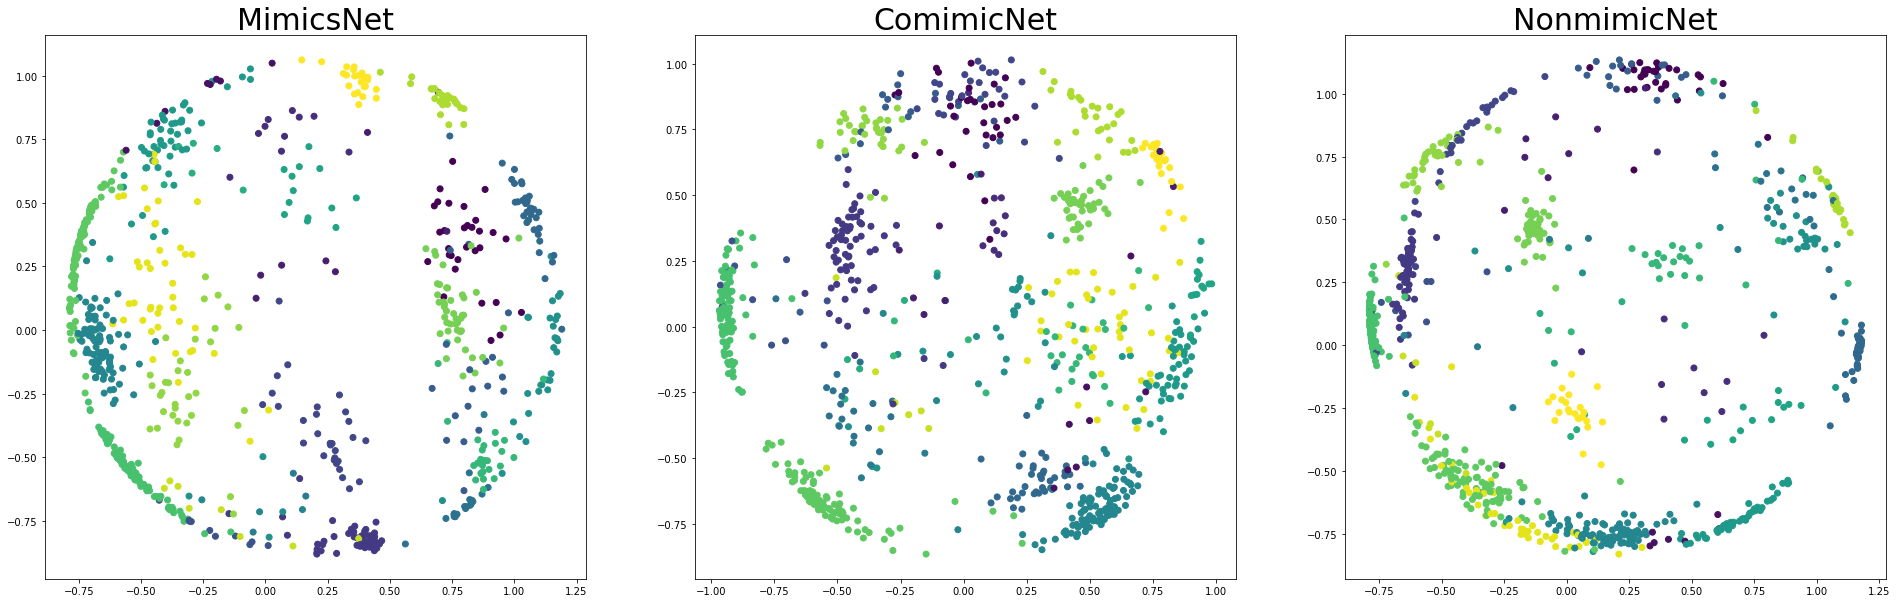

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
get_pca(all_comimics_net, data_only_comimics, labels_only_comimics, ax=ax0)
ax0.set_title('MimicsNet', fontsize=30)
get_pca(comimics_net, data_only_comimics, labels_only_comimics, ax=ax1)
ax1.set_title('ComimicNet', fontsize=30)
get_pca(nonmimics_net, data_only_comimics, labels_only_comimics, ax=ax2)
ax2.set_title('NonmimicNet', fontsize=30)

Text(0.5, 1.0, 'HardNegativeNet')

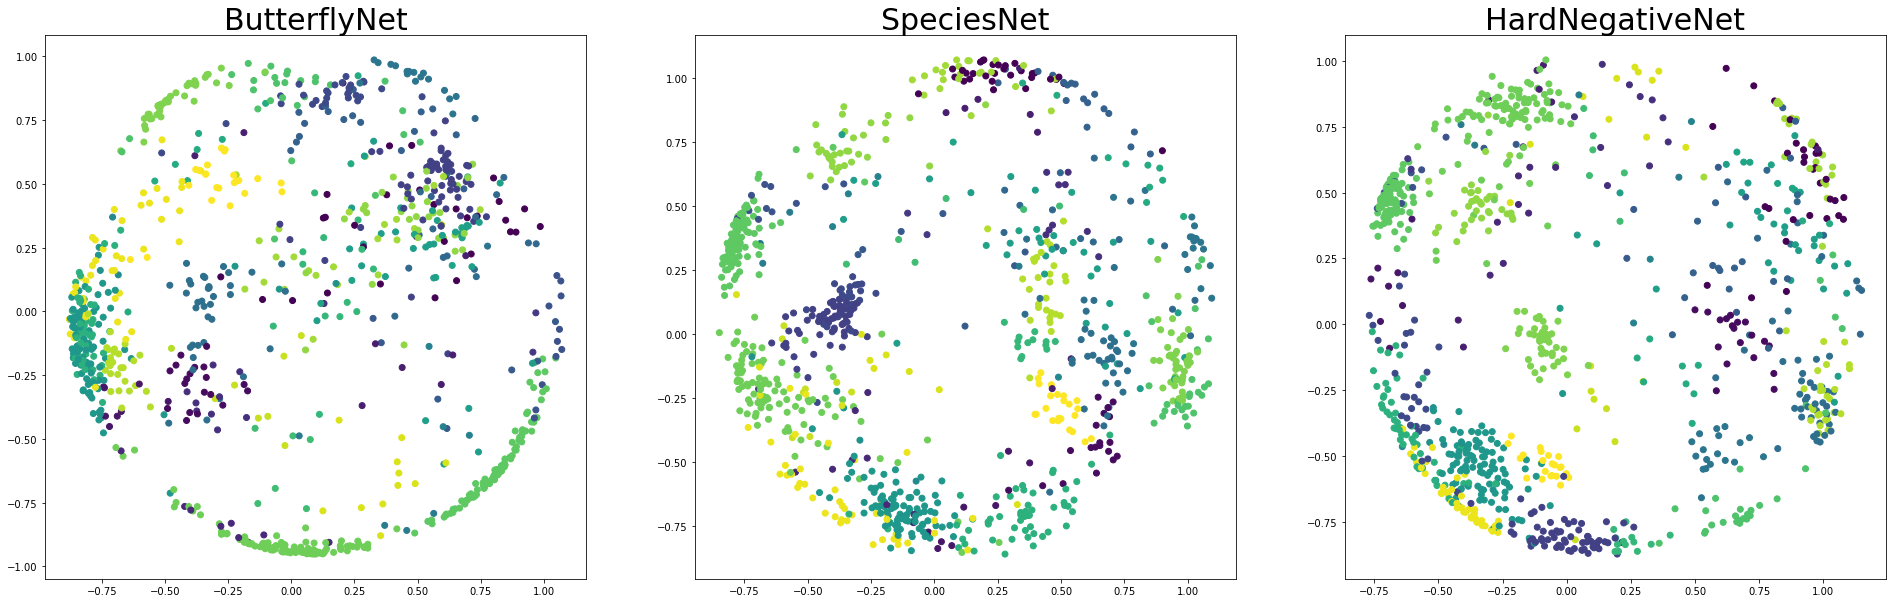

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
get_pca(regular_net, data_orig, labels_orig, ax=ax0)
ax0.set_title('ButterflyNet', fontsize=30)
get_pca(triplet_net, data_orig, labels_orig, ax=ax1)
ax1.set_title('SpeciesNet', fontsize=30)
get_pca(hard_negatives_net, test_loader, None, ax=ax2, negative=True)
ax2.set_title('HardNegativeNet', fontsize=30)

### Embedding Distances

In [ ]:
all_subspecies = set(data['Subspecies'].tolist())

In [ ]:
def get_correct_embeddings_negative(dataloader, net, dataset) : 
  species_embeddings = {ss : [] for ss in dataset['Subspecies'].tolist()}
  net.eval()
  batch_size = 100
  for index, (test_features, test_labels) in enumerate(dataloader) : 
    l = test_labels.data.numpy()
    z = net.get_embedding(test_features.cuda())
    
    p = net.predict(z).cpu().data.numpy() 
    z = z.cpu().data.numpy()

    curr_data = dataset.iloc[index*batch_size:(index*batch_size)+batch_size].reset_index(drop=True)

    for i in range(len(test_labels)) : 
      ss = curr_data['Subspecies'][i]
      if np.argmax(p[i]) == l[i] : 
        species_embeddings[ss].append(z[i])
  return species_embeddings

In [ ]:
def get_correct_embeddings(net, data, labels, subspecies) : 
  species_embeddings = {ss : [] for ss in subspecies}
  for i in range(data.shape[0]) : 
    # if subspecies[i] in comimics_subspecies : 
      batch = tovar(data[i:i+1])
      z = net.get_embedding(batch) 
      p = net.predict(z).cpu().data.numpy() 
      z = z.cpu().data.numpy()
      # if np.argmax(p) == labels[i:i+1] : 
      species_embeddings[subspecies[i]].append(z[0])
  return species_embeddings

In [ ]:
erato = set(all_numbered[all_numbered['Species'] == 'erato']['Subspecies'].tolist())
melpomene = set(all_numbered[all_numbered['Species'] == 'melpomene']['Subspecies'].tolist()).add('rosina')

In [ ]:
def get_identity(species_embeddings, species_list=None) : 
  distances = []
  if not species_list : species_list = species_embeddings.keys()
  for ss in species_list : 
    if ss in species_embeddings : 
      embeddings = species_embeddings[ss]
      for i in range(len(embeddings)) : 
        for j in range(i+1, len(embeddings)) :
          dist = np.linalg.norm(embeddings[i] - embeddings[j])
          distances.append(dist)
  return distances

In [ ]:
comimics_matches = {ss : [] for ss in comimics_subspecies} 
for i in range(len(comimics_table)) : 
  e, m = comimics_table['Erato'][i], comimics_table['Melpomene'][i]
  if m != 'amandus' : 
    if m not in comimics_matches[e] : comimics_matches[e].append(m)
    if e not in comimics_matches[m] : comimics_matches[m].append(e)

In [ ]:
def get_comimic(species_embeddings) : 
  distances = []
  for ss in species_embeddings : 
    if ss in comimics_matches : 
      embeddings = species_embeddings[ss] 
      comimic_embeddings = []
      for mm in comimics_matches[ss] : 
        if mm in species_embeddings : 
          comimic_embeddings += species_embeddings[mm]
      for i in range(len(embeddings)) : 
        for j in range(len(comimic_embeddings)) : 
          dist = np.linalg.norm(embeddings[i] - comimic_embeddings[j])
          distances.append(dist)
  return distances

In [ ]:
def get_other(species_embeddings, species_list=None) : 
  distances = []
  if not species_list : 
    species_list = species_embeddings.keys()
  for ss in species_list : 
    embeddings = species_embeddings[ss]
    other_embeddings = []
    for mm in species_list : 
      if mm != ss and (ss not in comimics_matches or mm not in comimics_matches[ss]) and mm in species_embeddings : 
        other_embeddings += species_embeddings[mm] 
    for i in range(len(embeddings)) : 
      for j in range(len(other_embeddings)) : 
        dist = np.linalg.norm(embeddings[i] - other_embeddings[j]) 
        distances.append(dist)
  return distances

In [ ]:
def get_boxplot(net, data, labels, subspecies, ax = None, negative=False) : 
  if negative : species_embeddings = get_correct_embeddings_negative(labels, net, data)
  else : species_embeddings = get_correct_embeddings(net, data, labels, subspecies)
  identity_distances = get_identity(species_embeddings)
  comimic_distances = get_comimic(species_embeddings)
  other_distances = get_other(species_embeddings)
  if not ax : fig, ax = plt.subplots(figsize=(8, 6))
  _ = ax.boxplot([identity_distances, comimic_distances, other_distances])
  ax.set_xticklabels(['identity', 'comimics', 'other'])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


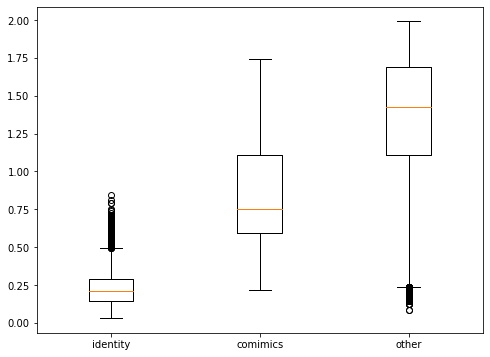

In [ ]:
get_boxplot(hard_negatives_net, negative_data, test_loader, None, negative=True)

In [ ]:
def get_boxplot_separate(net, data, labels, subspecies, ax=None, negative=False) : 
  if negative : species_embeddings = get_correct_embeddings_negative(labels, net, data)
  else : species_embeddings = get_correct_embeddings(net, data, labels, subspecies)
  identity_distances_erato = get_identity(species_embeddings, erato)
  identity_distances_melpomene = get_identity(species_embeddings, melpomene)
  comimic_distances = get_comimic(species_embeddings)
  other_distances_erato = get_other(species_embeddings, erato)
  other_distances_melpomene = get_other(species_embeddings, melpomene)
  if not ax : fig, ax = plt.subplots(figsize=(8, 6))
  _ = ax.boxplot([identity_distances_erato, identity_distances_melpomene, comimic_distances, other_distances_erato, other_distances_melpomene], sym='')
  ax.set_xticklabels(['identity\nerato', 'identity\nmelpomene', 'mimic', 'other\nerato', 'other\nmelpomene'], fontsize=20)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


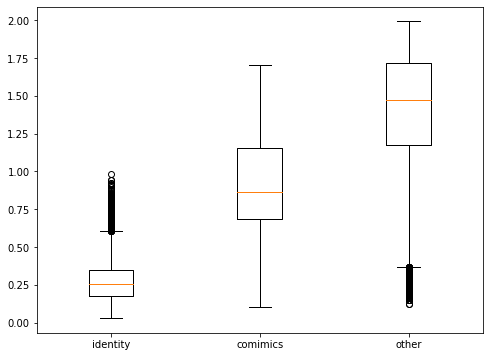

In [ ]:
get_boxplot(regular_net, data_orig, labels_orig, subspecies_orig)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


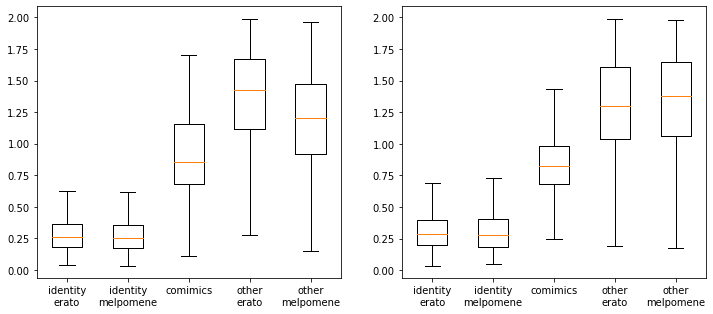

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(12, 5))
get_boxplot_separate(regular_net, data_orig, labels_orig, subspecies_orig, ax=ax0)
get_boxplot_separate(triplet_net, data_orig, labels_orig, subspecies_orig, ax=ax1)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


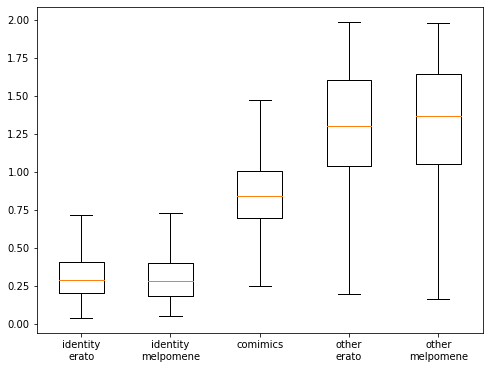

In [ ]:
get_boxplot_separate(triplet_net, data_orig, labels_orig, subspecies_orig)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'HardNegativesNet')

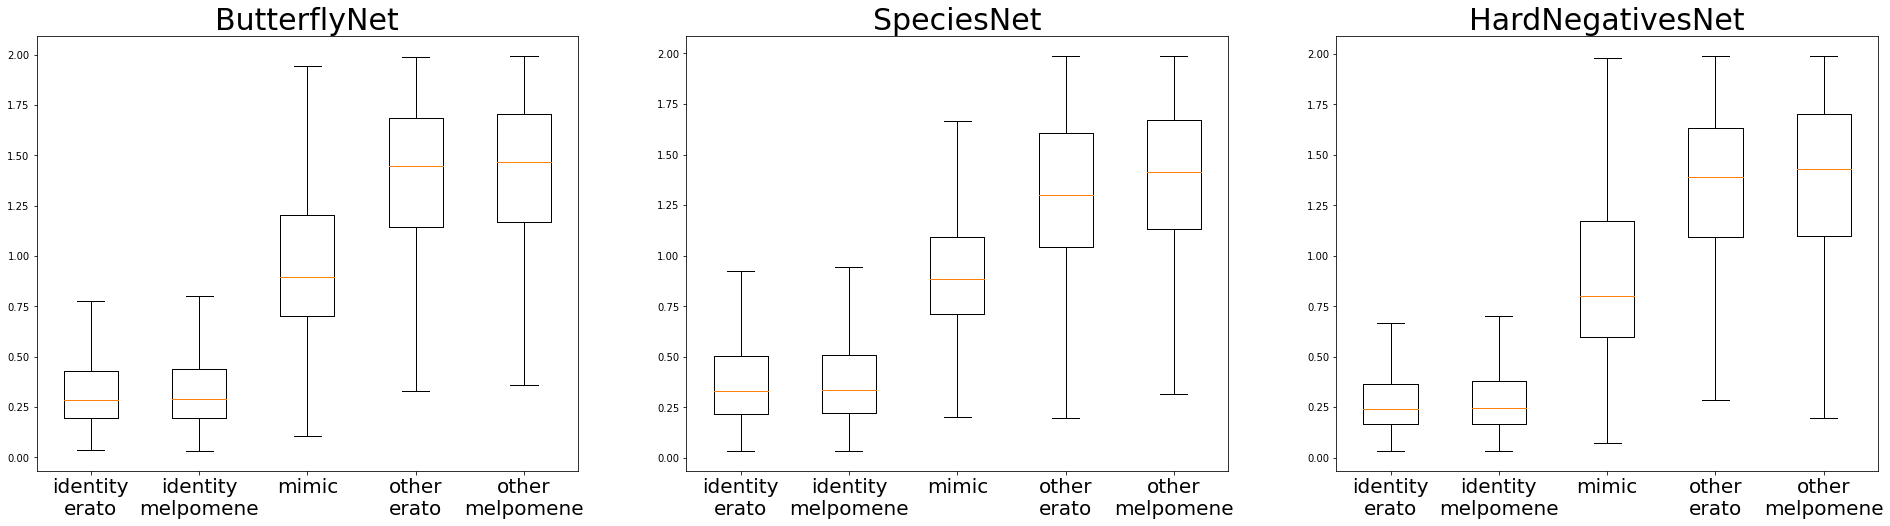

In [ ]:
# Incorrect and correct embeddings
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(regular_net, data_orig, labels_orig, subspecies_orig, ax=ax0)
get_boxplot_separate(triplet_net, data_orig, labels_orig, subspecies_orig, ax=ax1)
ax0.set_title('ButterflyNet', fontsize=30)
ax1.set_title('SpeciesNet', fontsize=30)
get_boxplot_separate(hard_negatives_net, negative_data, test_loader, None, ax=ax2, negative=True)
ax2.set_title('HardNegativesNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'HardNegativesNet')

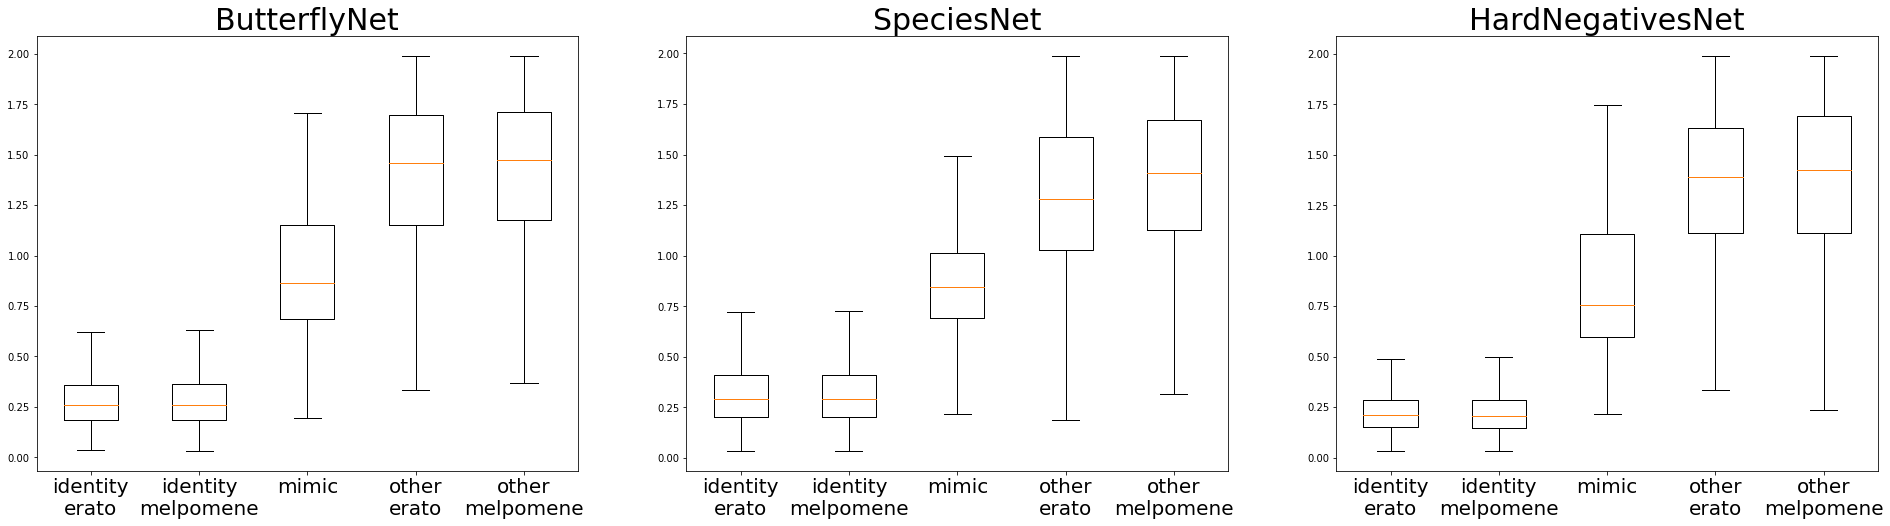

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(regular_net, data_orig, labels_orig, subspecies_orig, ax=ax0)
get_boxplot_separate(triplet_net, data_orig, labels_orig, subspecies_orig, ax=ax1)
ax0.set_title('ButterflyNet', fontsize=30)
ax1.set_title('SpeciesNet', fontsize=30)
get_boxplot_separate(hard_negatives_net, negative_data, test_loader, None, ax=ax2, negative=True)
ax2.set_title('HardNegativesNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'MelpomeneNet')

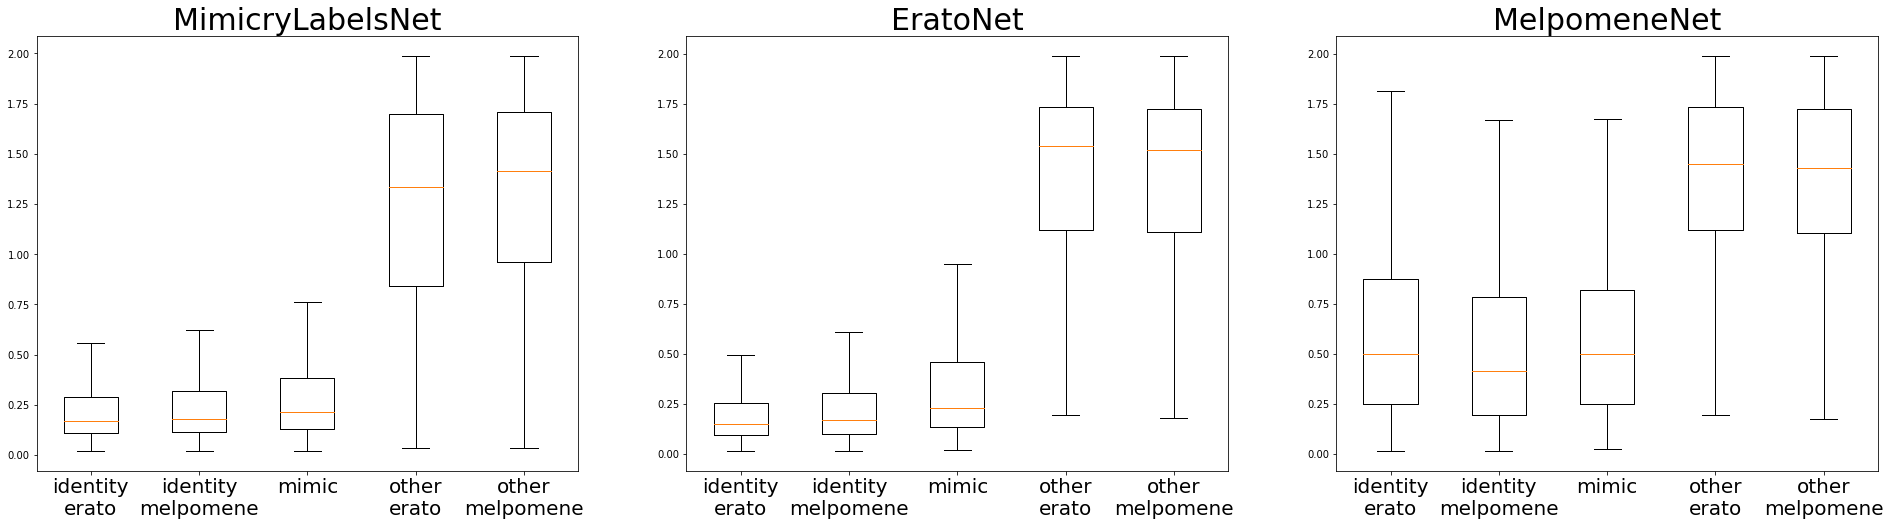

In [ ]:
# correct and incorrect embeddings
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(mimicry_labels_net, data_mimic, labels_mimic, subspecies_mimic, ax=ax0)
ax0.set_title('MimicryLabelsNet', fontsize=30)
get_boxplot_separate(erato_net, data_mimic, labels_mimic, subspecies_mimic, ax=ax1)
ax1.set_title('EratoNet', fontsize=30)
get_boxplot_separate(melpomene_net, data_mimic, labels_mimic,subspecies_mimic, ax=ax2)
ax2.set_title('MelpomeneNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'MelpomeneNet')

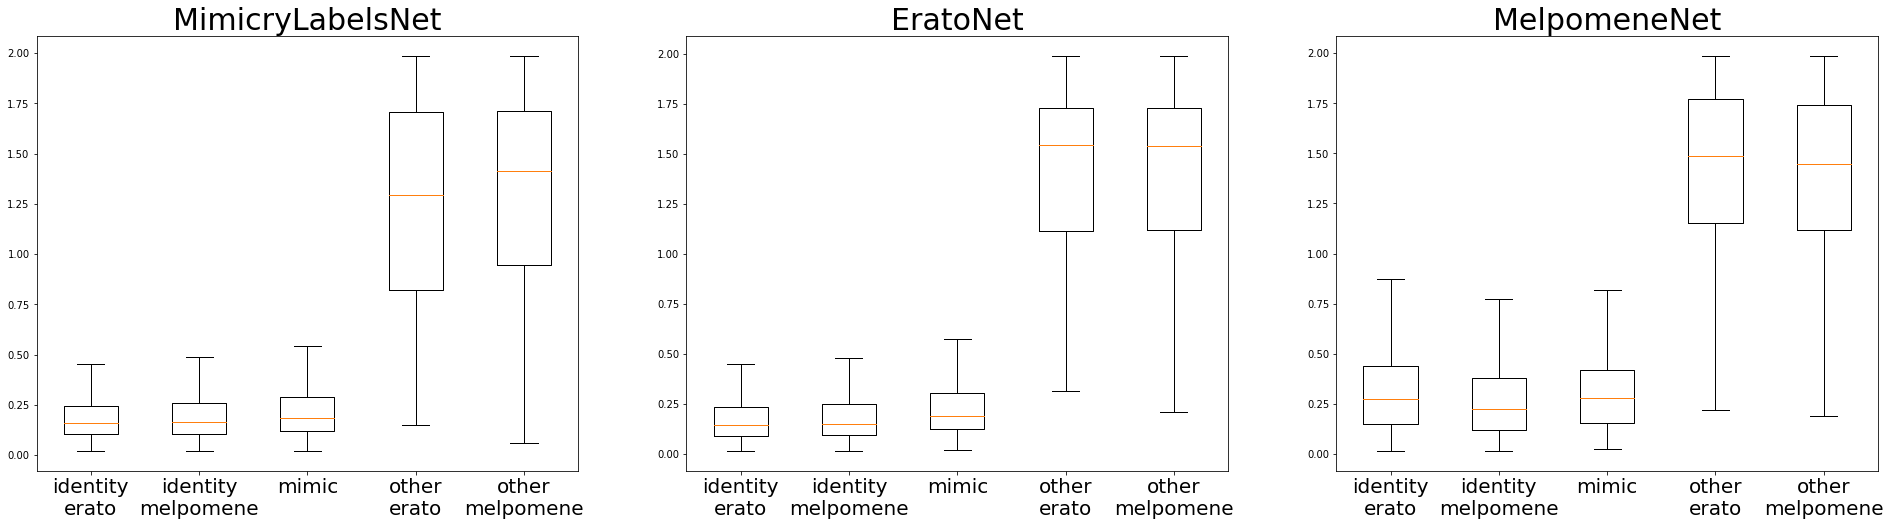

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(mimicry_labels_net, data_mimic, labels_mimic, subspecies_mimic, ax=ax0)
ax0.set_title('MimicryLabelsNet', fontsize=30)
get_boxplot_separate(erato_net, data_mimic, labels_mimic, subspecies_mimic, ax=ax1)
ax1.set_title('EratoNet', fontsize=30)
get_boxplot_separate(melpomene_net, data_mimic, labels_mimic,subspecies_mimic, ax=ax2)
ax2.set_title('MelpomeneNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'MelpomeneNet')

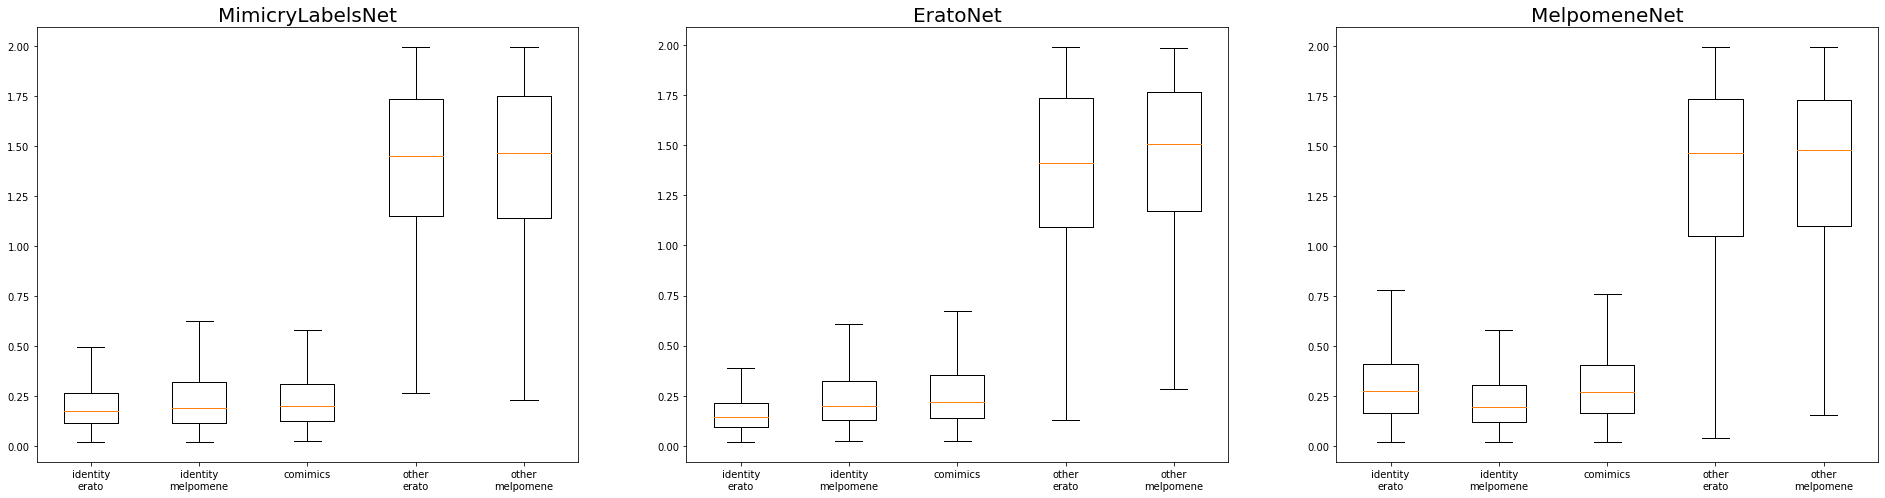

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(mimicry_labels_net, data_mimic, labels_mimic, subspecies_mimic, ax=ax0)
ax0.set_title('MimicryLabelsNet', fontsize=20)
get_boxplot_separate(erato_net, data_mimic, labels_mimic, subspecies_mimic, ax=ax1)
ax1.set_title('EratoNet', fontsize=20)
get_boxplot_separate(melpomene_net, data_mimic, labels_mimic,subspecies_mimic, ax=ax2)
ax2.set_title('MelpomeneNet', fontsize=20)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'NonmimicNet')

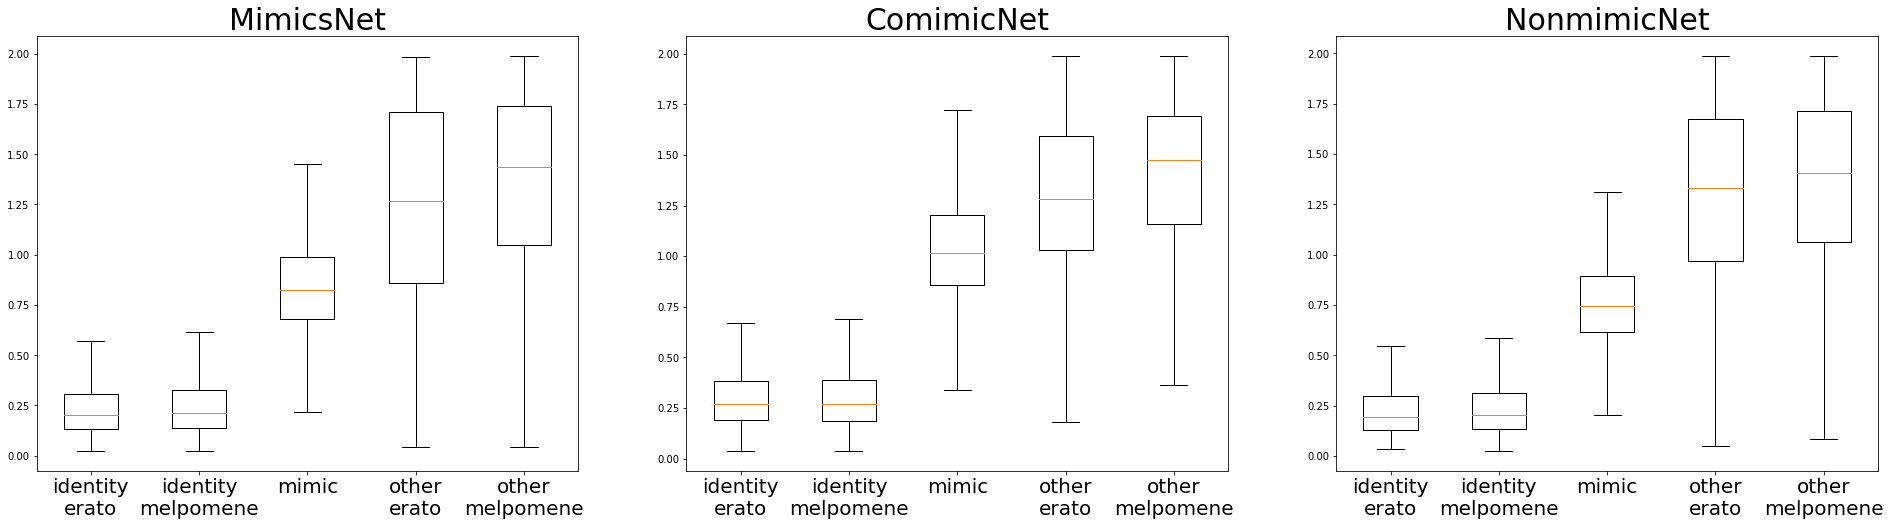

In [ ]:
# correct and incorrect embeddings
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(all_comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax0)
ax0.set_title('MimicsNet', fontsize=30)
get_boxplot_separate(comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax1)
ax1.set_title('ComimicNet', fontsize=30)
get_boxplot_separate(nonmimics_net, data_only_comimics, labels_only_comimics,subspecies_only_comimics, ax=ax2)
ax2.set_title('NonmimicNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'NonmimicNet')

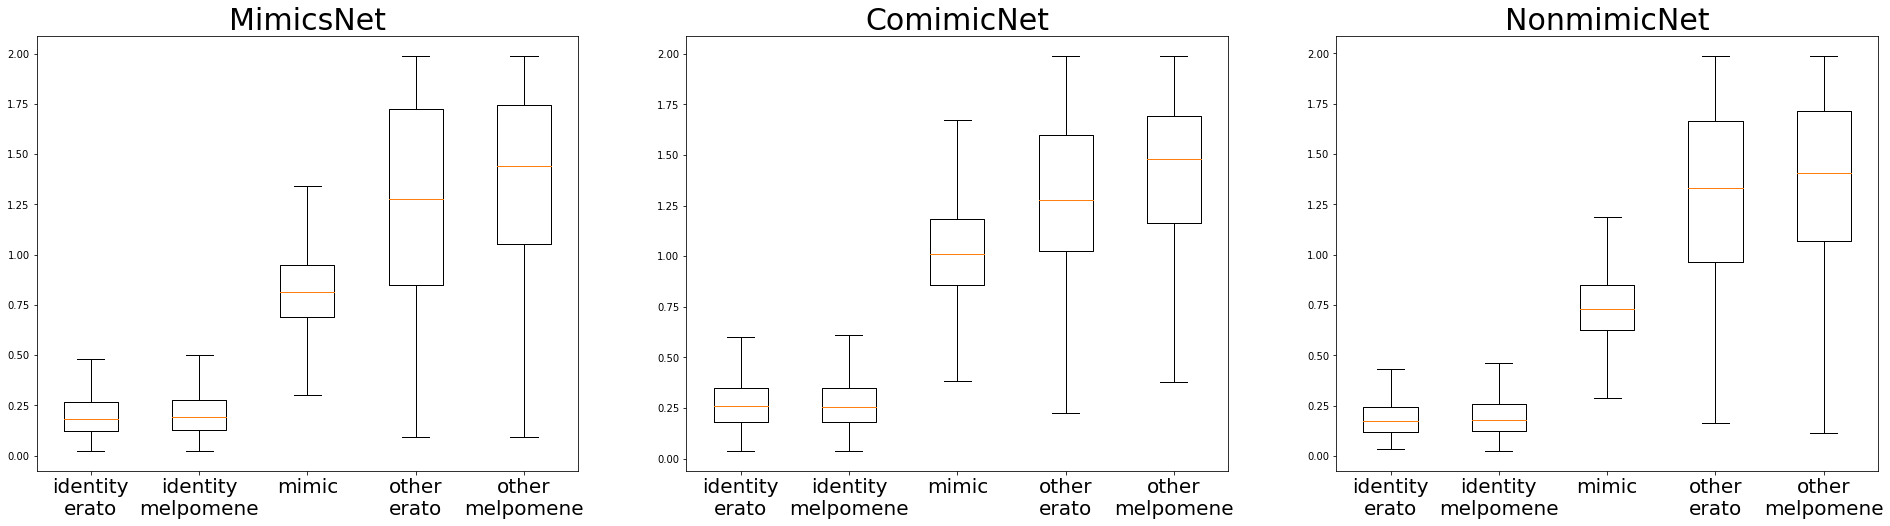

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(all_comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax0)
ax0.set_title('MimicsNet', fontsize=30)
get_boxplot_separate(comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax1)
ax1.set_title('ComimicNet', fontsize=30)
get_boxplot_separate(nonmimics_net, data_only_comimics, labels_only_comimics,subspecies_only_comimics, ax=ax2)
ax2.set_title('NonmimicNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'NonmimicNet')

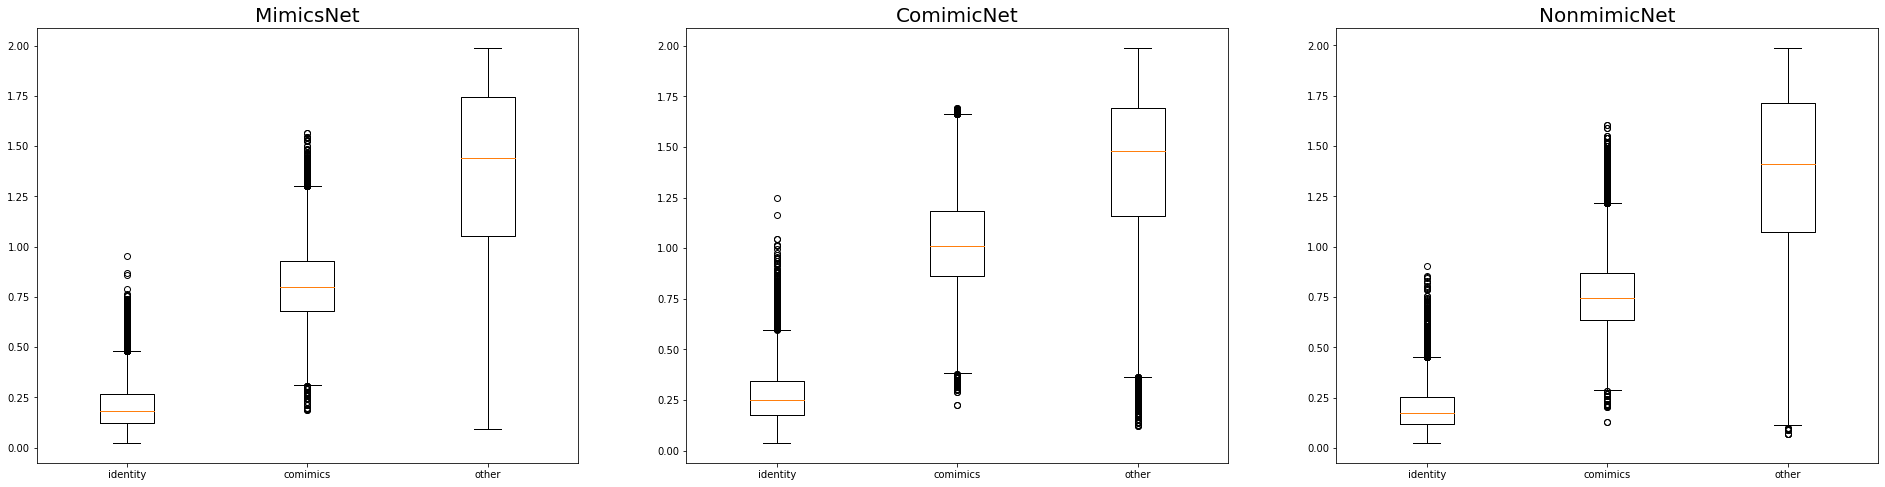

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot(all_comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax0)
ax0.set_title('MimicsNet', fontsize=20)
get_boxplot(comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax1)
ax1.set_title('ComimicNet', fontsize=20)
get_boxplot(nonmimics_net, data_only_comimics, labels_only_comimics,subspecies_only_comimics, ax=ax2)
ax2.set_title('NonmimicNet', fontsize=20)

### Confusion matrices

In [ ]:
def confusion_matrix_negative(dataloader, net, dataset) : 
  subspecies_list = set(dataset['Subspecies'].tolist())
  breakdown = {ss : [0] *len(subspecies_list) for ss in subspecies_list}
  counts = {ss: 0 for ss in subspecies_list}
  net.eval()
  batch_size = 100
  for index, (test_features, test_labels) in enumerate(dataloader) : 
    l = test_labels.data.numpy()
    z = net.get_embedding(test_features.cuda())
    
    p = net.predict(z).cpu().data.numpy() 
    z = z.cpu().data.numpy()

    curr_data = dataset.iloc[index*batch_size:(index*batch_size)+batch_size].reset_index(drop=True)

    for i in range(len(test_labels)) : 
      ss = curr_data['Subspecies'][i]
      normalized = p[i] / np.sum(p[i])
      breakdown[ss] += normalized
      counts[ss] += 1
  return {ss : breakdown[ss] / counts[ss] for ss in breakdown}

In [ ]:
def confusion_matrix(data, labels, subspecies, net) : 
  breakdown = {ss : [0] * len(set(labels)) for ss in subspecies}
  counts = {ss: 0 for ss in subspecies}
  for i in range(len(data)) : 
    batch = tovar(data[i:i+1])
    l = labels[i:i+1]
    z = net.get_embedding(batch)                
    p = net.predict(z).cpu().data.numpy()
    normalized = p / np.sum(p)
    if len(normalized[0]) != len(breakdown[subspecies[i]]) : 
      breakdown[subspecies[i]] += normalized[0][:-1]
    breakdown[subspecies[i]] += normalized[0]
    counts[subspecies[i]] += 1
  return {ss : breakdown[ss] / counts[ss] for ss in breakdown}

In [ ]:
def create_matrix_labels(net, data, labels, subspecies, xlabels, ylabels, ax = None, title="") : 
  cm = confusion_matrix(data, labels, subspecies, net)
  ordered = {subspecies[i] : labels[i] for i in range(len(labels)) if subspecies[i] != 'nanna'}
  ordered = [(ordered[key], key) for key in ordered]
  ordered.sort(key = lambda x :x[0] )
  ordered = [elt[1] for elt in ordered]
  heatmap_data = []
  for o in ordered: 
    heatmap_data.append(cm[o])
  if not ax : 
    fig, ax = plt.subplots(figsize=(12, 10))  
  colorbar = ax.pcolormesh( heatmap_data , cmap = 'coolwarm' )
  ax.set_xticks(np.arange(len(xlabels))+0.5)
  ax.set_xticklabels(xlabels, fontsize=20)
  ax.set_yticks(np.arange(len(ylabels))+0.5)
  ax.set_yticklabels(ylabels, fontsize=20)
  labels = plt.setp(ax.get_xticklabels(), rotation=30)
  labels = plt.setp(ax.get_yticklabels(), rotation=30)
  ax.set_title(title, fontsize=30)
  if not ax : plt.colorbar(colorbar)

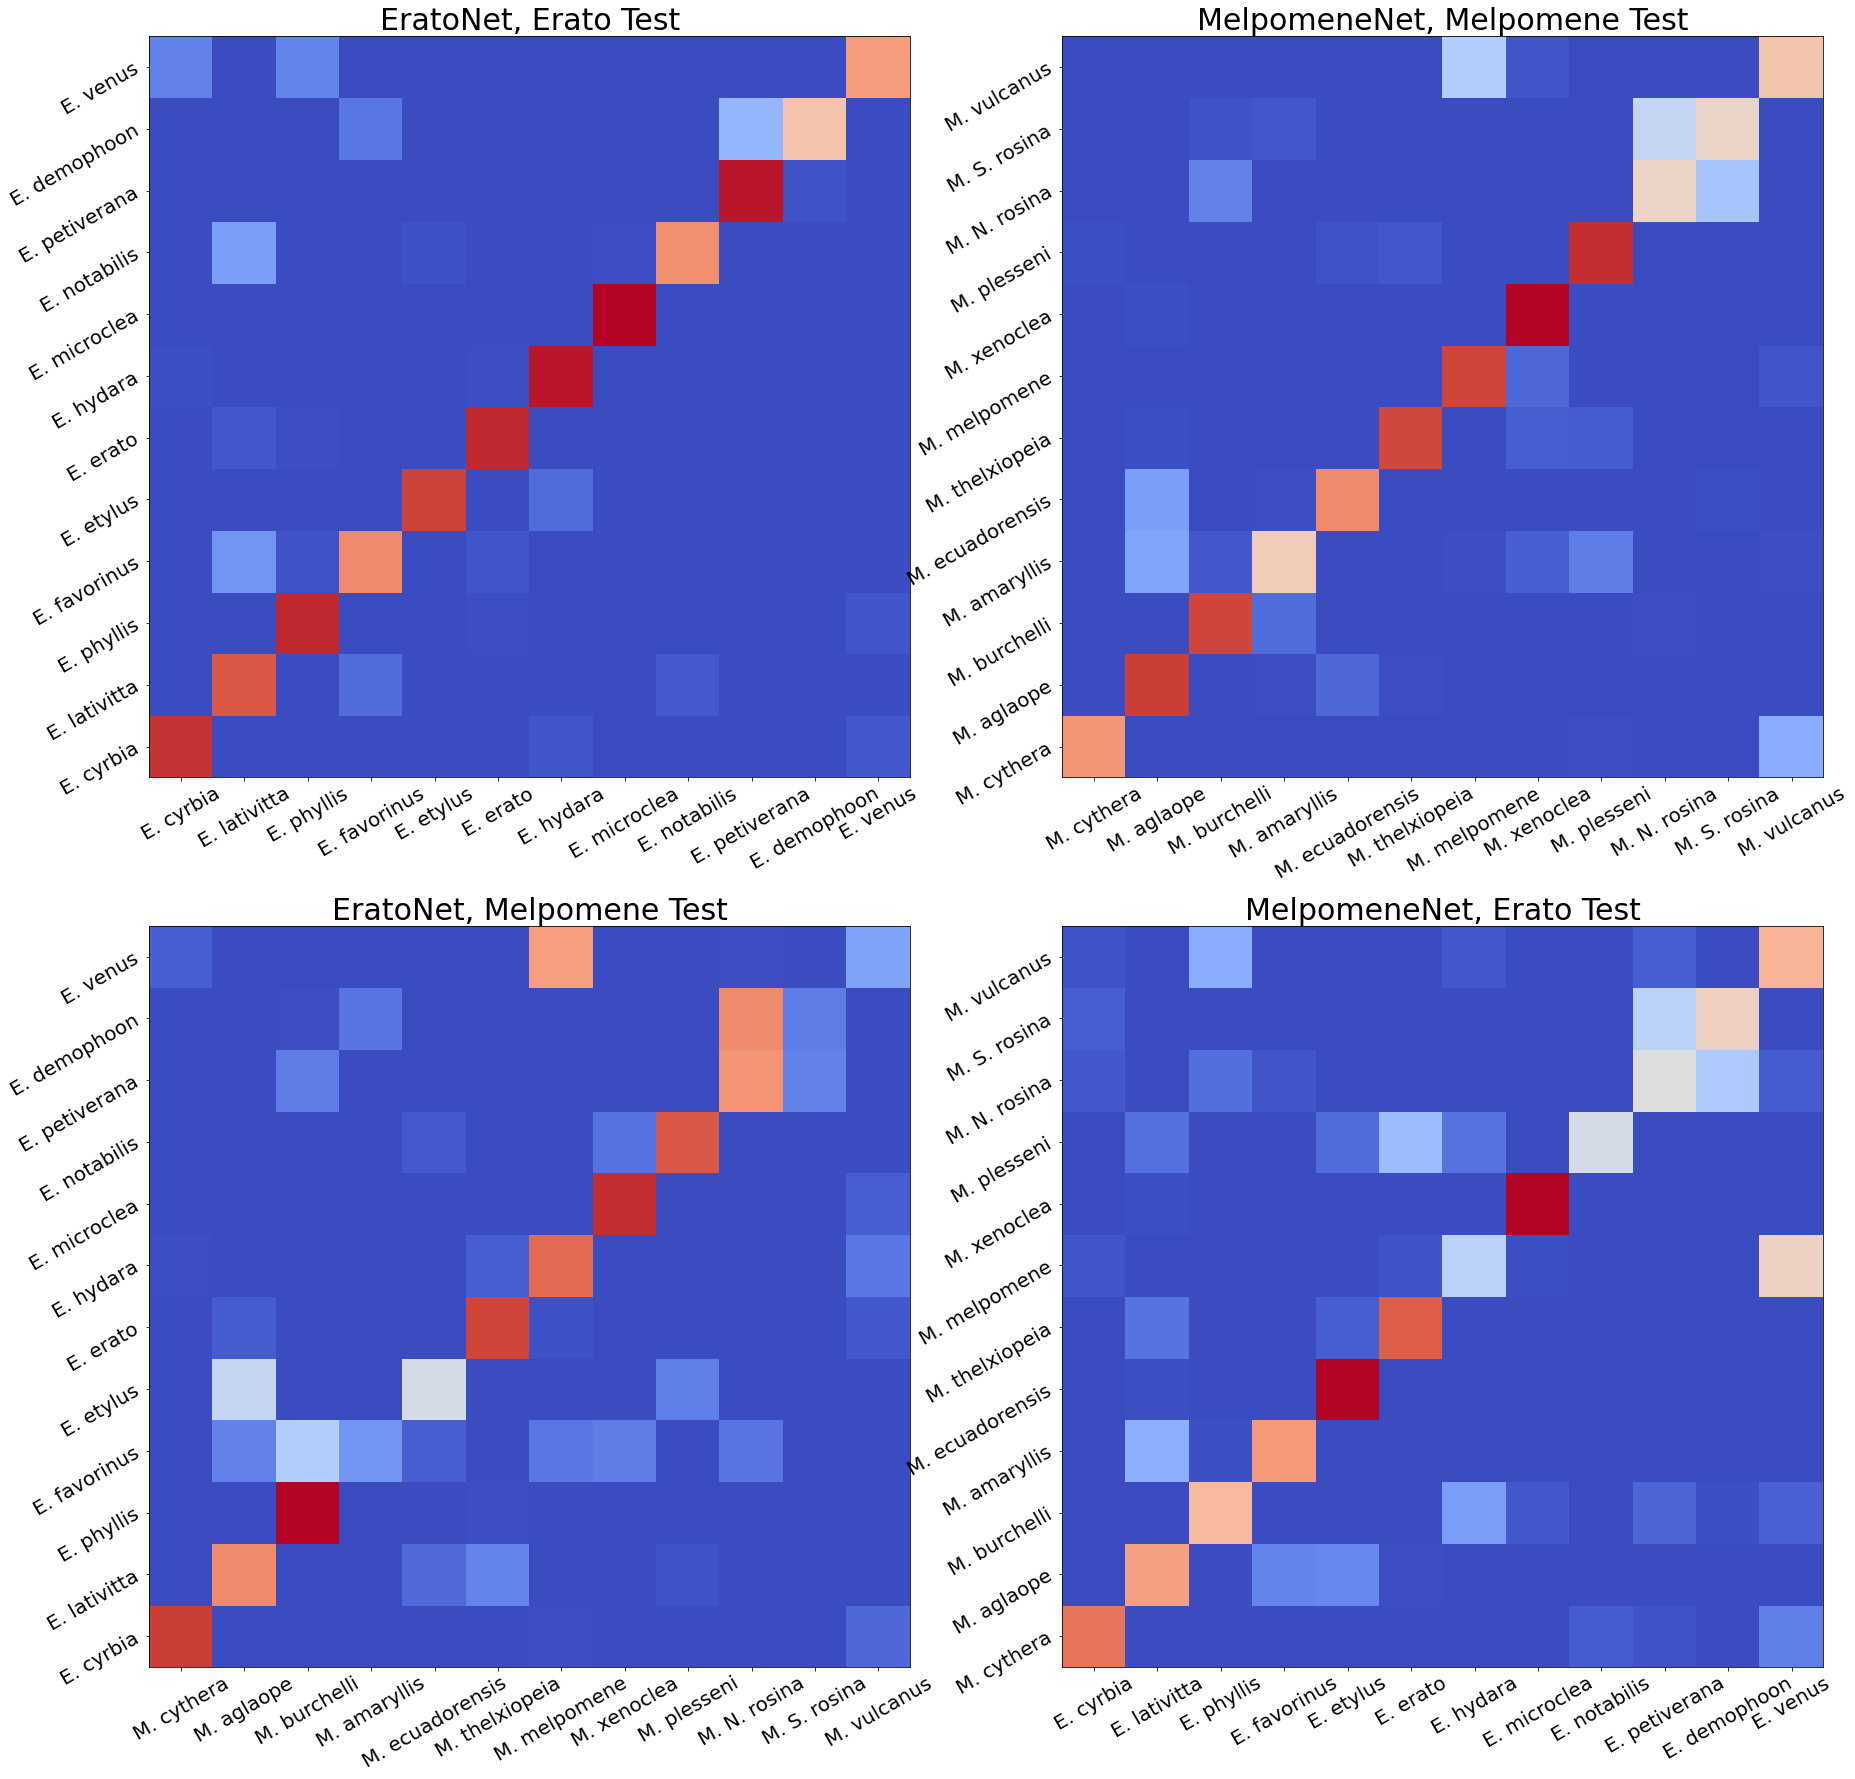

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
create_matrix_labels(erato_net, data_erato, labels_erato, subspecies_erato, ordered_e, ordered_e, ax=axs[0,0], title='EratoNet, Erato Test')
create_matrix_labels(melpomene_net, data_melpomene, labels_melpomene, subspecies_melpomene, ordered_m, ordered_m, ax=axs[0,1], title='MelpomeneNet, Melpomene Test')
create_matrix_labels(erato_net, data_melpomene, labels_melpomene, subspecies_melpomene, ordered_m, ordered_e, ax=axs[1,0], title='EratoNet, Melpomene Test')
create_matrix_labels(melpomene_net, data_erato, labels_erato, subspecies_erato, ordered_e, ordered_m, ax=axs[1,1], title='MelpomeneNet, Erato Test')

In [ ]:
ordered_m = {subspecies_melpomene[i] : labels_melpomene[i] for i in range(len(labels_melpomene)) if subspecies_melpomene[i] != 'nanna'}
ordered_m = [(ordered_m[key], key) for key in ordered_m]
ordered_m.sort(key = lambda x :x[0] )
ordered_m = ['M. ' + elt[1] for elt in ordered_m]

ordered_e = {subspecies_erato[i] : labels_erato[i] for i in range(len(labels_erato))}
ordered_e = [(ordered_e[key], key) for key in ordered_e]
ordered_e.sort(key = lambda x :x[0] )
ordered_e = ['E. ' + elt[1] for elt in ordered_e]

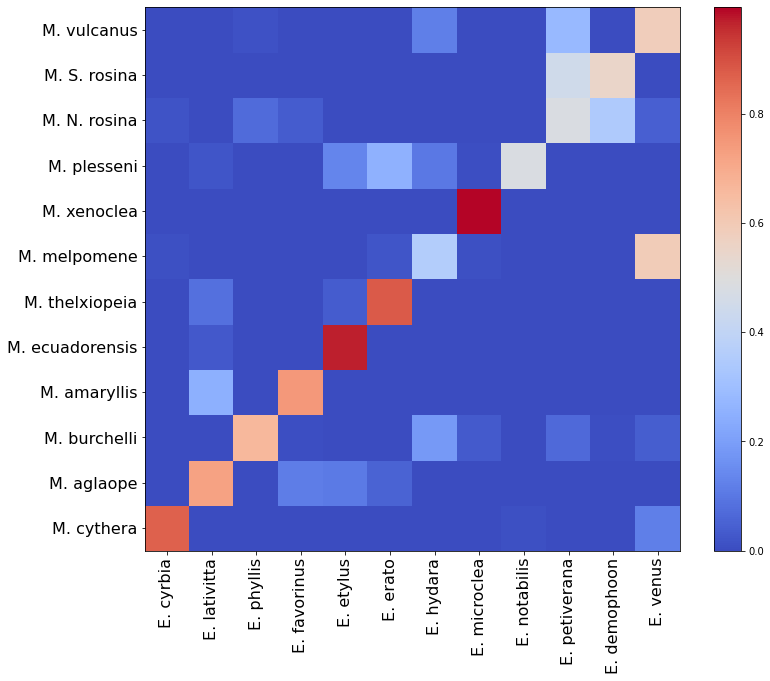

In [ ]:
create_matrix_labels(melpomene_net, data_erato, labels_erato, subspecies_erato, ordered_e, ordered_m)

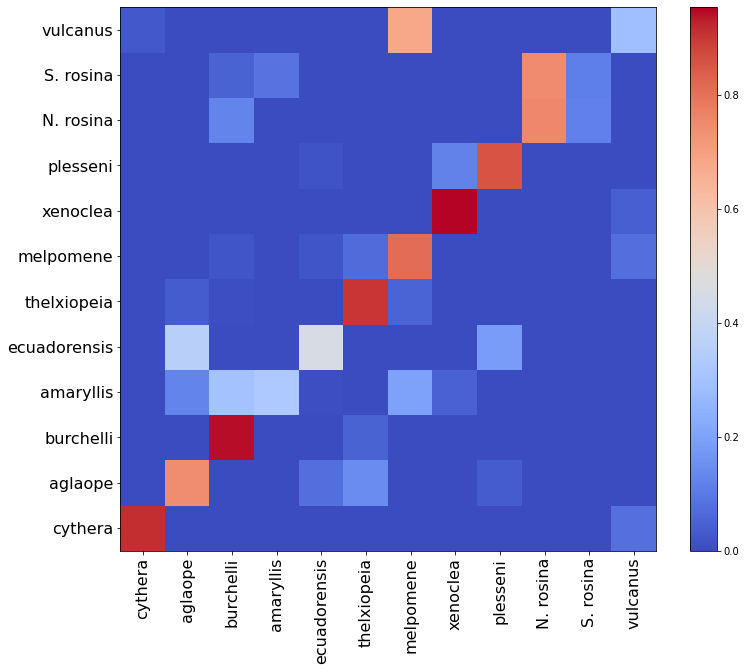

In [ ]:
create_matrix_labels(erato_net, data_melpomene, labels_melpomene, subspecies_melpomene)

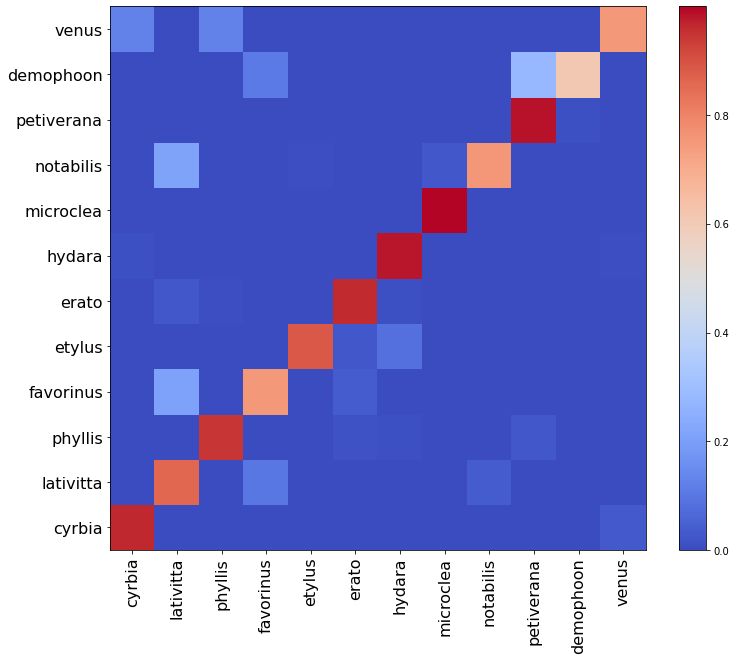

In [ ]:
create_matrix_labels(erato_net, data_erato, labels_erato, subspecies_erato)

In [ ]:
def create_matrix(net, data, labels, subspecies, ax = None, negative=None) :   
  if negative : breakdown = confusion_matrix_negative(negative, net, data)
  else : breakdown = confusion_matrix(data, labels, subspecies, net)
  comimics_labels = {labels[i] : subspecies[i] for i in range(len(labels))}
  comimics_match = {subspecies[i] : labels[i] for i in range(len(labels))}
  confusion_data = []
  include_these = [comimics_match[ss] for ss in comimics_subspecies]
  include_these.sort()
  for i in range(len(set(labels))): 
    ss = comimics_labels[i]
    if ss in comimics_subspecies : 
      accs = breakdown[comimics_labels[i]]
      accs = np.take(accs, include_these)
      confusion_data.append(accs)
  subspecies_alphabetical = comimics_subspecies
  subspecies_alphabetical.sort()
  if not ax : 
    fig, ax = plt.subplots(figsize=(10, 10))  
  colorbar = ax.pcolormesh( confusion_data , cmap = 'coolwarm' )

  ax.set_xticks(np.arange(len(subspecies_alphabetical))+0.5)
  ax.set_xticklabels(subspecies_alphabetical, fontsize=16)
  ax.set_yticks(np.arange(len(subspecies_alphabetical))+0.5)
  ax.set_yticklabels(subspecies_alphabetical, fontsize=16)
  labels = plt.setp(ax.get_xticklabels(), rotation=90)
  print(subspecies_alphabetical)
  comimics_labels = {i : subspecies_alphabetical[i] for i in range(len(subspecies_alphabetical))}
  for i in range(len(subspecies_alphabetical)):
      for j in range(len(subspecies_alphabetical)):
          # if test[i] == 'Network trained \nwith hard negatives' : 
          #   color = 'tab:blue' 
          # else : color='w'
          ss = comimics_labels[i] 
          if ss in comimics_subspecies : 
            mimics = comimics_matches[ss] 
            acc_name = comimics_labels[j] 
            if acc_name in mimics : 
              text = ax.text(j+0.5, i+0.5, 'X', ha="center", va="center", color='white', size=16)
  # plt.colorbar(colorbar)

['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']
['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']
['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']


Text(0.5, 1.0, 'NonmimicNet')

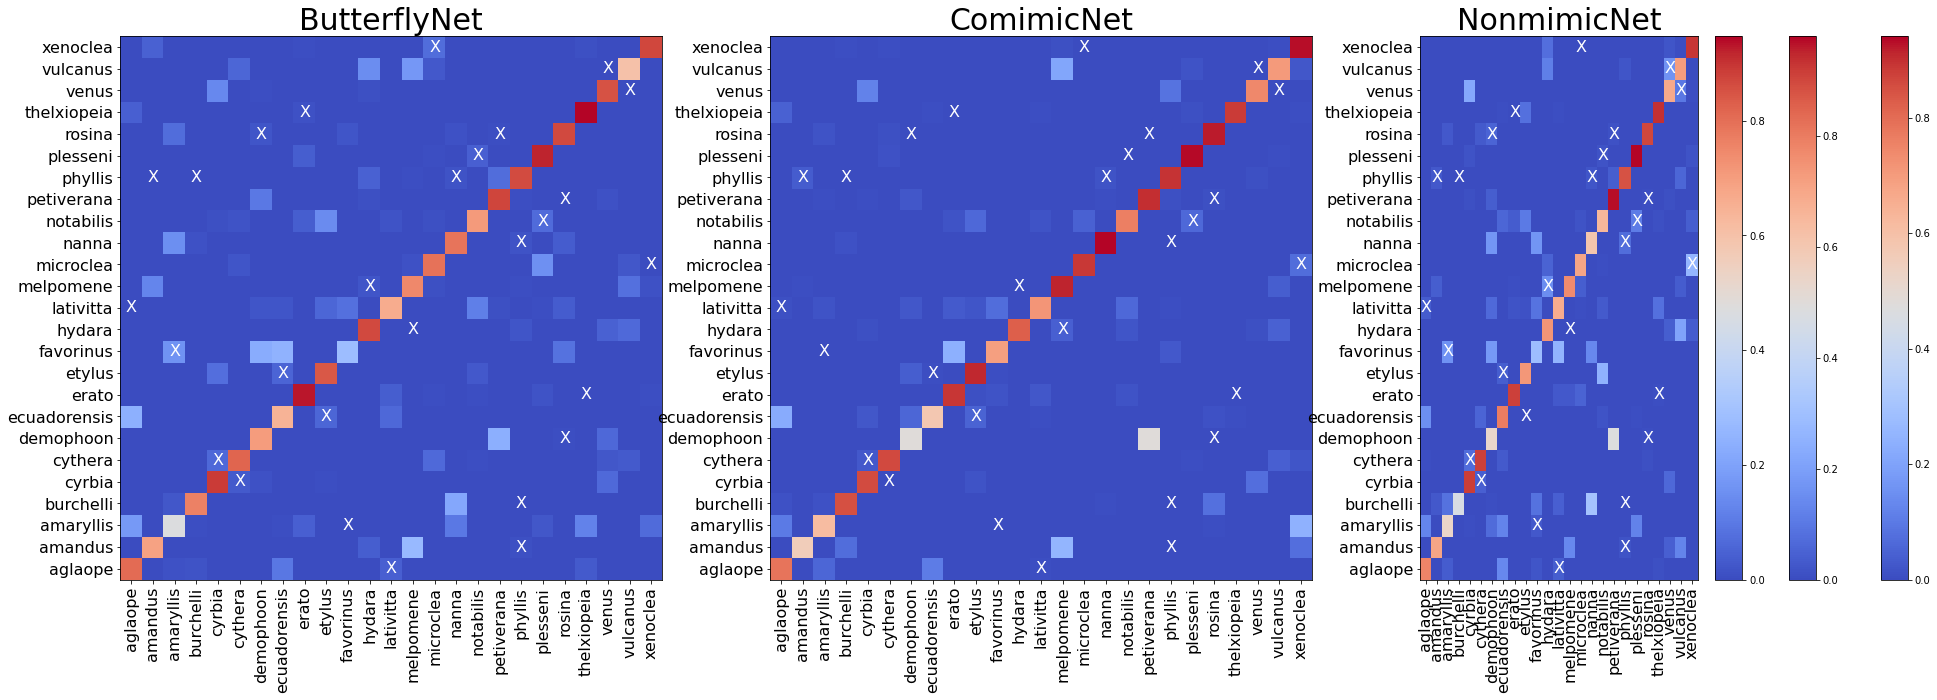

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
create_matrix(all_comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax0)
ax0.set_title('ButterflyNet', fontsize=30)
create_matrix(comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax1)
ax1.set_title('ComimicNet', fontsize=30)
create_matrix(nonmimics_net, data_only_comimics, labels_only_comimics,subspecies_only_comimics, ax=ax2)
ax2.set_title('NonmimicNet', fontsize=30)

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
create_matrix(all_comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax0)
ax0.set_title('ButterflyNet', fontsize=30)
create_matrix(comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax1)
ax1.set_title('ComimicNet', fontsize=30)
create_matrix(nonmimics_net, data_only_comimics, labels_only_comimics,subspecies_only_comimics, ax=ax2)
ax2.set_title('NonmimicNet', fontsize=30)

['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']


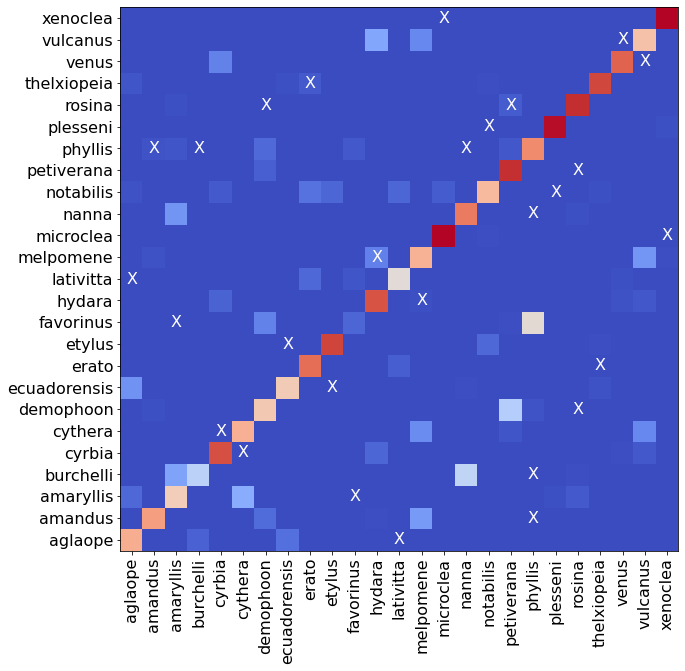

In [ ]:
create_matrix(hard_negatives_net, negative_data, negative_data['Label'].tolist(), negative_data['Subspecies'].tolist(), negative=test_loader)

['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']
['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']
['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']


Text(0.5, 1.0, 'HardNegativeNet')

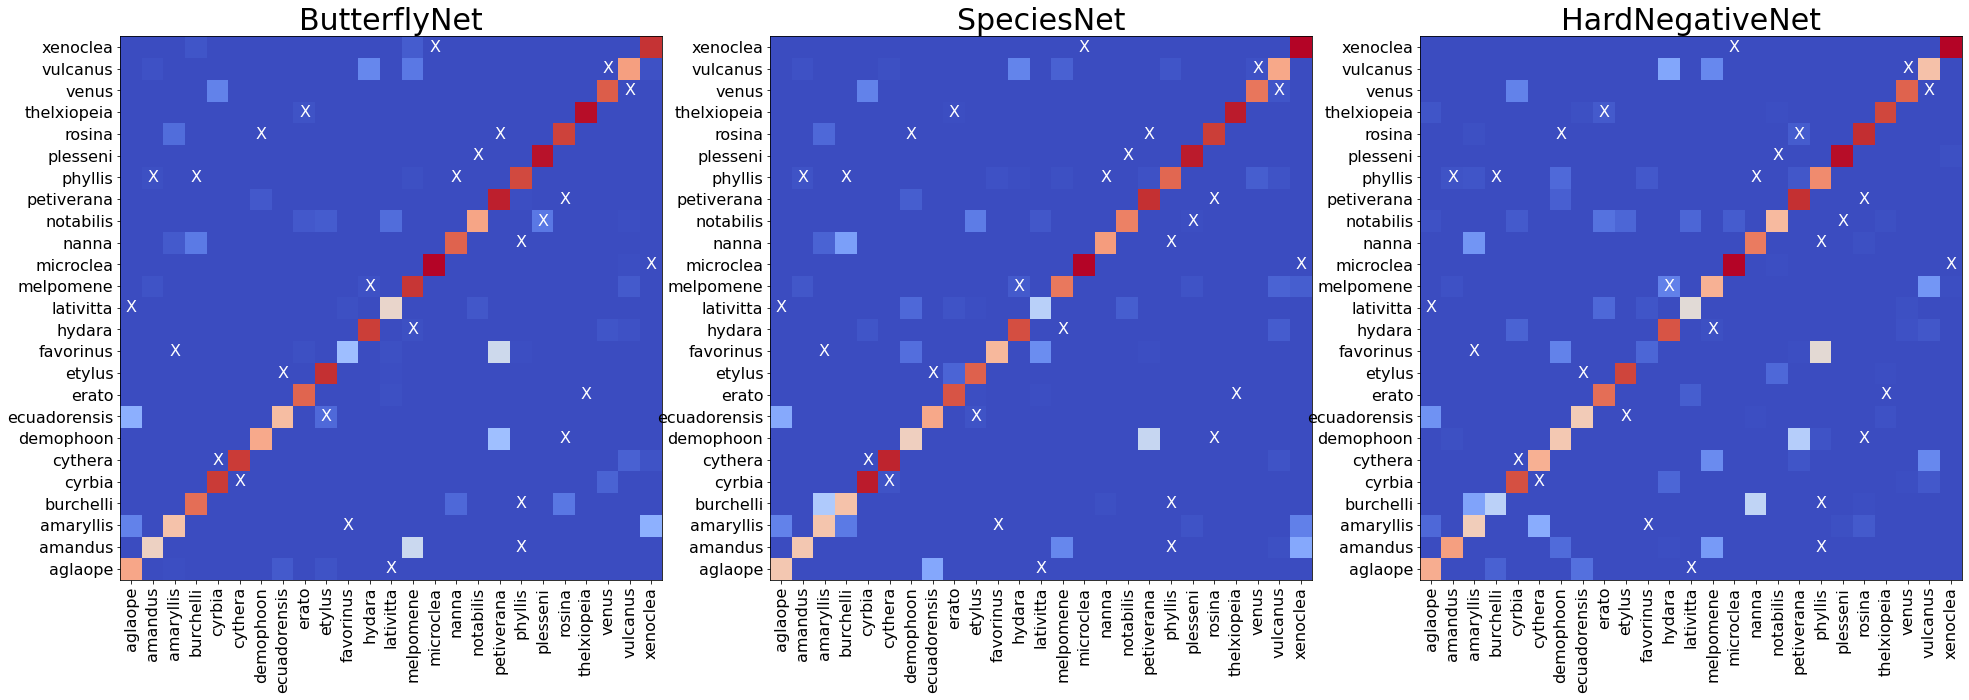

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
create_matrix(regular_net, data_orig, labels_orig, subspecies_orig, ax=ax0)
ax0.set_title('ButterflyNet', fontsize=30)
create_matrix(triplet_net, data_orig, labels_orig, subspecies_orig, ax=ax1)
ax1.set_title('SpeciesNet', fontsize=30)
create_matrix(hard_negatives_net, negative_data, negative_data['Label'].tolist(), negative_data['Subspecies'].tolist(), negative=test_loader, ax = ax2)
ax2.set_title('HardNegativeNet', fontsize=30)

['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']
['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']
['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']


Text(0.5, 1.0, 'NonmimicNet')

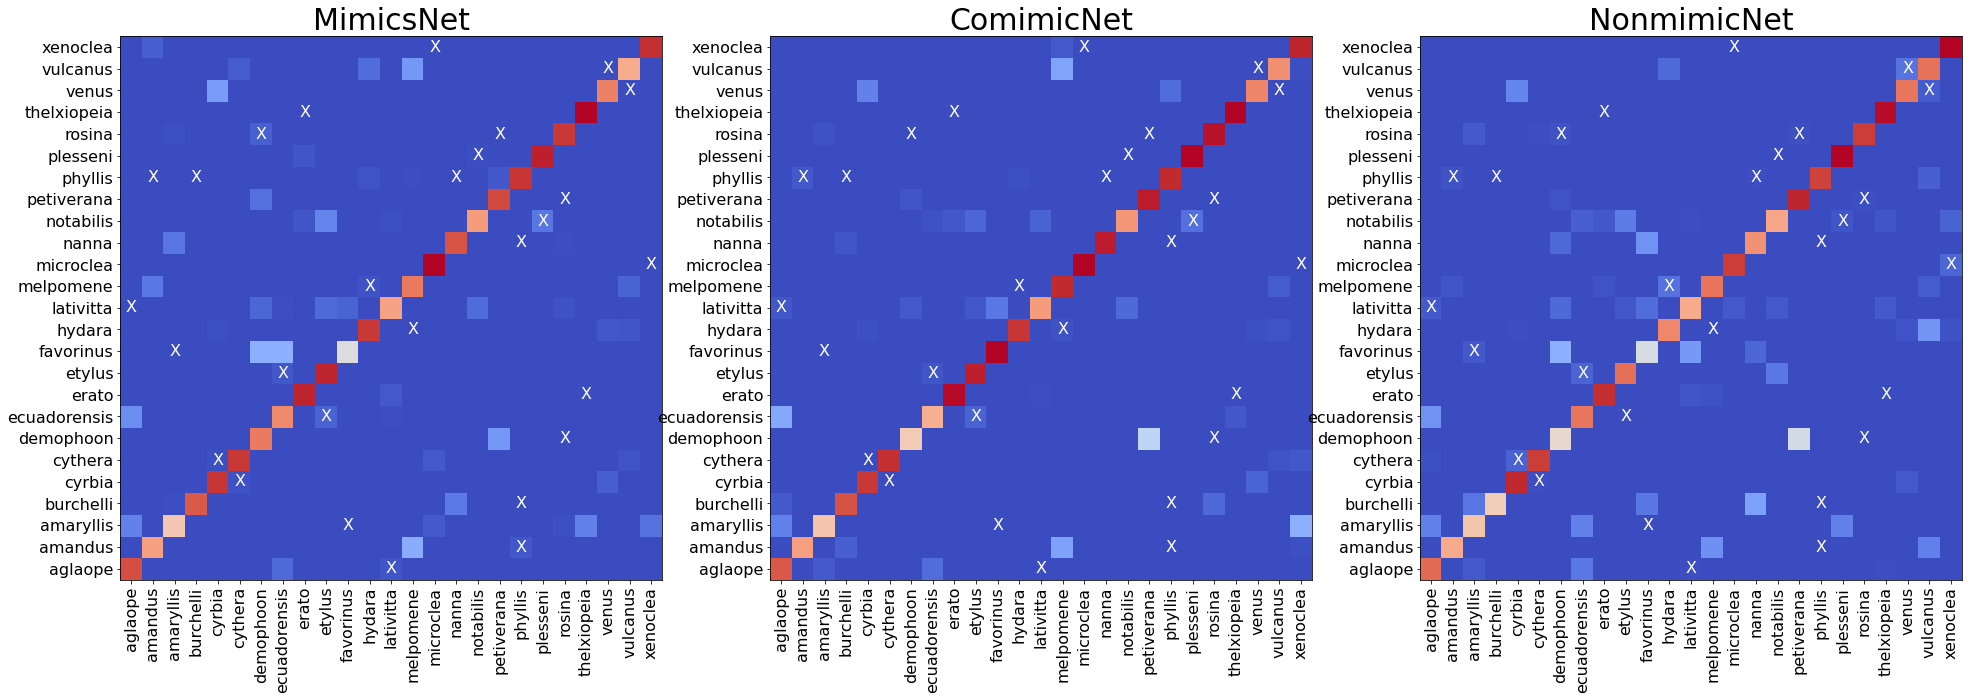

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
create_matrix(all_comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax0)
ax0.set_title('MimicsNet', fontsize=30)
create_matrix(comimics_net, data_only_comimics, labels_only_comimics, subspecies_only_comimics, ax=ax1)
ax1.set_title('ComimicNet', fontsize=30)
create_matrix(nonmimics_net, data_only_comimics, labels_only_comimics,subspecies_only_comimics, ax=ax2)
ax2.set_title('NonmimicNet', fontsize=30)

['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']


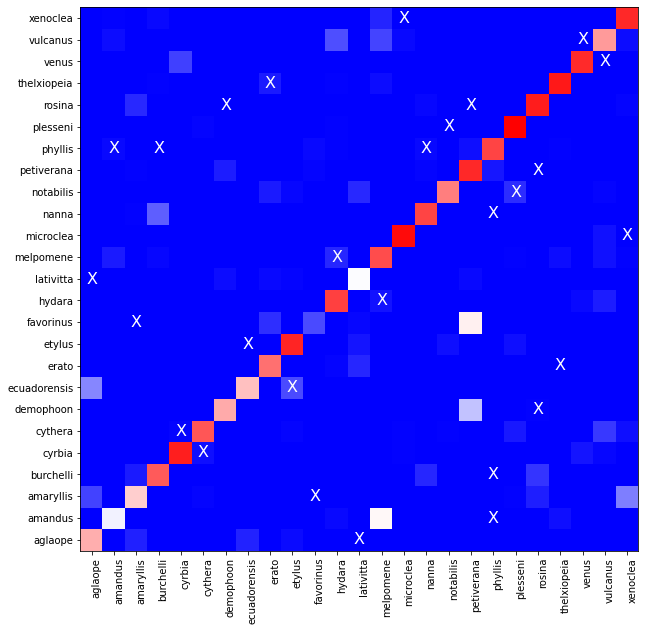

In [ ]:
create_matrix(data_orig, labels_orig, subspecies_orig, regular_net)

['aglaope', 'amandus', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']


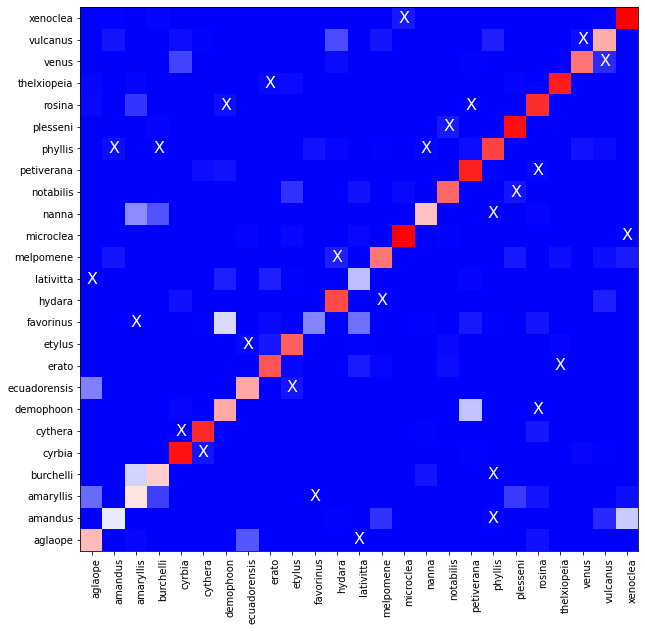

In [ ]:
create_matrix(data_orig, labels_orig, subspecies_orig, triplet_net)

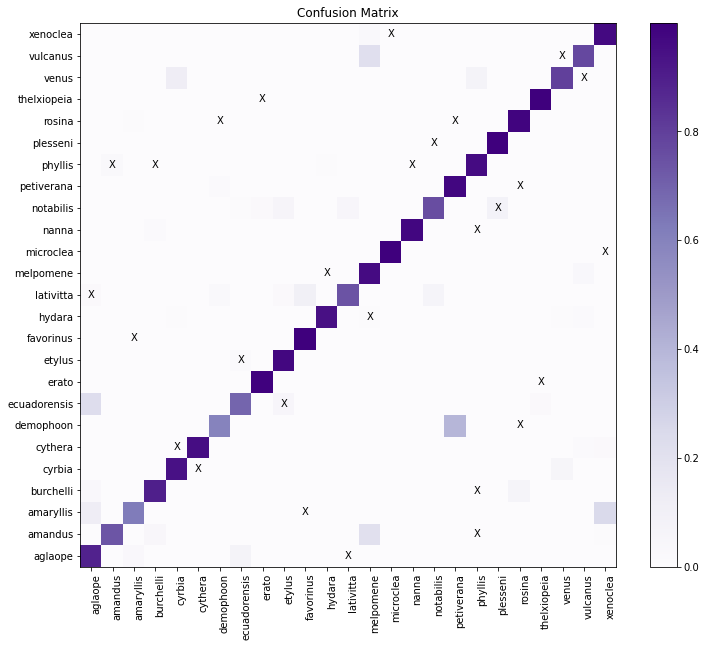

In [ ]:
create_matrix(data_only_comimics, labels_only_comimics, subspecies_only_comimics, comimics_net)

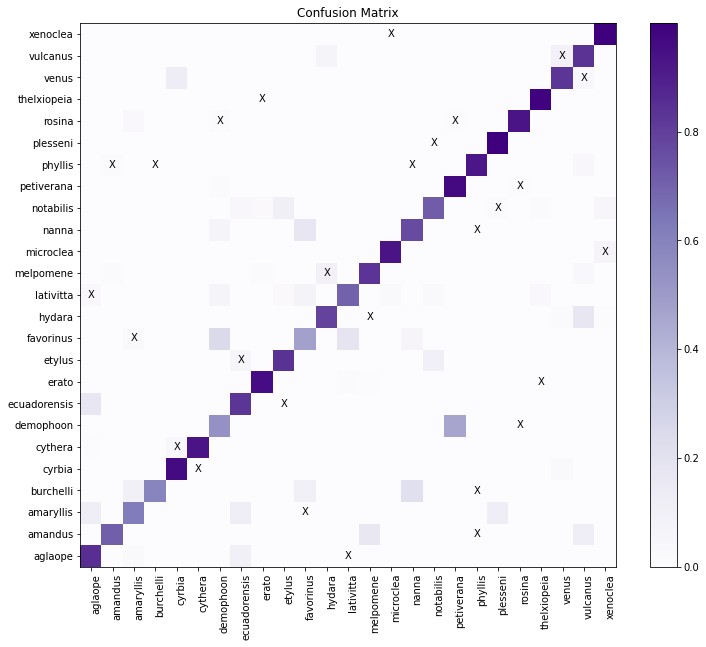

In [ ]:
create_matrix(data_only_comimics, labels_only_comimics, subspecies_only_comimics, nonmimics_net)

## Excluding Hybrids

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis Materials/data_ordered.csv").iloc[1500:].reset_index(drop=True)
nonhybrids = data[data['Subspecies'].isin(comimics_subspecies)].reset_index(drop=True)
nonhybrids = nonhybrids[nonhybrids['Hybrid status of additional taxonomic information'] != 'hybrid'].reset_index(drop=True)
data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids = load_data(nonhybrids, 1, 4)

In [ ]:
nonhybrids_numbered = all_numbered[all_numbered['Hybrid status of additional taxonomic information'] != 'hybrid'].reset_index(drop=True)
nonhybrids_numbered = nonhybrids_numbered[nonhybrids_numbered['Subspecies'] != 'dignus'].reset_index(drop=True)

In [ ]:
nonhybrids_erato = nonhybrids_numbered[nonhybrids_numbered['Species'] == 'erato'].reset_index(drop=True)
nonhybrids_melpomene = nonhybrids_numbered[nonhybrids_numbered['Species'] == 'melpomene'].reset_index(drop=True)

In [ ]:
NUM_LABELS = 12
erato_net_hybrids = Net().cuda()
erato_net_hybrids.load_state_dict(torch.load("erato.pth"))

In [ ]:
NUM_LABELS = 12
melpomene_net_hybrids = Net().cuda()
melpomene_net_hybrids.load_state_dict(torch.load("melpomene.pth"))

In [ ]:
NUM_LABELS = 12
mimicry_labels_net_hybrids = Net().cuda()
mimicry_labels_net_hybrids.load_state_dict(torch.load("all.pth"))

In [ ]:
# NUM_LABELS = 25
# regular_net_hybrids = Net().cuda()
# regular_net_hybrids.load_state_dict(torch.load("normal.pth"))

In [ ]:
NUM_LABELS = 24
triplet_net_hybrids = Net().cuda()
triplet_net_hybrids.load_state_dict(torch.load("same.pth"))

In [ ]:
NUM_LABELS = 24
comimics_net_hybrids = Net().cuda()
comimics_net_hybrids.load_state_dict(torch.load("comimics.pth"))

In [ ]:
NUM_LABELS = 24
nonmimics_net_hybrids = Net().cuda()
nonmimics_net_hybrids.load_state_dict(torch.load("nonmimic.pth"))

In [ ]:
NUM_LABELS = 24
all_comimics_net_hybrids = Net().cuda()
all_comimics_net_hybrids.load_state_dict(torch.load("all_comimics.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
NUM_LABELS = 24
hard_negatives_net_hybrids = Net().cuda()
hard_negatives_net_hybrids.load_state_dict(torch.load("hard_negatives.pth"))

In [ ]:
# data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids = load_data(nonhybrids, 1, 4)
data_nonhybrids_only_comimics, labels_nonhybrids_only_comimics, subspecies_nonhybrids_only_comimics = load_data(nonhybrids_numbered, 1, 4)
data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic = load_data(nonhybrids_numbered, 1, 13)
data_nonhybrids_erato, labels_nonhybrids_erato, subspecies_nonhybrids_erato = load_data(nonhybrids_erato, 1, 13)
data_nonhybrids_melpomene, labels_nonhybrids_melpomene, subspecies_nonhybrids_melpomene = load_data(nonhybrids_melpomene, 1, 13)

In [ ]:
negative_data = nonhybrids.copy()
negative_labels = LE.fit_transform(negative_data['Subspecies'])
negative_data['Label'] = negative_labels
test_dataset_nonhybrids = CustomImageDataset(negative_data)
test_loader_nonhybrids = torch.utils.data.DataLoader(test_dataset_nonhybrids, batch_size=100, shuffle=False, **kwargs)

In [ ]:
get_accuracy_negatives(test_loader_nonhybrids, hard_negatives_net_hybrids, negative_data)

(0.919047619047619, 0.9161290322580645)

In [ ]:
# get_accuracy(data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, regular_net_hybrids, nonhybrids)[0]

In [ ]:
get_accuracy(data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, triplet_net_hybrids, nonhybrids)[0]

0.9444444444444444

In [ ]:
get_accuracy(data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, comimics_net_hybrids, nonhybrids)[0]

0.9349206349206349

In [ ]:
get_accuracy(data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, nonmimics_net_hybrids, nonhybrids)[0]

0.9492063492063492

In [ ]:
get_accuracy(data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic, erato_net_hybrids, nonhybrids_numbered)[0]

0.895330112721417

In [ ]:
get_accuracy(data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic, melpomene_net_hybrids, nonhybrids_numbered)[0]

0.7954911433172303

In [ ]:
get_accuracy(data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic, mimicry_labels_net_hybrids, nonhybrids_numbered)[0]

0.9371980676328503

In [ ]:
get_accuracy(data_nonhybrids_erato, labels_nonhybrids_erato, subspecies_nonhybrids_erato, erato_net_hybrids, nonhybrids_erato)[0]

0.9494949494949495

In [ ]:
get_accuracy(data_nonhybrids_melpomene, labels_nonhybrids_melpomene, subspecies_nonhybrids_melpomene, erato_net_hybrids, nonhybrids_melpomene)[0]

0.8

In [ ]:
get_accuracy(data_nonhybrids_melpomene, labels_nonhybrids_melpomene, subspecies_nonhybrids_melpomene, melpomene_net_hybrids, nonhybrids_melpomene)[0]

0.9111111111111111

In [ ]:
get_accuracy(data_nonhybrids_erato, labels_nonhybrids_erato, subspecies_nonhybrids_erato, melpomene_net_hybrids, nonhybrids_erato)[0]

0.7297979797979798

In [ ]:
get_accuracy(data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, all_comimics_net_hybrids, nonhybrids)[0]

0.9142857142857143

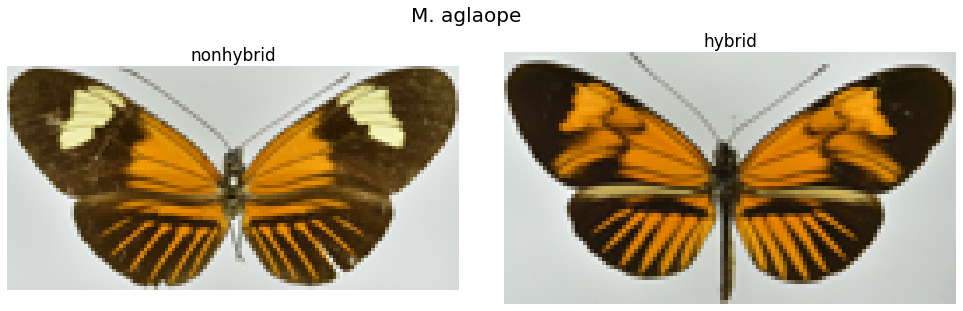

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
ax0.imshow(Image.open("/content/drive/My Drive/Butterflies_Shared/LowResolution/"+nonhybrids.iloc[0,1]))
ax0.axis('off')
fig.suptitle('M. aglaope', size=20)
ax0.set_title('nonhybrid', fontsize=17)
ax1.imshow(Image.open("/content/drive/My Drive/Butterflies_Shared/LowResolution/"+data.iloc[723,1]))
ax1.axis('off')
ax1.set_title('hybrid', fontsize=17)
fig.subplots_adjust(wspace=0.1, hspace=0)

In [ ]:
data[(data['Hybrid status of additional taxonomic information'] == 'hybrid') & (data['Subspecies'] == 'aglaope')]

NHM specimen number         Image filename     View    Species  \
170             10428280  10428280_V_lowres.tif  ventral  melpomene   
539             10428113  10428113_V_lowres.tif  ventral  melpomene   
663             10428111  10428111_V_lowres.tif  ventral  melpomene   
723             10428112  10428112_D_lowres.tif   dorsal  melpomene   
806             10428123  10428123_D_lowres.tif   dorsal  melpomene   

    Subspecies     Sex  \
170    aglaope    male   
539    aglaope  female   
663    aglaope    male   
723    aglaope    male   
806    aglaope  female   

    Additional taxonomic information (from specimen labels) Type Status  \
170                           xenoclea_x_cognatus_hyb.              NaN   
539                                  f._rubescens_hyb.              NaN   
663                                  f._rubescens_hyb.               HT   
723                                  f._rubescens_hyb.              NaN   
806                                     riffarthi_hyb.               ST   

    Hybrid status of additional taxonomic information  \
170                                            hybrid   
539                                            hybrid   
663                                            hybrid   
723                                            hybrid   
806                                            hybrid   

     Included in reduced dataset               Locality  Locality latitude  \
170                            0  Umaripuniz Rio PER PA         -10.316667   
539                            0     Huancabamba PER PA         -10.383333   
663                            0      Chuchurras PER PA         -10.150000   
723                            0  Umaripuniz Rio PER PA         -10.316667   
806                            0     Ucayali Rio PER LO          -4.466667   

     Locality longitude  
170          -75.383333  
539          -75.550000  
663          -75.233333  
723          -75.383333  
806          -73.516667

In [ ]:
subspecies_ordered = ['M. cythera', 'M. aglaope', 'M. amaryllis', 'M. burchelli', 'M. nanna',
       'M. ecuadorensis', 'M. thelxiopeia', 'M. melpomene', 'M. xenoclea',
       'M. plesseni', 'M. rosina', 'M. N. rosina', 'M. S. rosina', 'M. vulcanus', 'E. cyrbia', 'E. lativitta',
       'E. favorinus', 'E. phyllis', 'E. etylus', 'E. erato', 'E. hydara',
       'E. microclea', 'E. notabilis', 'E. petiverana', 'E. demophoon',
       'E. venus']

In [ ]:
regular_breakdown = get_accuracy_breakdown(data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, all_comimics_net_hybrids, nonhybrids)
triplet_breakdown = get_accuracy_breakdown(data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, triplet_net_hybrids, nonhybrids)
comimics_breakdown = get_accuracy_breakdown(data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, comimics_net_hybrids, nonhybrids)
nonmimics_breakdown = get_accuracy_breakdown(data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, nonmimics_net_hybrids, nonhybrids)
# all_comimics_breakdown = get_accuracy_breakdown(data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, all_comimics_net_hybrids, nonhybrids)
erato_breakdown = get_accuracy_breakdown(data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic, erato_net_hybrids, nonhybrids_numbered)
melpomene_breakdown = get_accuracy_breakdown(data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic, melpomene_net_hybrids, nonhybrids_numbered)
mimicry_labels_breakdown = get_accuracy_breakdown(data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic, mimicry_labels_net_hybrids, nonhybrids_numbered)
hard_negatives_breakdown = get_accuracy_breakdown_negatives(test_loader_nonhybrids, hard_negatives_net_hybrids, negative_data)

In [ ]:
heatmap_data = []
all_breakdowns = [regular_breakdown, triplet_breakdown, hard_negatives_breakdown, comimics_breakdown, nonmimics_breakdown, mimicry_labels_breakdown, erato_breakdown, melpomene_breakdown]
all_breakdowns.reverse()
for breakdown in all_breakdowns : 
  ss_breakdown = []
  for ss in subspecies_ordered : 
    if ss[3:] in breakdown : 
      ss_breakdown.append(breakdown[ss[3:]])
    else : ss_breakdown.append(0)
  heatmap_data.append(ss_breakdown)

In [ ]:
for i in range(len(subspecies_ordered)) : 
  ss = subspecies_ordered[i]
  count = subspecies_nonhybrids.count(ss[3:])
  if ss[3:] == 'N. rosina' : 
    count = subspecies_nonhybrids_mimic.count(ss[3:])
  if ss[3:] == 'S. rosina' : 
    count = subspecies_nonhybrids_mimic.count(ss[3:])
  subspecies_ordered[i] = ss + ' (' + str(count) + ')'

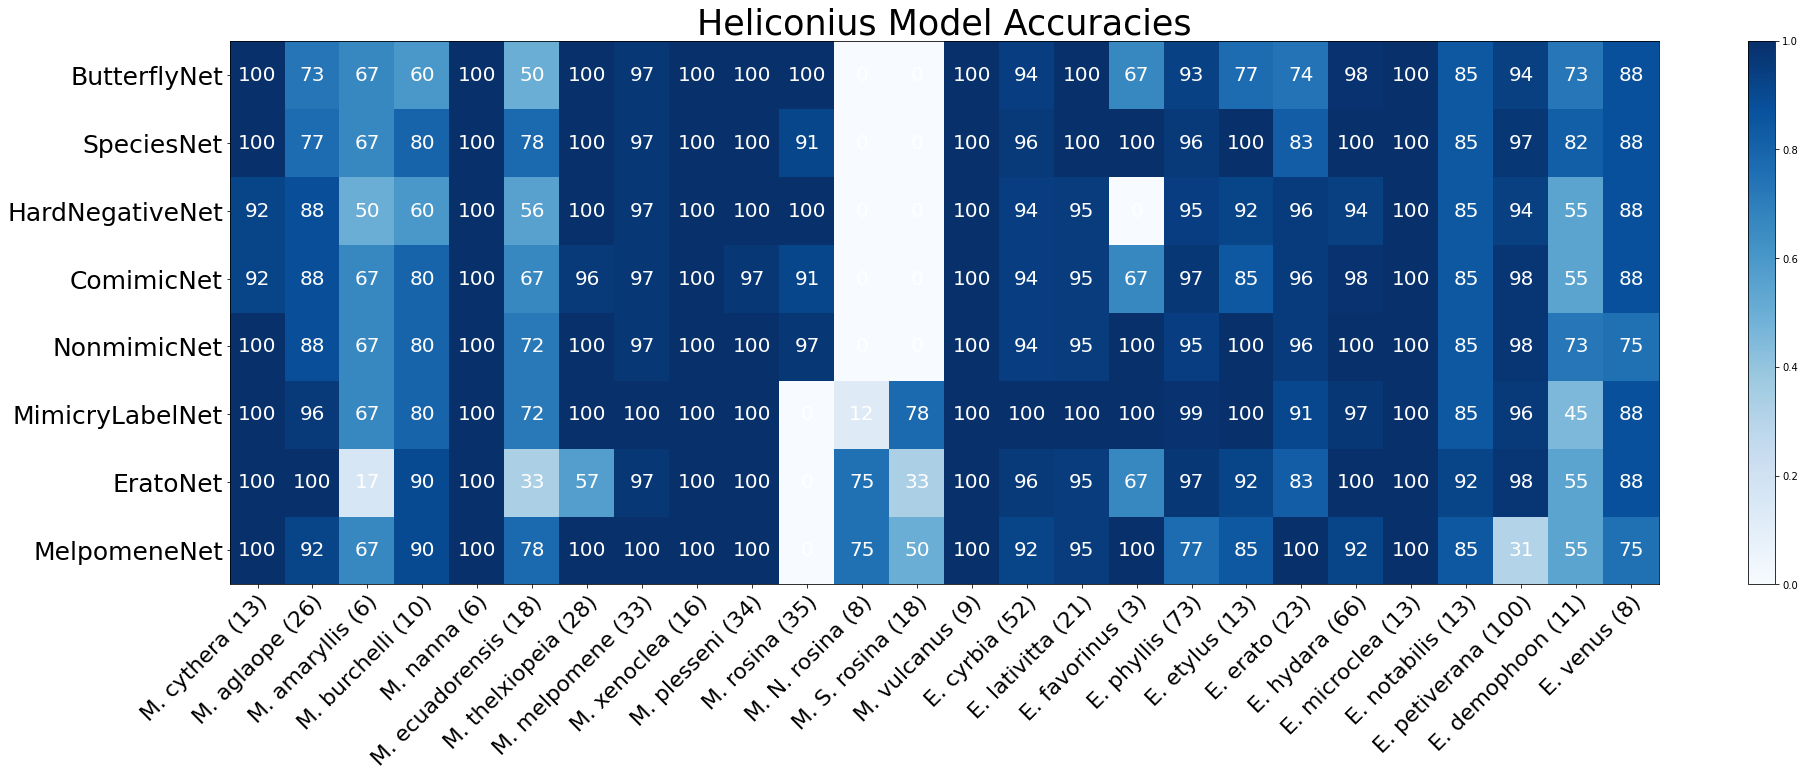

In [ ]:
fig, ax = plt.subplots(figsize=(32, 10))  
colorbar = ax.pcolormesh( heatmap_data , cmap = 'Blues' )
  
ax.set_title( 'Heliconius Model Accuracies', fontsize=35)
test = ['ButterflyNet', 'SpeciesNet','HardNegativeNet','ComimicNet', 'NonmimicNet','MimicryLabelNet', 'EratoNet', 'MelpomeneNet']
test.reverse()
ax.set_xticks(np.arange(len(subspecies_ordered))+0.5)
ax.set_xticklabels(subspecies_ordered, fontsize=22)
ax.set_yticks(np.arange(len(test))+0.5)
ax.set_yticklabels(test, fontsize=25)
labels = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(test)):
    for j in range(len(subspecies_ordered)):
        # if test[i] == 'Network trained \nwith hard negatives' : 
        #   color = 'tab:blue' 
        # else : color='w'
        text = ax.text(j+0.5, i+0.5, round(heatmap_data[i][j]*100),
                       ha="center", va="center", color='w', size=20)
plt.colorbar(colorbar)

In [ ]:
models = ['ButterflyNet', 'CladeNet', 'HardNegativesNet', 'MimicsNet','ComimicNet','NonmimicNet', 'MimicryLabelNet', 'EratoNet', 'MelpomeneNet']
descriptions = ['Hoyal-Cuthill model', 'Negative triplet selected from same species','Negative triplet selected using hard negative mining', 'Trained only on subspecies that are mimics', 'Negative triplet selected from comimic', 'Negative triplet selected from other species, but not a mimic subspecies','Trained using label for each mimicry group', 'Trained only on erato subspecies', 'Trained only on melpomene subspecies']
accuracies = ['84.8%', '83.0%','78.0%???', '90.6%','93.2%', '89.2%', '93.7%', '87.2%', '77.9%']
nonhybrid_accuracies = ['86.5%', '86.5%', '???', '93.3%', '95.7%', '91.6%', '96.3%', '94.0%', '81.1%']

In [ ]:
models = ['ButterflyNet', 'CladeNet', 'MimicsNet', 'MimicryLabelNet', 'EratoNet', 'MelpomeneNet', 'ComimicNet', 'NonMimicNet', 'HardNegativeNet']
descriptions = ['Hoyal-Cuthill model', 'Negative triplet selected from same species', 'Trained only on subspecies that are mimics','Trained using label for each mimicry group', 'Trained only on erato subspecies', 'Trained only on melpomene subspecies', 'Negative triplet selected from comimic', 'Negative triplet selected from other species, but not a mimic subspecies', 'Negative triplet selected using hard negative mining']
accuracies = ['84.8%', '83.0%','78.0%???', '90.6%','93.2%', '89.2%' '93.7%', '87.2%', '77.9%']
nonhybrid_accuracies = ['86.5%', '86.5%', '???', '93.3%', '95.7%', '91.6%', '96.3%', '94.0%', '81.1%']

In [ ]:
pd.DataFrame({'Model' : models, 'Description' : descriptions, 'Overall Accuracy' : accuracies, 'Nonhybrid Accuracy' : nonhybrid_accuracies})

Model                                        Description  \
0      ButterflyNet                                Hoyal-Cuthill model   
1          CladeNet        Negative triplet selected from same species   
2  HardNegativesNet  Negative triplet selected using hard negative ...   
3         MimicsNet         Trained only on subspecies that are mimics   
4        ComimicNet             Negative triplet selected from comimic   
5       NonmimicNet  Negative triplet selected from other species, ...   
6   MimicryLabelNet         Trained using label for each mimicry group   
7          EratoNet                   Trained only on erato subspecies   
8      MelpomeneNet               Trained only on melpomene subspecies   

  Overall Accuracy Nonhybrid Accuracy  
0            84.8%              86.5%  
1            83.0%              86.5%  
2         78.0%???                ???  
3            90.6%              93.3%  
4            93.2%              95.7%  
5            89.2%              91.6%  
6            93.7%              96.3%  
7            87.2%              94.0%  
8            77.9%              81.1%

In [ ]:
comimics_table

Melpomene       Erato
0        cythera      cyrbia
1        aglaope   lativitta
2        amandus     phyllis
3      amaryllis   favorinus
4      burchelli     phyllis
5   ecuadorensis      etylus
6    thelxiopeia       erato
7      melpomene      hydara
8       xenoclea   microclea
9          nanna     phyllis
10      plesseni   notabilis
11        rosina  petiverana
12        rosina   demophoon
13      vulcanus       venus

In [ ]:
set(data['Subspecies'].tolist()) - set(nonhybrids['Subspecies'].tolist())

{'amandus', 'amphitrite', 'dignus', 'favorinusxlativitta'}

In [ ]:
wo_hybrids = data[data['Hybrid status of additional taxonomic information'] != 'hybrid'].reset_index(drop=True)

In [ ]:
set(data['Subspecies'].tolist()) - set(wo_hybrids['Subspecies'].tolist())

{'amandus', 'amphitrite', 'favorinusxlativitta'}

In [ ]:
ss = set(nonhybrids['Subspecies'].tolist())
counts = {}
for s in ss : 
  num = len(nonhybrids[nonhybrids['Subspecies'] == s])
  counts[s] = num

In [ ]:
comimics_table

Melpomene       Erato
0        cythera      cyrbia
1        aglaope   lativitta
2        amandus     phyllis
3      amaryllis   favorinus
4      burchelli     phyllis
5   ecuadorensis      etylus
6    thelxiopeia       erato
7      melpomene      hydara
8       xenoclea   microclea
9          nanna     phyllis
10      plesseni   notabilis
11        rosina  petiverana
12        rosina   demophoon
13      vulcanus       venus

In [ ]:
counts = [(key, counts[key]) for key in counts]

In [ ]:
ss = ['aglaope', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'emma', 'erato', 'etylus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'schunkei', 'thelxiopeia', 'xenoclea']

In [ ]:
counts.sort(key=lambda x:x[1])

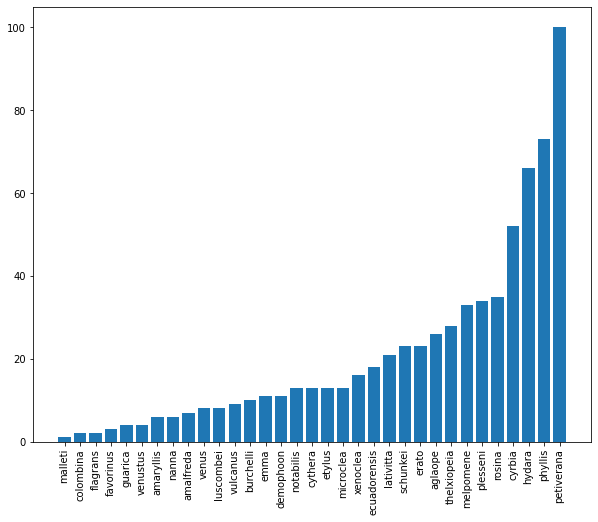

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar([elt[0] for elt in counts], [elt[1] for elt in counts])
labels = plt.setp(ax.get_xticklabels(), rotation=90)

### PCA

Text(0.5, 1.0, 'MelpomeneNet')

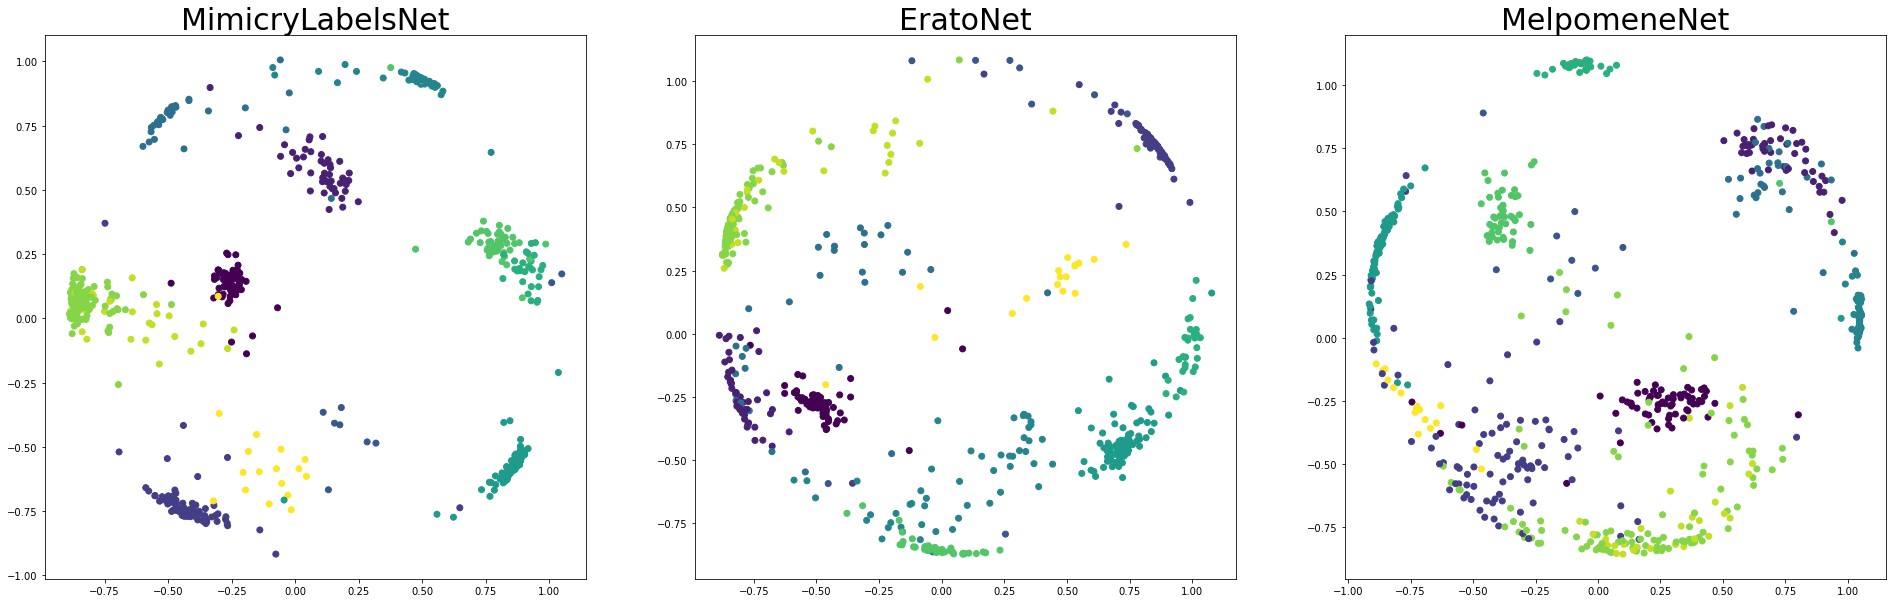

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
get_pca(mimicry_labels_net_hybrids, data_nonhybrids_mimic, labels_nonhybrids_mimic, ax=ax0)
ax0.set_title('MimicryLabelsNet', fontsize=30)
get_pca(erato_net_hybrids, data_nonhybrids_mimic, labels_nonhybrids_mimic, ax=ax1)
ax1.set_title('EratoNet', fontsize=30)
get_pca(melpomene_net_hybrids, data_nonhybrids_mimic, labels_nonhybrids_mimic, ax=ax2)
ax2.set_title('MelpomeneNet', fontsize=30)

Text(0.5, 1.0, 'NonmimicNet')

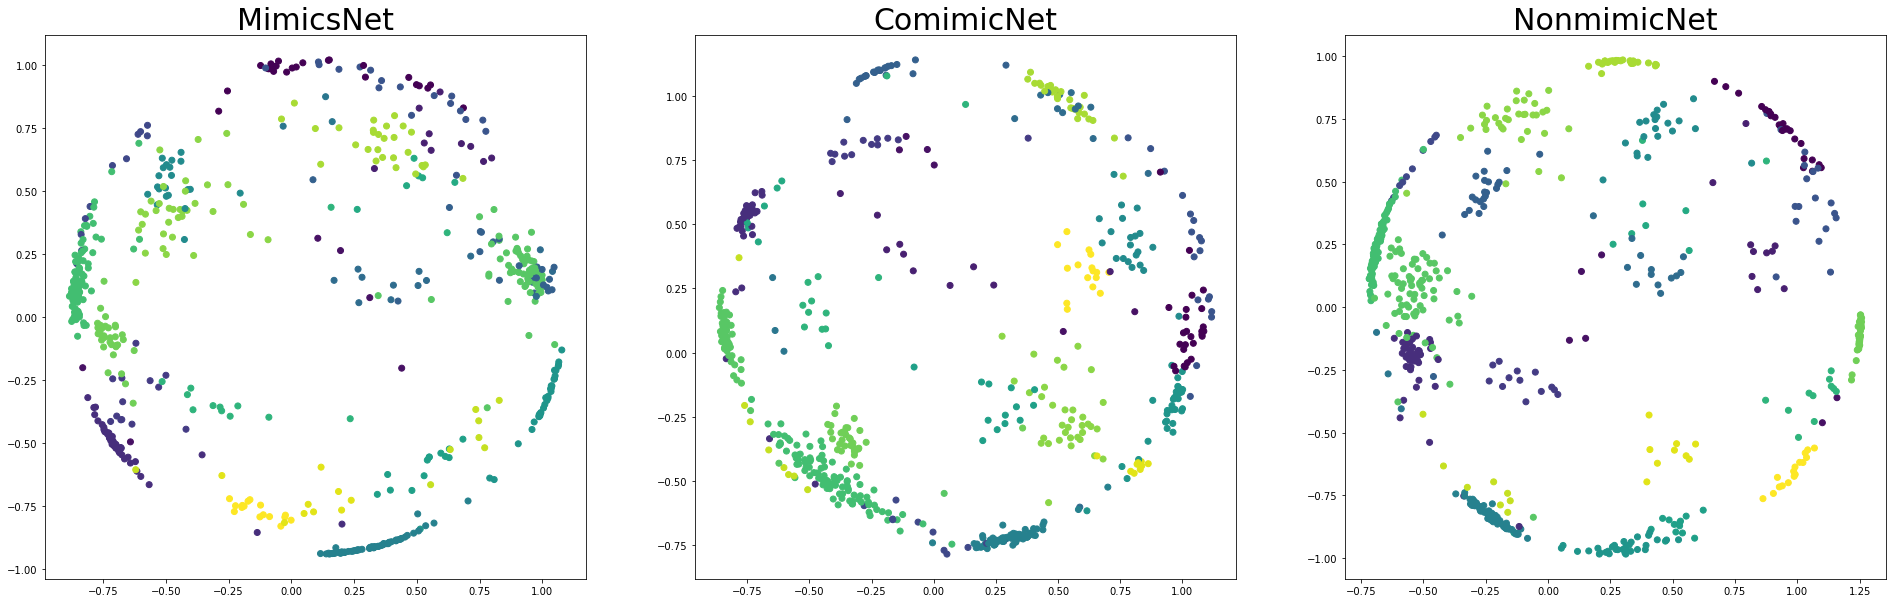

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
get_pca(all_comimics_net_hybrids, data_nonhybrids, labels_nonhybrids, ax=ax0)
ax0.set_title('MimicsNet', fontsize=30)
get_pca(comimics_net_hybrids, data_nonhybrids, labels_nonhybrids, ax=ax1)
ax1.set_title('ComimicNet', fontsize=30)
get_pca(nonmimics_net_hybrids, data_nonhybrids, labels_nonhybrids, ax=ax2)
ax2.set_title('NonmimicNet', fontsize=30)

Text(0.5, 1.0, 'HardNegativeNet')

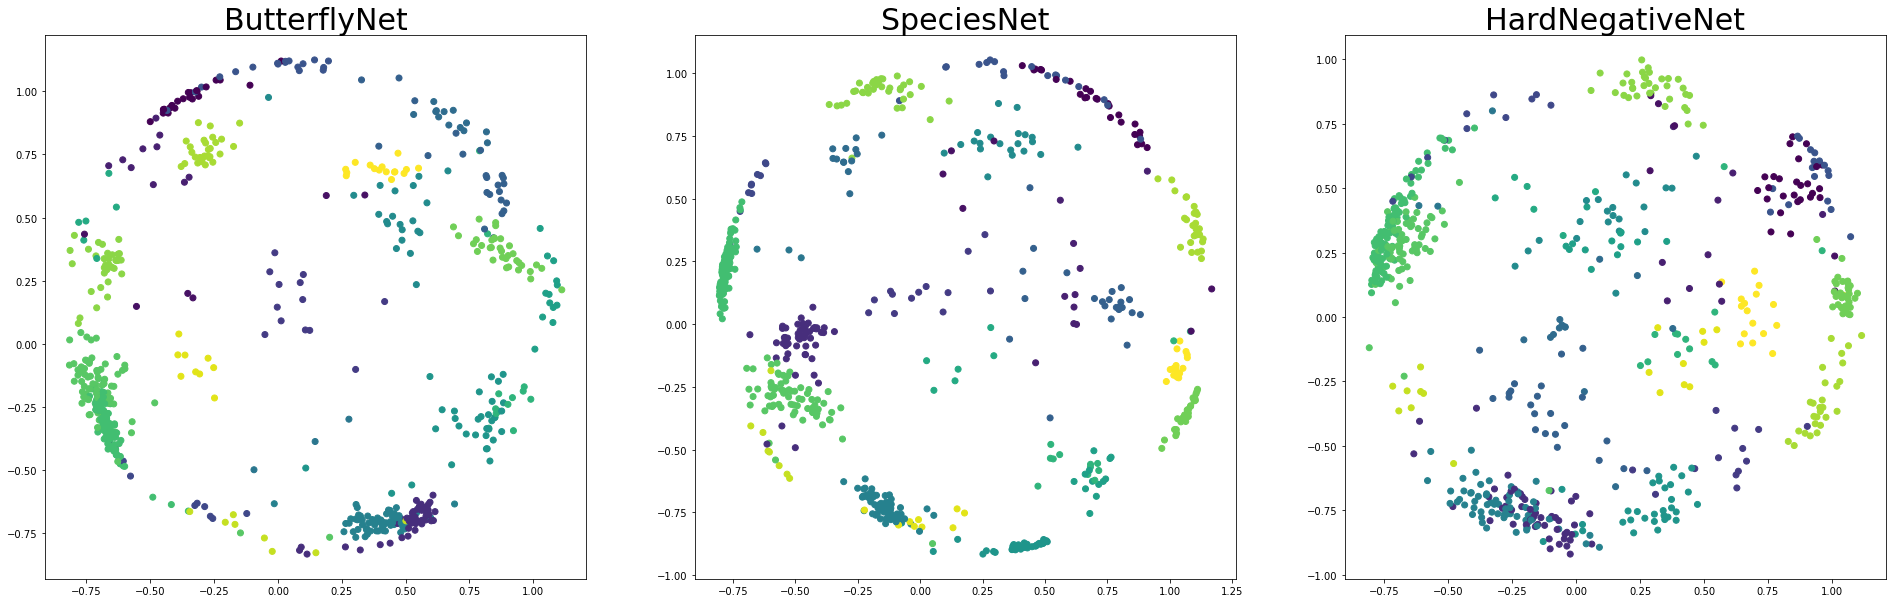

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
get_pca(regular_net_hybrids, data_nonhybrids, labels_nonhybrids, ax=ax0)
ax0.set_title('ButterflyNet', fontsize=30)
get_pca(triplet_net_hybrids, data_nonhybrids, labels_nonhybrids, ax=ax1)
ax1.set_title('SpeciesNet', fontsize=30)
get_pca(hard_negatives_net_hybrids, test_loader_nonhybrids, None, ax=ax2, negative=True)
ax2.set_title('HardNegativeNet', fontsize=30)

### Confusion Matrices

['aglaope', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']
['aglaope', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']


Text(0.5, 1.0, 'NonmimicNet')

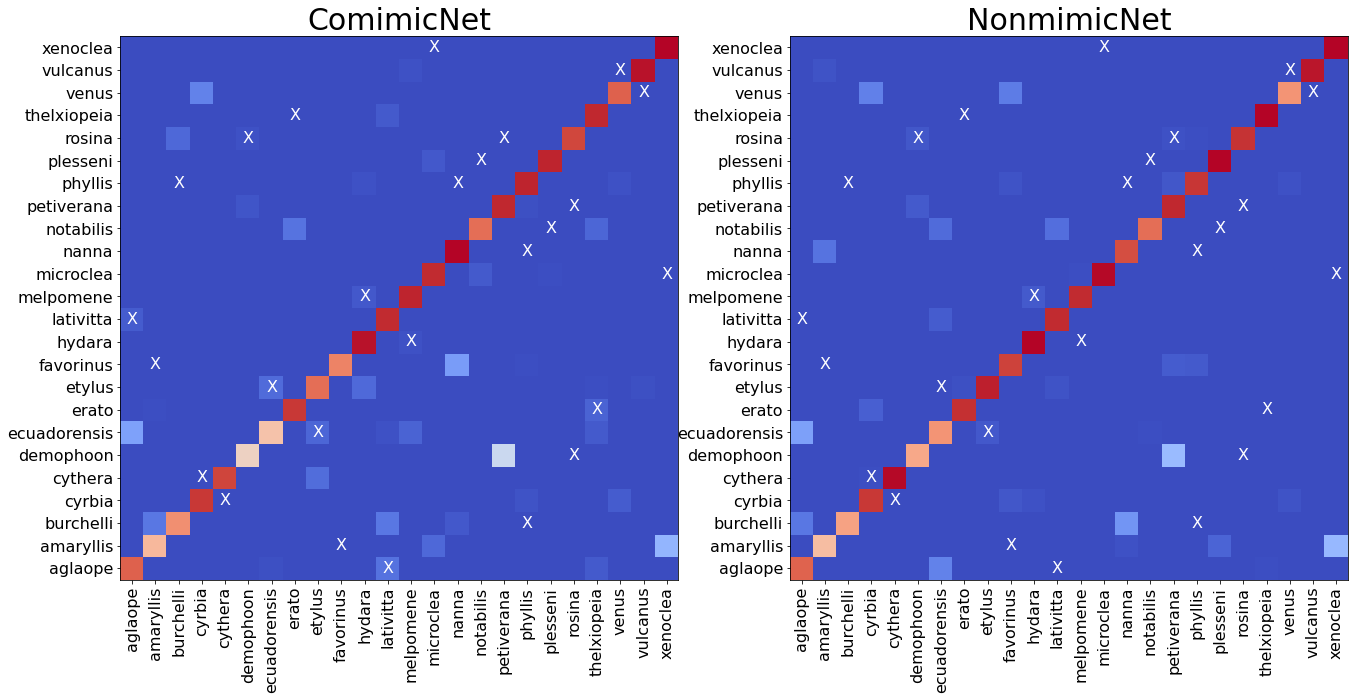

In [ ]:
# comimics_subspecies.remove('amandus')
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
# create_matrix(all_comimics_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax0)
# ax0.set_title('MimicsNet', fontsize=30)
create_matrix(comimics_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax0)
ax0.set_title('ComimicNet', fontsize=30)
create_matrix(nonmimics_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax1)
ax1.set_title('NonmimicNet', fontsize=30)

['aglaope', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']
['aglaope', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']
['aglaope', 'amaryllis', 'burchelli', 'cyrbia', 'cythera', 'demophoon', 'ecuadorensis', 'erato', 'etylus', 'favorinus', 'hydara', 'lativitta', 'melpomene', 'microclea', 'nanna', 'notabilis', 'petiverana', 'phyllis', 'plesseni', 'rosina', 'thelxiopeia', 'venus', 'vulcanus', 'xenoclea']


Text(0.5, 1.0, 'HardNegativeNet')

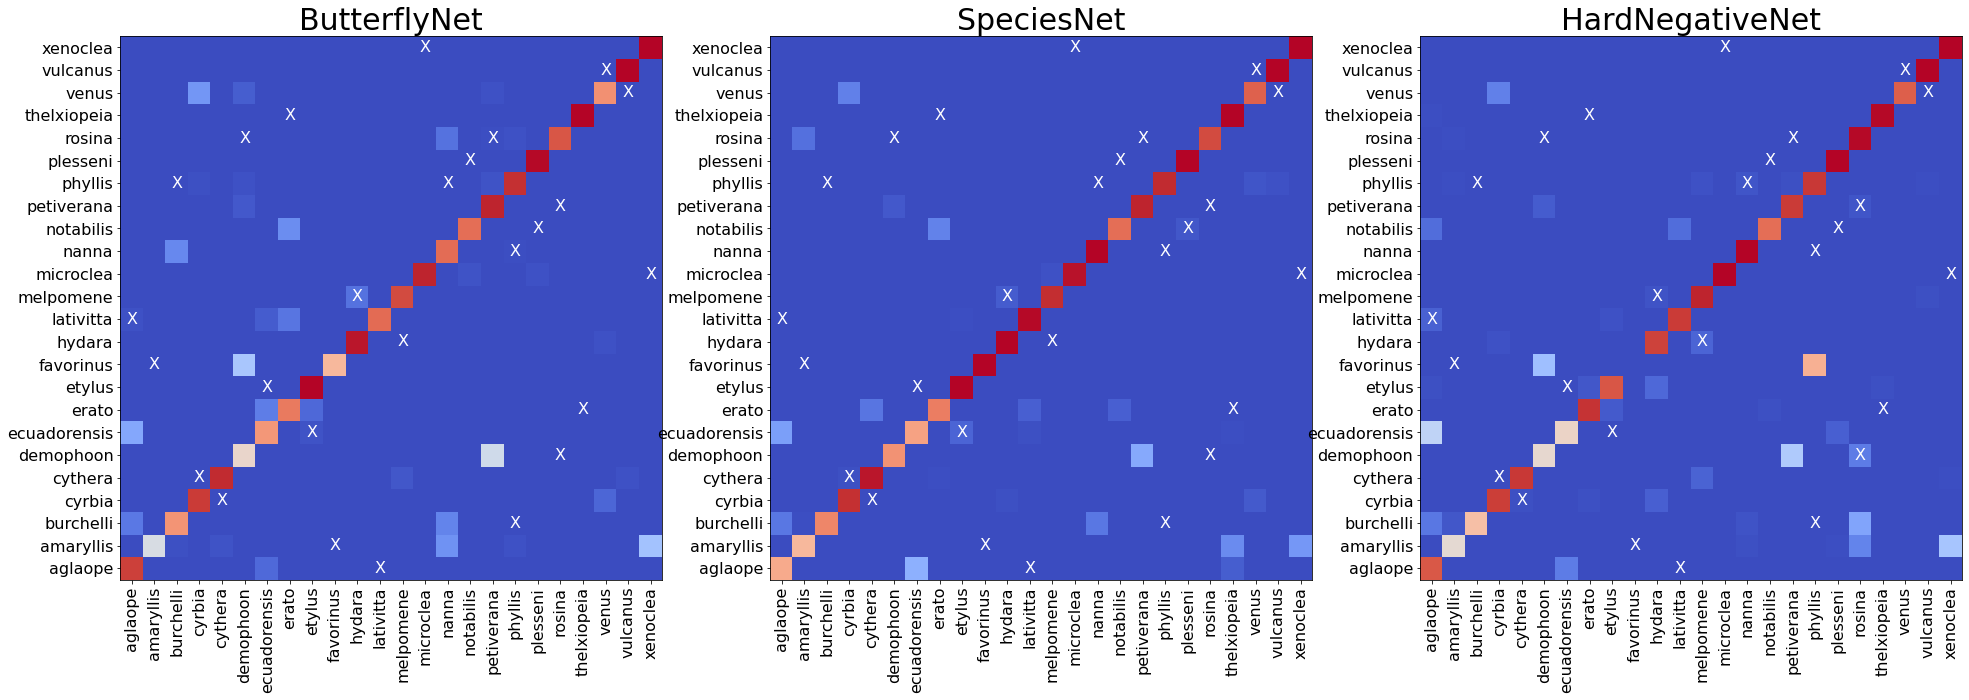

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 10))
create_matrix(regular_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax0)
ax0.set_title('ButterflyNet', fontsize=30)
create_matrix(triplet_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax1)
ax1.set_title('SpeciesNet', fontsize=30)
create_matrix(hard_negatives_net_hybrids, negative_data, negative_data['Label'].tolist(), negative_data['Subspecies'].tolist(), negative=test_loader_nonhybrids, ax = ax2)
ax2.set_title('HardNegativeNet', fontsize=30)

### Embedding Distances

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'NonmimicNet')

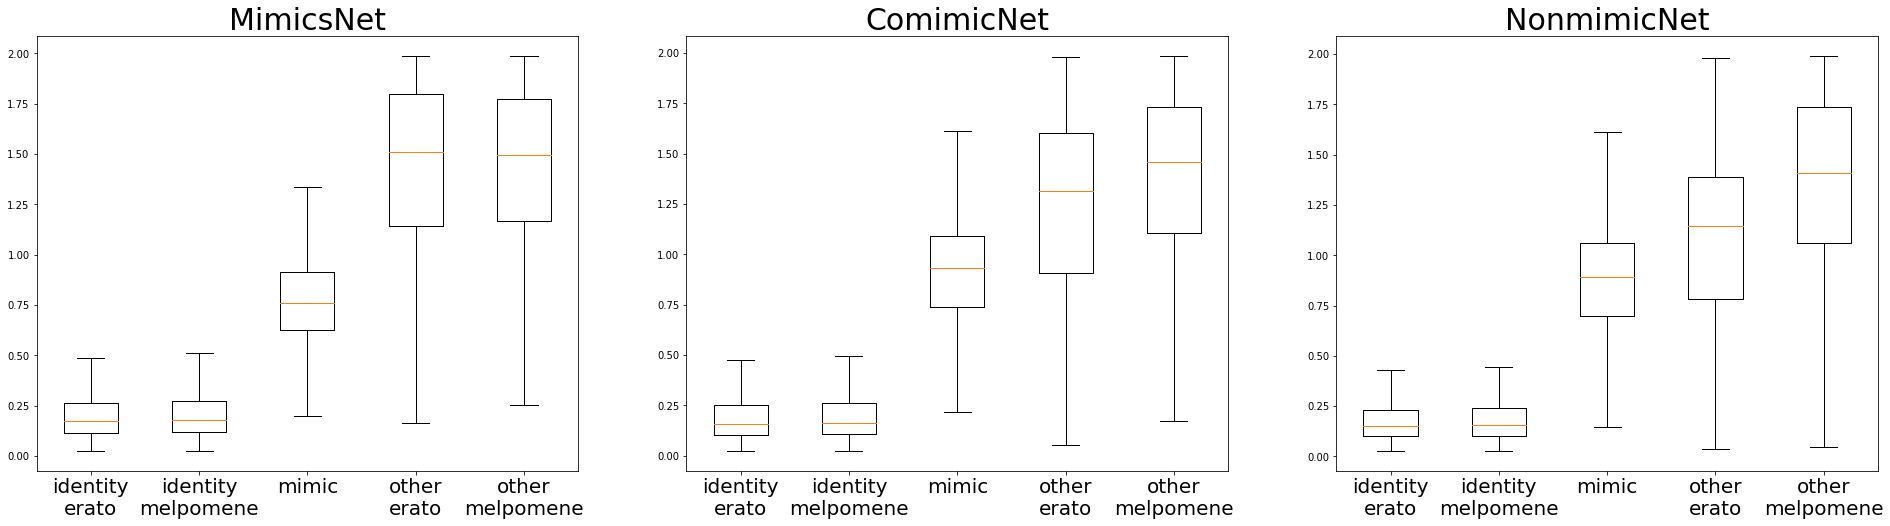

In [ ]:
# with correct and incorrect embeddings
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(all_comimics_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax0)
ax0.set_title('MimicsNet', fontsize=30)
get_boxplot_separate(comimics_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax1)
ax1.set_title('ComimicNet', fontsize=30)
get_boxplot_separate(nonmimics_net_hybrids, data_nonhybrids, labels_nonhybrids,subspecies_nonhybrids, ax=ax2)
ax2.set_title('NonmimicNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'NonmimicNet')

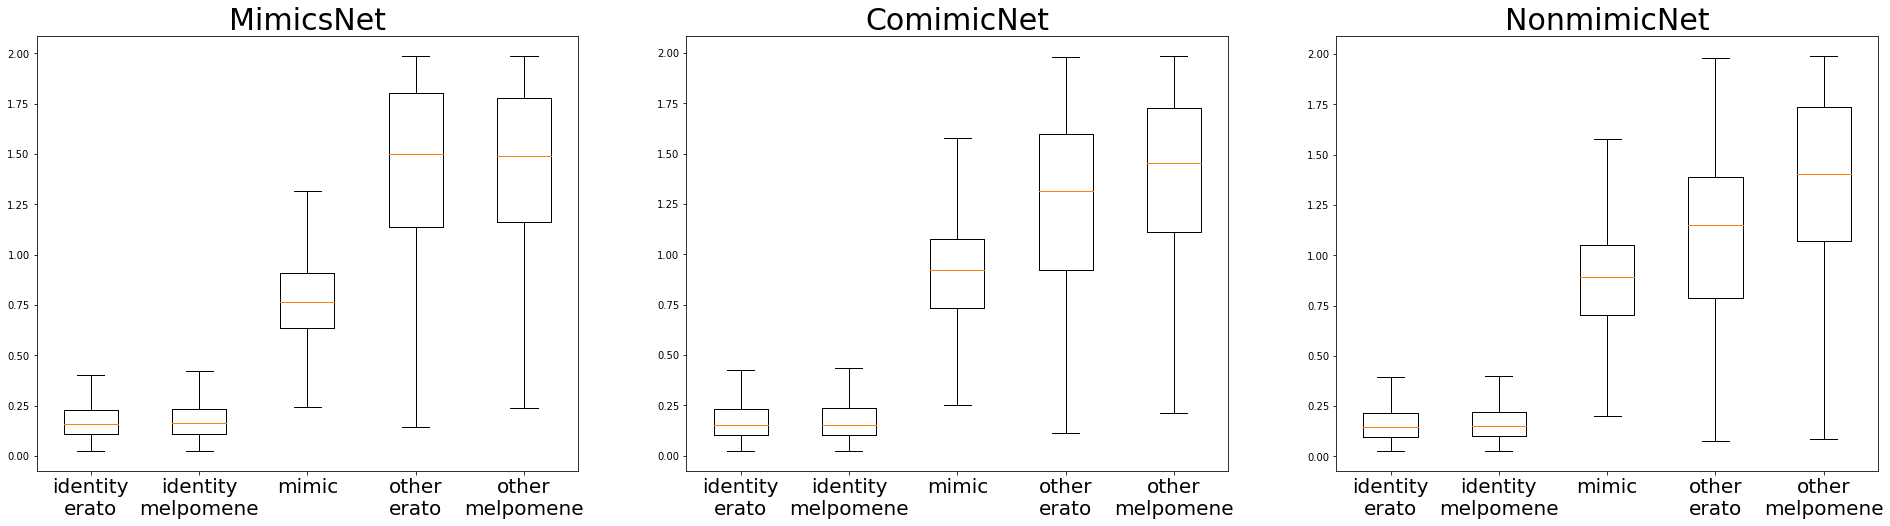

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(all_comimics_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax0)
ax0.set_title('MimicsNet', fontsize=30)
get_boxplot_separate(comimics_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax1)
ax1.set_title('ComimicNet', fontsize=30)
get_boxplot_separate(nonmimics_net_hybrids, data_nonhybrids, labels_nonhybrids,subspecies_nonhybrids, ax=ax2)
ax2.set_title('NonmimicNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'MelpomeneNet')

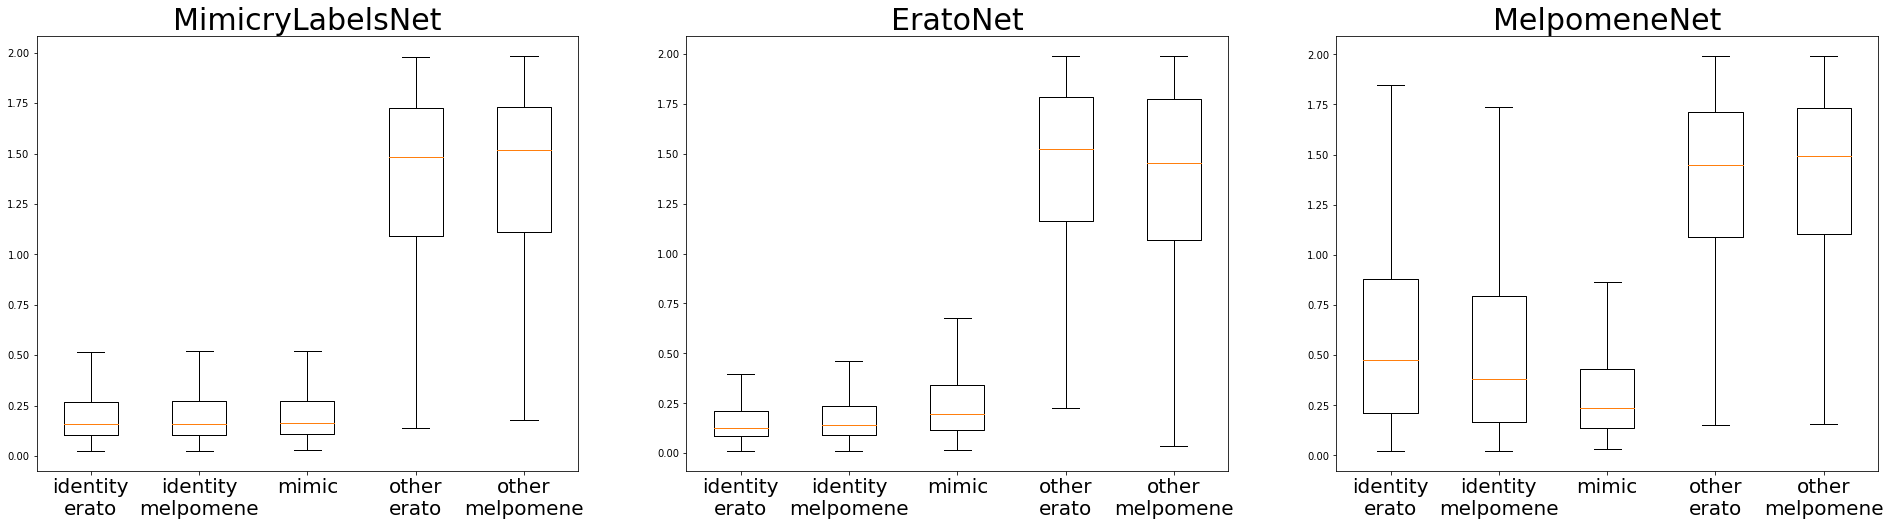

In [ ]:
# with and without incorrect embeddings
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(mimicry_labels_net_hybrids, data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic, ax=ax0)
ax0.set_title('MimicryLabelsNet', fontsize=30)
get_boxplot_separate(erato_net_hybrids, data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic, ax=ax1)
ax1.set_title('EratoNet', fontsize=30)
get_boxplot_separate(melpomene_net_hybrids, data_nonhybrids_mimic, labels_nonhybrids_mimic ,subspecies_nonhybrids_mimic, ax=ax2)
ax2.set_title('MelpomeneNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'MelpomeneNet')

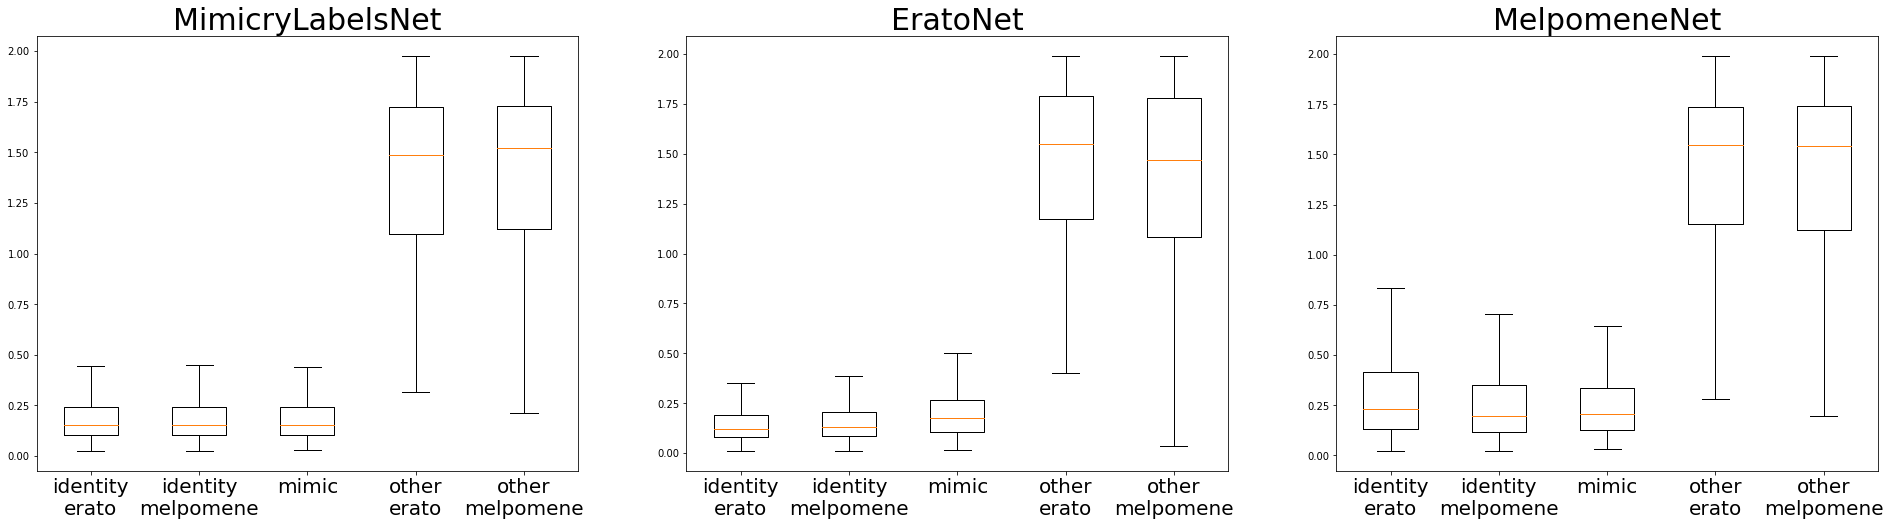

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(mimicry_labels_net_hybrids, data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic, ax=ax0)
ax0.set_title('MimicryLabelsNet', fontsize=30)
get_boxplot_separate(erato_net_hybrids, data_nonhybrids_mimic, labels_nonhybrids_mimic, subspecies_nonhybrids_mimic, ax=ax1)
ax1.set_title('EratoNet', fontsize=30)
get_boxplot_separate(melpomene_net_hybrids, data_nonhybrids_mimic, labels_nonhybrids_mimic ,subspecies_nonhybrids_mimic, ax=ax2)
ax2.set_title('MelpomeneNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'HardNegativesNet')

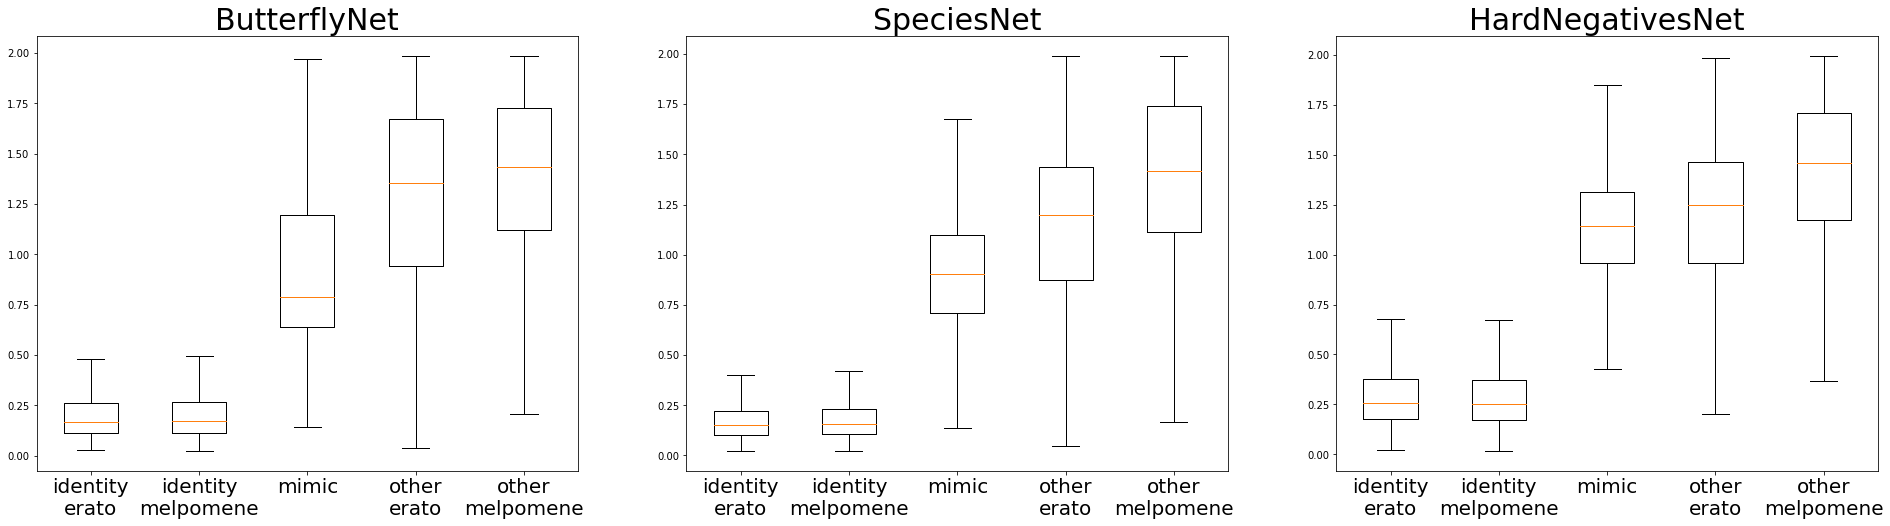

In [ ]:
# with and without incorrect embeddings 
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(regular_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax0)
get_boxplot_separate(triplet_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax1)
ax0.set_title('ButterflyNet', fontsize=30)
ax1.set_title('SpeciesNet', fontsize=30)
get_boxplot_separate(hard_negatives_net_hybrids, negative_data, test_loader_nonhybrids, None, ax=ax2, negative=True)
ax2.set_title('HardNegativesNet', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'HardNegativesNet')

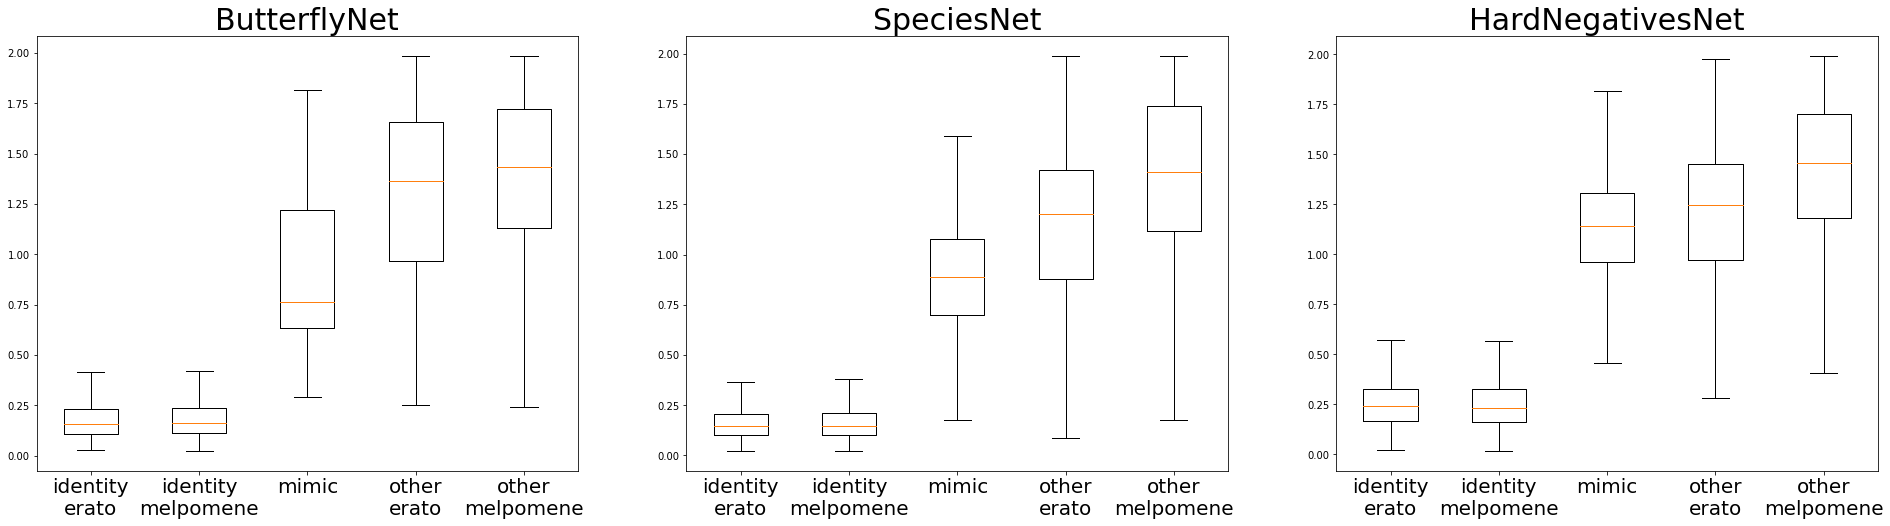

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(regular_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax0)
get_boxplot_separate(triplet_net_hybrids, data_nonhybrids, labels_nonhybrids, subspecies_nonhybrids, ax=ax1)
ax0.set_title('ButterflyNet', fontsize=30)
ax1.set_title('SpeciesNet', fontsize=30)
get_boxplot_separate(hard_negatives_net_hybrids, negative_data, test_loader_nonhybrids, None, ax=ax2, negative=True)
ax2.set_title('HardNegativesNet', fontsize=30)

In [ ]:
# wilcoxan or t-test

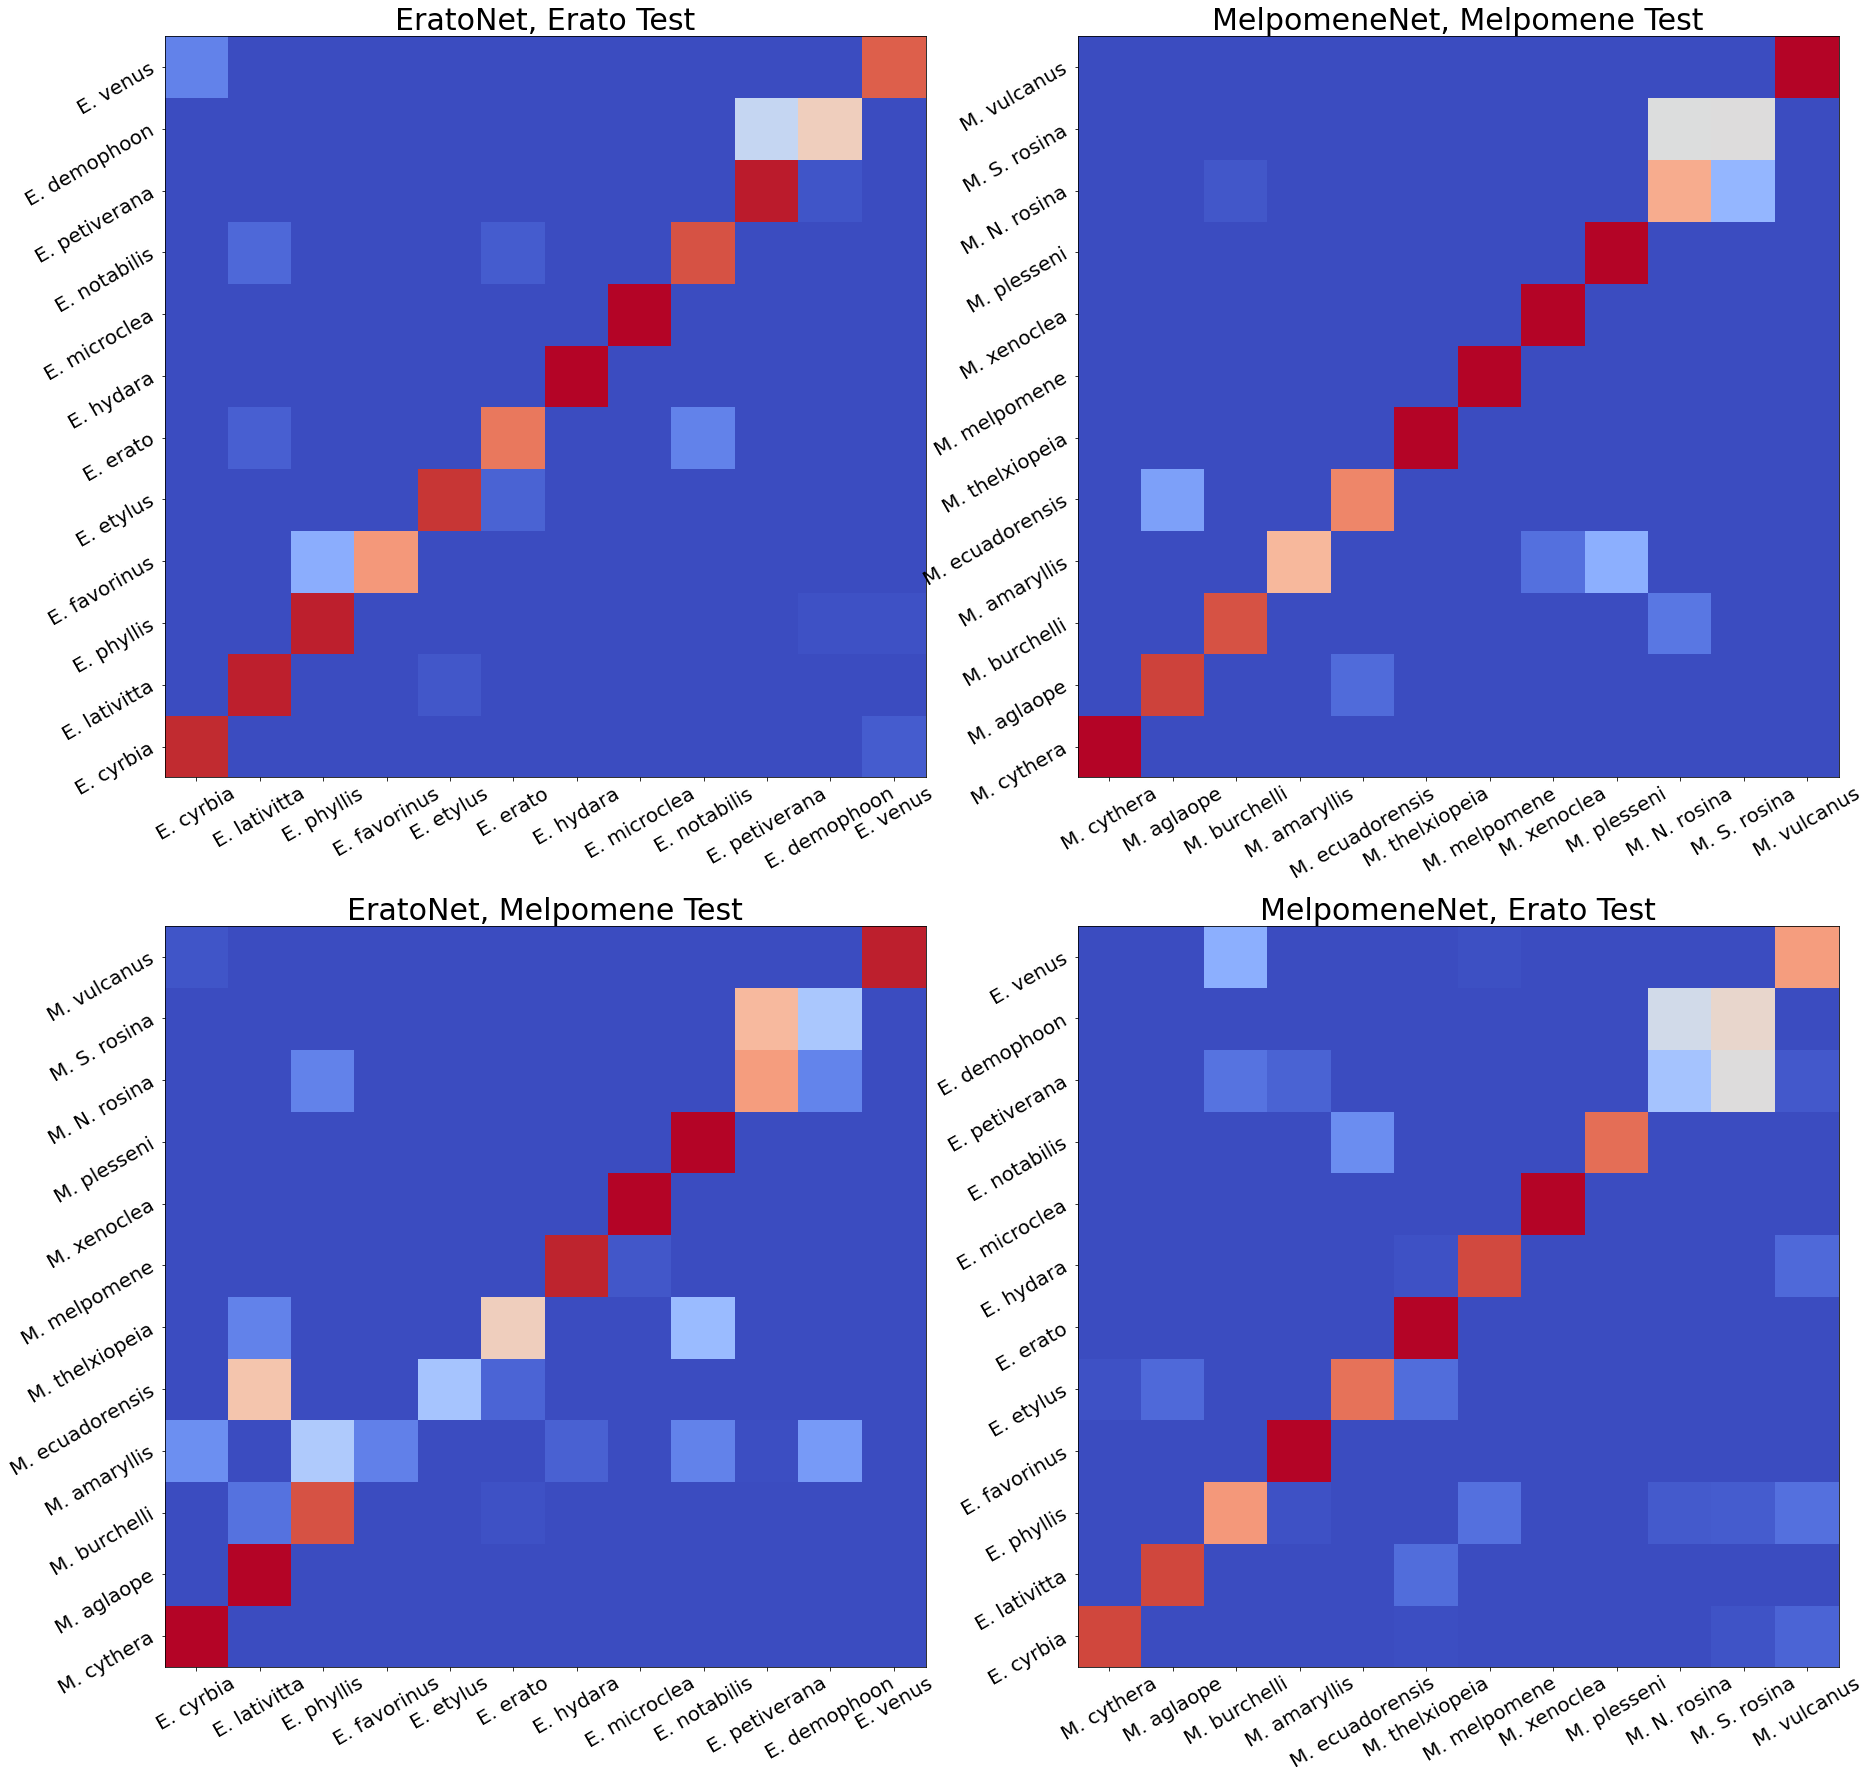

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
create_matrix_labels(erato_net_hybrids, data_nonhybrids_erato, labels_nonhybrids_erato, subspecies_nonhybrids_erato, ordered_e, ordered_e, ax=axs[0,0], title='EratoNet, Erato Test')
create_matrix_labels(melpomene_net_hybrids, data_nonhybrids_melpomene, labels_nonhybrids_melpomene, subspecies_nonhybrids_melpomene, ordered_m, ordered_m, ax=axs[0,1], title='MelpomeneNet, Melpomene Test')
create_matrix_labels(erato_net_hybrids, data_nonhybrids_melpomene, labels_nonhybrids_melpomene, subspecies_nonhybrids_melpomene, ordered_e, ordered_m, ax=axs[1,0], title='EratoNet, Melpomene Test')
create_matrix_labels(melpomene_net_hybrids, data_nonhybrids_erato, labels_nonhybrids_erato, subspecies_nonhybrids_erato, ordered_m, ordered_e, ax=axs[1,1], title='MelpomeneNet, Erato Test')

In [ ]:
ordered_m = {subspecies_nonhybrids_melpomene[i] : labels_nonhybrids_melpomene[i] for i in range(len(labels_nonhybrids_melpomene)) if subspecies_nonhybrids_melpomene[i] != 'nanna'}
ordered_m = [(ordered_m[key], key) for key in ordered_m]
ordered_m.sort(key = lambda x :x[0] )
ordered_m = ['M. ' + elt[1] for elt in ordered_m]

ordered_e = {subspecies_nonhybrids_erato[i] : labels_nonhybrids_erato[i] for i in range(len(labels_nonhybrids_erato))}
ordered_e = [(ordered_e[key], key) for key in ordered_e]
ordered_e.sort(key = lambda x :x[0] )
ordered_e = ['E. ' + elt[1] for elt in ordered_e]

# Acuity Analysis

In [ ]:
class AcuityEmbed(nn.Module):
    def __init__(self):
        super(AcuityEmbed,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,9,padding=4)
        torch.nn.init.orthogonal(self.conv1.weight)

        self.p1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32,96,3,padding=1)
        torch.nn.init.orthogonal(self.conv2.weight)
        self.conv2b = nn.Conv2d(96,48,1)
        torch.nn.init.orthogonal(self.conv2b.weight)
        self.p2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(48,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv3.weight)
        self.conv3b = nn.Conv2d(128,64,1)
        torch.nn.init.orthogonal(self.conv3b.weight)        
        self.p3 = nn.MaxPool2d(2)
        
        self.conv4 = nn.Conv2d(64,96,3,padding=1)
        torch.nn.init.orthogonal(self.conv4.weight)        
        self.p4 = nn.MaxPool2d(2)
        
        self.conv5 = nn.Conv2d(96,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv5.weight)        
        self.conv6 = nn.Conv2d(128,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv6.weight)        
        self.p5 = nn.MaxPool2d(2)
        
        self.dense1 = nn.Linear(512,256)
        self.dense2 = nn.Linear(256,256)
        self.dense3 = nn.Linear(256,64)
        
    def inter(self, x):
        z = self.p1(F.elu(self.conv1(x)))
        #z = self.p2(F.elu(self.conv2b(F.elu(self.conv2(z)))))
        #z = self.p3(F.elu(self.conv3b(F.elu(self.conv3(z)))))
        #z = self.p4(F.elu(self.conv4(z)))
        
        #z = F.elu(self.conv5(z))
        #z = z + F.elu(self.conv6(z))
        
        return z

    def forward(self, x):
        z = self.p1(F.elu(self.conv1(x)))
        z = self.p2(F.elu(self.conv2b(F.elu(self.conv2(z)))))
        z = self.p3(F.elu(self.conv3b(F.elu(self.conv3(z)))))
        z = self.p4(F.elu(self.conv4(z)))
        
        z = F.elu(self.conv5(z))
        z = z + F.elu(self.conv6(z))
        z = self.p5(z)
        
        s = z.size()
        z = z.permute(0,1,2,3).contiguous().view(s[0],s[1]*s[2]*s[3])
        
        z = F.elu(self.dense1(z))
        z = F.elu(self.dense2(z))
        z = self.dense3(z)
        
        z = z / torch.sqrt(torch.sum(z**2,1,keepdim=True)+1e-16)
        
        return z
        
class AcuityNet(nn.Module):
    def __init__(self):
        super(AcuityNet,self).__init__()
        
        self.embed = AcuityEmbed()
        self.dense1 = nn.Linear(64,96)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(96,96)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(96,96)
        self.drop3 = nn.Dropout(0.5)
        self.dense4 = nn.Linear(96,NUM_LABELS)
        
        self.adam = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def get_embedding(self,x):
        return self.embed(x)
    
    def predict(self, z):
        z = self.drop1(F.elu(self.dense1(z)))
        z = self.drop2(F.elu(self.dense2(z)))
        z = self.drop3(F.elu(self.dense3(z)))
        p = F.softmax(self.dense4(z),dim=1)
        
        return p
        
    def forward(self,x1,x2,x3):
        z1 = self.get_embedding(x1)
        z2 = self.get_embedding(x2)
        z3 = self.get_embedding(x3)
        
        p = self.predict(z1)
        
        return p,z1,z2,z3    

    def triplet(self,z1,z2,z3):
        return torch.mean((z1-z2)**2) - torch.mean((z1-z3)**2)
    
    def loss(self,p,z1,z2,z3,y):
        tloss = self.triplet(z1,z2,z3)
        
        p = torch.clamp(p,1e-6,1-1e-6)
        idx = torch.LongTensor(np.arange(p.size()[0])).cuda()        
        loss = torch.mean(-torch.log(p[idx,y[idx]]))
        
        reg = 0
        for param in self.parameters():
            reg = reg + torch.mean(param**2)
            
        loss = loss + 6e-5*reg + 0.1 * tloss
        
        return loss

In [ ]:
melpomene = ['cythera',
 'aglaope',
 'nanna',
 'amaryllis',
 'ecuadorensis',
 'thelxiopeia',
 'melpomene',
 'xenoclea',
 'plesseni',
 'N. rosina',
 'S. rosina',
 'vulcanus']
erato = ['cyrbia',
 'lativitta',
 'phyllis',
 'favorinus',
 'etylus',
 'erato',
 'hydara',
 'microclea',
 'notabilis',
 'petiverana',
 'demophoon',
 'venus']
comimics_labels = {erato[i] : i for i in range(len(erato))}
comimics_labels_melpomene = {melpomene[i] : i for i in range(len(melpomene))}
comimics_labels.update(comimics_labels_melpomene)
comimics_labels['burchelli'] = comimics_labels['phyllis']
ordered_dataset = pd.read_csv("/content/drive/MyDrive/Butterflies_Shared/data_ordered.csv")
comimics = pd.read_csv("/content/drive/MyDrive/Butterflies_Shared/comimics.csv")
comimics = comimics.drop(index=11).reset_index(drop=True)
# comimics_subspecies = list(set(comimics['Erato'].tolist())) + list(set(comimics['Melpomene'].tolist()))
comimics_subspecies = erato + melpomene + ['rosina', 'burchelli']

TRAIN = 1500
train, test = ordered_dataset.iloc[:TRAIN].reset_index(drop=True), ordered_dataset.iloc[TRAIN:].reset_index(drop=True)
train = train[train['Subspecies'].isin(comimics_subspecies)].reset_index(drop=True)
test = test[test['Subspecies'].isin(comimics_subspecies)].reset_index(drop=True)
train = train[train['Hybrid status of additional taxonomic information'] != 'hybrid'].reset_index(drop=True)
test = test[test['Hybrid status of additional taxonomic information'] != 'hybrid'].reset_index(drop=True)

# train = train[train['Species'] == 'erato'].reset_index(drop=True)
# test = test[test['Species'] == 'erato'].reset_index(drop=True)
only_comimics = pd.concat([train, test]).reset_index(drop=True)

subspecies_updated = []
for i in range(len(only_comimics)) : 
  if only_comimics['Subspecies'][i] != 'rosina' : 
    subspecies_updated.append(only_comimics['Subspecies'][i])
  else : 
    if only_comimics['Locality latitude'][i] > 9.92 : 
      subspecies_updated.append('N. rosina')
    elif only_comimics['Locality latitude'][i] < 9.92 : 
      subspecies_updated.append('S. rosina')
    else : 
      only_comimics = only_comimics.drop(index=i)

only_comimics = only_comimics.reset_index(drop=True)

only_comimics['Updated Subspecies'] = subspecies_updated
only_comimics['Label'] = [comimics_labels[only_comimics['Updated Subspecies'][i]] for i in range(len(only_comimics))]
only_comimics = only_comimics.iloc[len(train):].reset_index(drop=True)

In [ ]:
def load_data(dataset, img_idx, label_idx) : 
  data = []
  tlabels = []

  for i in range(dataset.shape[0]):
      # if dataset['Subspecies'][i][3:] == 'rosina' : 
      #   filename = dataset['Image filename'][i][:-10] + test['Subspecies'][i][3:] + '_'
      # else : 
      filename = dataset['Image filename'][i][:-10] + dataset['Subspecies'][i] + '_'
      if dataset['Species'][i] == 'erato' : 
        filename += 'E.jpg' 
      else : 
        filename += 'M.jpg'

      im = np.array(Image.open("/content/drive/My Drive/Butterflies_Shared/LowResolution/Acuity_Butterfly/"+dataset['Image filename'][i][:-3] + 'jpg').convert("RGB")).transpose(2,0,1)
      
      data.append((im-127.5)/128.0)
      tlabels.append(dataset.iloc[i,label_idx])

  LE = LabelEncoder()
  labels = LE.fit_transform(tlabels)
  data = np.array(data)

  subspecies = np.array(dataset['Updated Subspecies'].tolist())
  return data, labels, subspecies

In [ ]:
human_data, human_labels, human_subspecies = load_data(only_comimics, 1, 14)

In [ ]:
butterfly_data, butterfly_labels, butterfly_subspecies = load_data(only_comimics, 1, 14)
butterfly_data_m, butterfly_labels_m, butterfly_subspecies_m = load_data(only_comimics_m, 1, 14)
butterfly_data_e, butterfly_labels_e, butterfly_subspecies_e = load_data(only_comimics_e, 1, 14)

In [ ]:
only_comimics_m = only_comimics[only_comimics['Species'] == 'melpomene'].reset_index(drop=True)
only_comimics_e = only_comimics[only_comimics['Species'] == 'erato'].reset_index(drop=True)

In [ ]:
bird_data, bird_labels, bird_subspecies = load_data(only_comimics, 1, 14)
bird_data_m, bird_labels_m, bird_subspecies_m = load_data(only_comimics_m, 1, 14)
bird_data_e, bird_labels_e, bird_subspecies_e= load_data(only_comimics_e, 1, 14)

In [ ]:
bird_data, bird_labels, bird_subspecies = load_data(only_comimics, 1, 14)

In [ ]:
NUM_LABELS=25
bird = AcuityNet().cuda()
bird.load_state_dict(torch.load("bird_lowres.pth"))

butterfly = AcuityNet().cuda()
butterfly.load_state_dict(torch.load("butterfly_lowres.pth"))

human = AcuityNet().cuda()
human.load_state_dict(torch.load("human_lowres.pth"))

In [ ]:
NUM_LABELS=12
bird_melpomene = AcuityNet().cuda()
bird_melpomene.load_state_dict(torch.load("bird_lowres_melpomene.pth"))

butterfly_melpomene = AcuityNet().cuda()
butterfly_melpomene.load_state_dict(torch.load("butterfly_lowres_melpomene.pth"))

human_melpomene = AcuityNet().cuda()
human_melpomene.load_state_dict(torch.load("human_lowres_melpomene.pth"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-pack

<All keys matched successfully>

In [ ]:
NUM_LABELS=12
bird_erato = AcuityNet().cuda()
bird_erato.load_state_dict(torch.load("/content/drive/My Drive/Butterflies_Shared/HighResolution/Resized_256/erato_bird.pth"))

butterfly_erato = AcuityNet().cuda()
butterfly_erato.load_state_dict(torch.load("/content/drive/My Drive/Butterflies_Shared/HighResolution/Resized_256/erato_butterfly.pth"))

human_erato = AcuityNet().cuda()
human_erato.load_state_dict(torch.load("/content/drive/My Drive/Butterflies_Shared/HighResolution/Resized_256/erato_human.pth"))

In [ ]:
def get_accuracy(data, labels, subspecies, net, dataset) : 
  incorrect =0
  correct = 0
  net.eval()
  for i in range(len(data)) : 

    batch = tovar(data[i:i+1])
    l = labels[i:i+1]
    z = net.get_embedding(batch)                
    p = net.predict(z).cpu().data.numpy()
    if np.argmax(p) == l : 
      correct += 1
    else : incorrect += 1
  return correct, incorrect

In [ ]:
print(get_accuracy(bird_data, bird_labels, bird_subspecies, bird, only_comimics))

0.9042904290429042


In [ ]:
print(get_accuracy(butterfly_data, butterfly_labels, butterfly_subspecies, butterfly, only_comimics))

0.8646864686468647


In [ ]:
print(get_accuracy(human_data, human_labels, human_subspecies, human, only_comimics))

0.9257425742574258


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'AllNet, Butterfly Acuity')

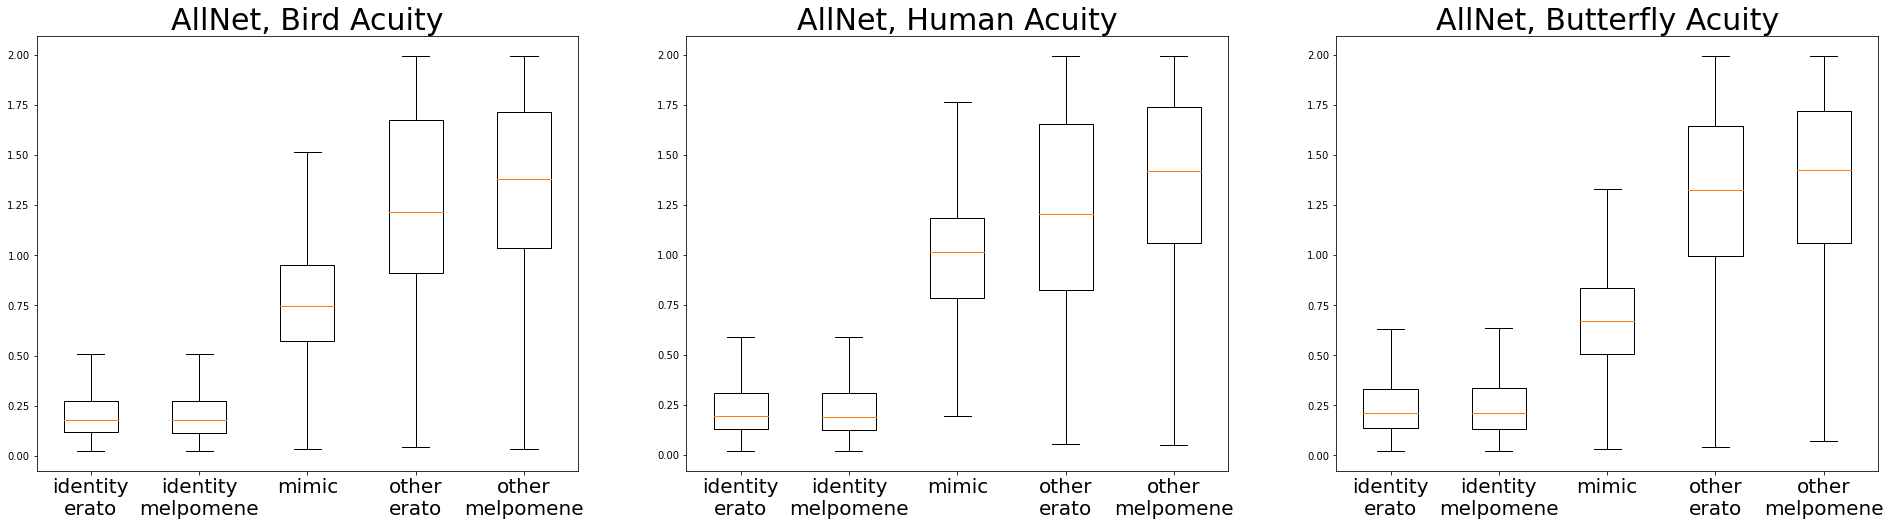

In [ ]:
# with incorrect and correct embeddings
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(bird, bird_data, bird_labels, bird_subspecies, ax=ax0)
ax0.set_title('AllNet, Bird Acuity', fontsize=30)
get_boxplot_separate(human, human_data, human_labels, human_subspecies, ax=ax1)
ax1.set_title('AllNet, Human Acuity', fontsize=30)
get_boxplot_separate(butterfly, butterfly_data, butterfly_labels ,butterfly_subspecies, ax=ax2)
ax2.set_title('AllNet, Butterfly Acuity', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'AllNet, Butterfly Acuity')

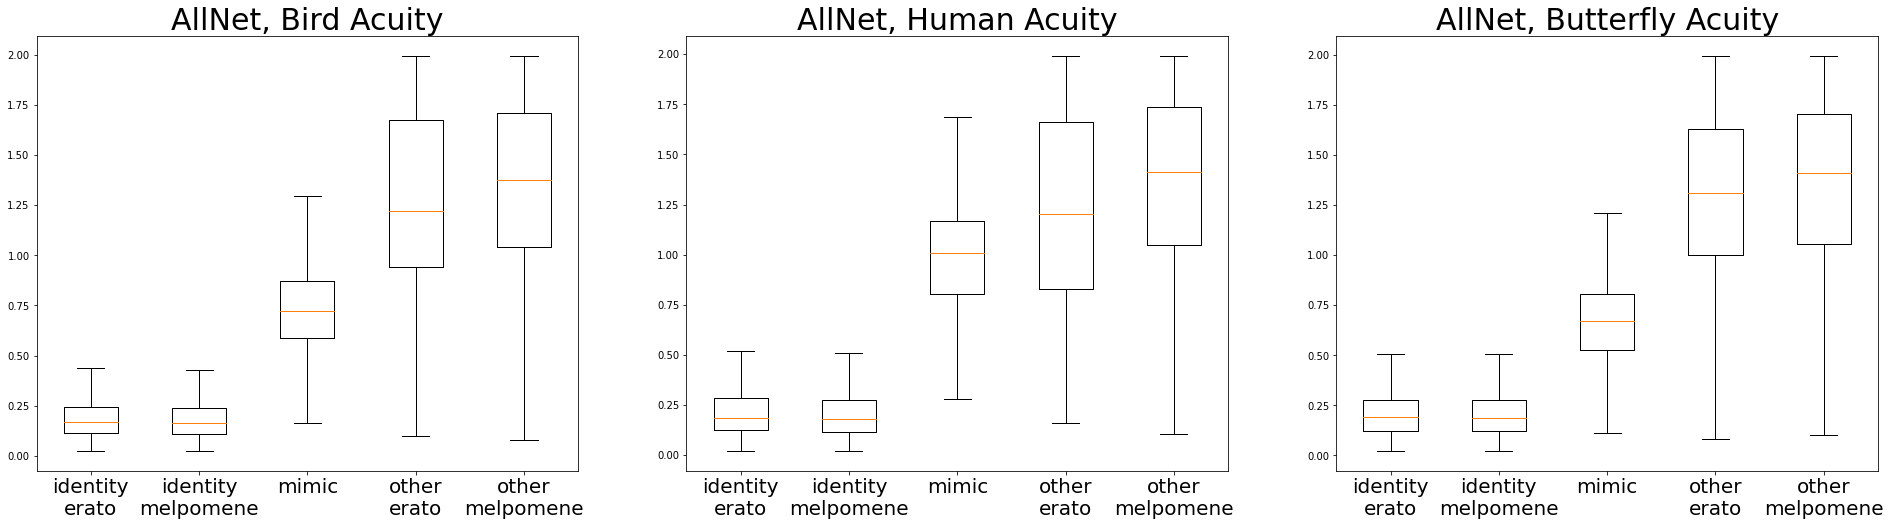

In [ ]:
# with only correct embeddings
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(bird, bird_data, bird_labels, bird_subspecies, ax=ax0)
ax0.set_title('AllNet, Bird Acuity', fontsize=30)
get_boxplot_separate(human, human_data, human_labels, human_subspecies, ax=ax1)
ax1.set_title('AllNet, Human Acuity', fontsize=30)
get_boxplot_separate(butterfly, butterfly_data, butterfly_labels ,butterfly_subspecies, ax=ax2)
ax2.set_title('AllNet, Butterfly Acuity', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'EratoNet, Butterfly Acuity')

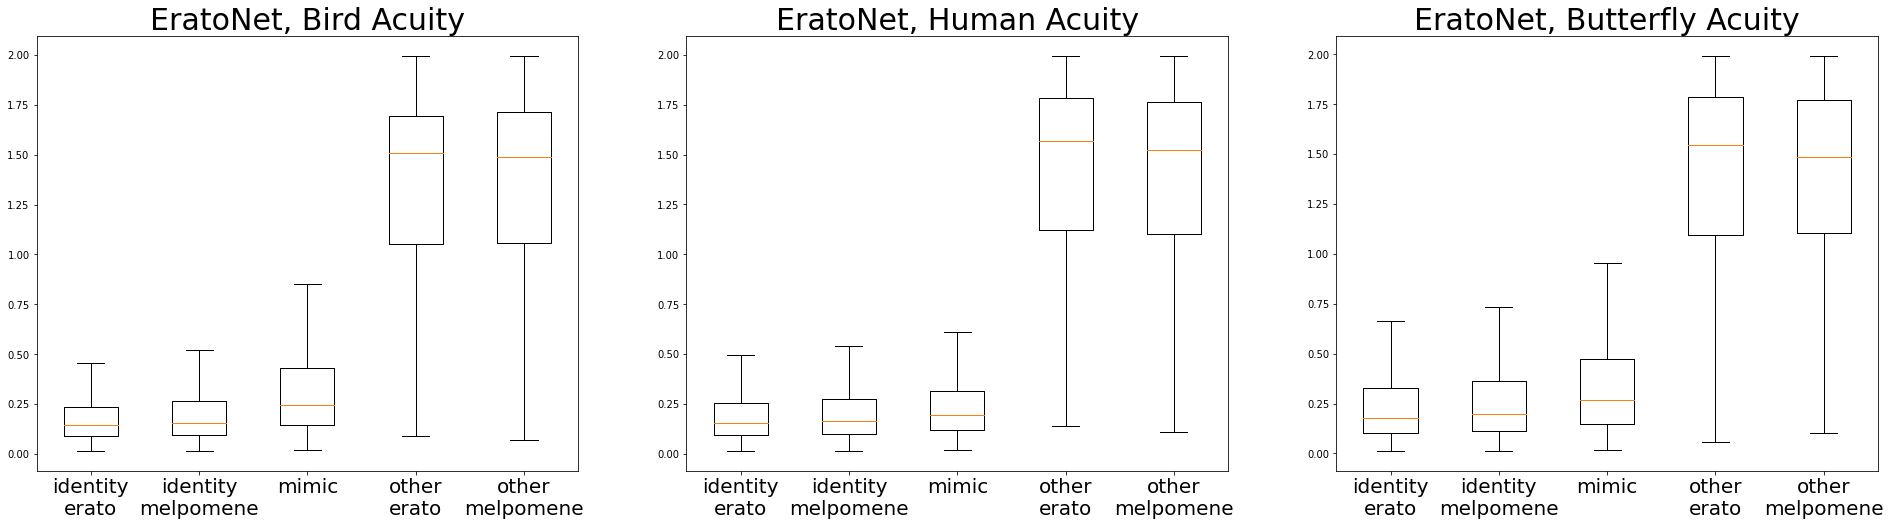

In [ ]:
# with correct and incorrect embeddings
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(bird_erato, bird_data, bird_labels, bird_subspecies, ax=ax0)
ax0.set_title('EratoNet, Bird Acuity', fontsize=30)
get_boxplot_separate(human_erato, human_data, human_labels, human_subspecies, ax=ax1)
ax1.set_title('EratoNet, Human Acuity', fontsize=30)
get_boxplot_separate(butterfly_erato, butterfly_data, butterfly_labels ,butterfly_subspecies, ax=ax2)
ax2.set_title('EratoNet, Butterfly Acuity', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'MelpomeneNet, Butterfly Acuity')

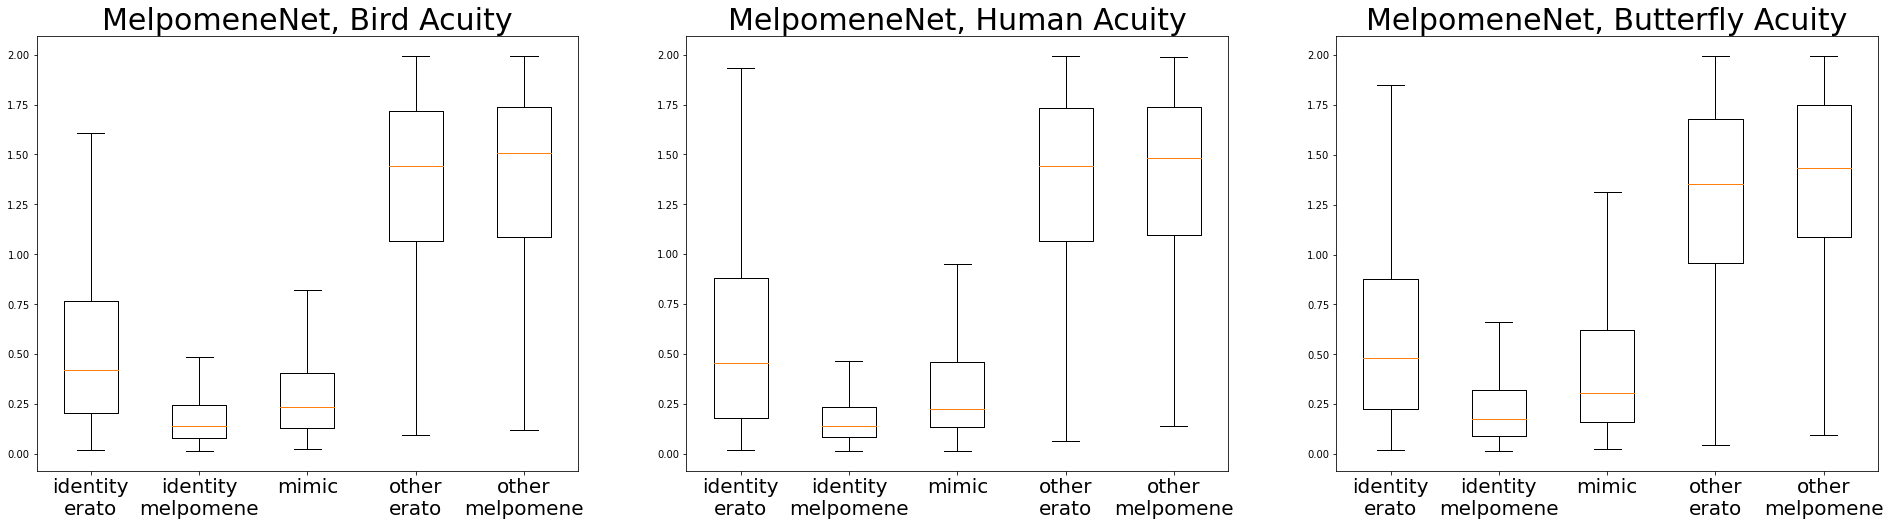

In [ ]:
# with correct and incorrect embeddings
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(bird_melpomene, bird_data, bird_labels, bird_subspecies, ax=ax0)
ax0.set_title('MelpomeneNet, Bird Acuity', fontsize=30)
get_boxplot_separate(human_melpomene, human_data, human_labels, human_subspecies, ax=ax1)
ax1.set_title('MelpomeneNet, Human Acuity', fontsize=30)
get_boxplot_separate(butterfly_melpomene, butterfly_data, butterfly_labels ,butterfly_subspecies, ax=ax2)
ax2.set_title('MelpomeneNet, Butterfly Acuity', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'EratoNet, Butterfly Acuity')

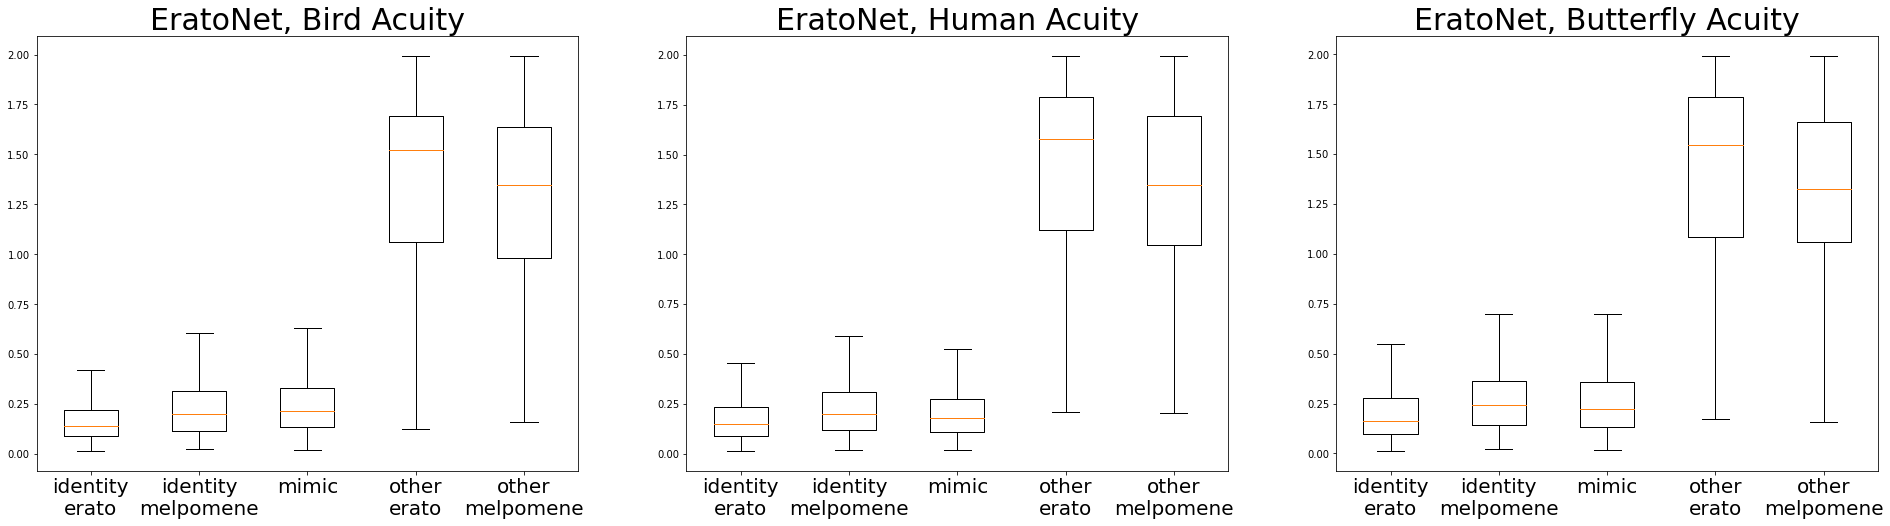

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(bird_erato, bird_data, bird_labels, bird_subspecies, ax=ax0)
ax0.set_title('EratoNet, Bird Acuity', fontsize=30)
get_boxplot_separate(human_erato, human_data, human_labels, human_subspecies, ax=ax1)
ax1.set_title('EratoNet, Human Acuity', fontsize=30)
get_boxplot_separate(butterfly_erato, butterfly_data, butterfly_labels ,butterfly_subspecies, ax=ax2)
ax2.set_title('EratoNet, Butterfly Acuity', fontsize=30)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

Text(0.5, 1.0, 'MelpomeneNet, Butterfly Acuity')

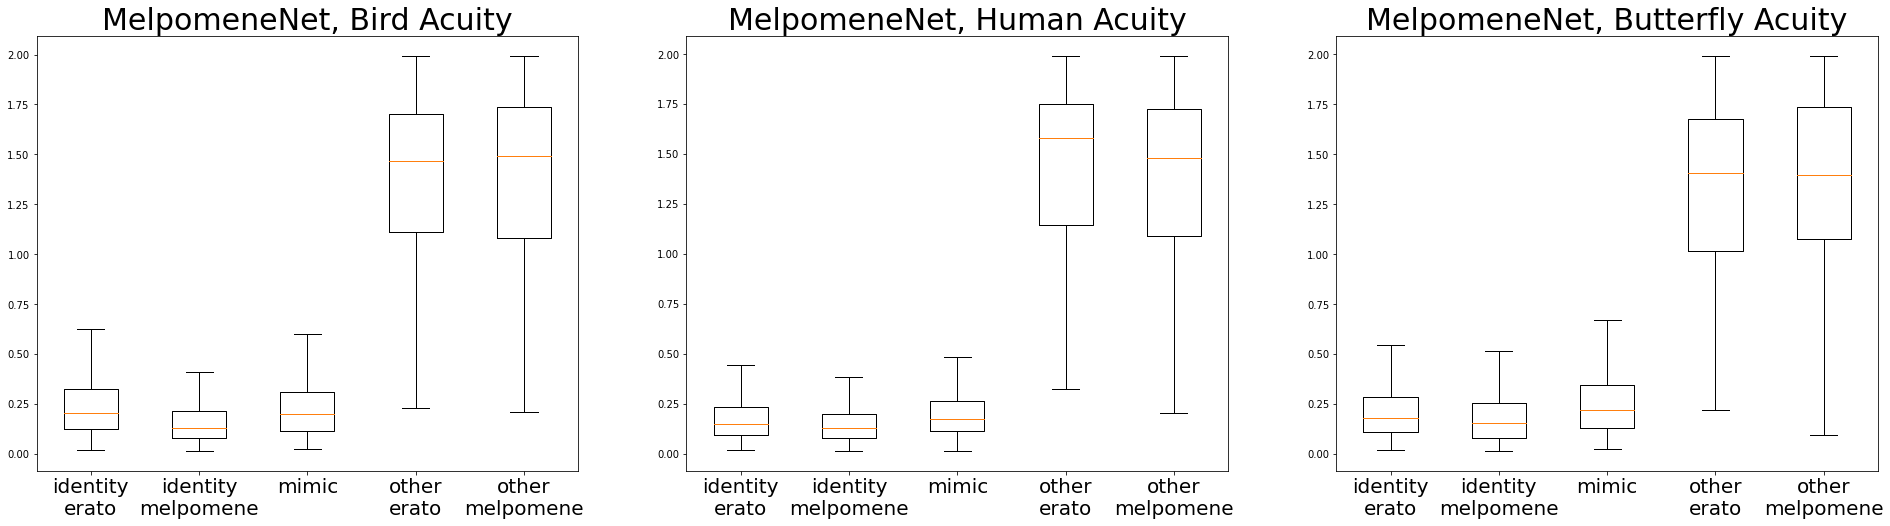

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(33, 8))
get_boxplot_separate(bird_melpomene, bird_data, bird_labels, bird_subspecies, ax=ax0)
ax0.set_title('MelpomeneNet, Bird Acuity', fontsize=30)
get_boxplot_separate(human_melpomene, human_data, human_labels, human_subspecies, ax=ax1)
ax1.set_title('MelpomeneNet, Human Acuity', fontsize=30)
get_boxplot_separate(butterfly_melpomene, butterfly_data, butterfly_labels ,butterfly_subspecies, ax=ax2)
ax2.set_title('MelpomeneNet, Butterfly Acuity', fontsize=30)

#### Fisher's Exact

# New section

In [ ]:
correct_butterfly, incorrect_butterfly = get_accuracy(butterfly_data_e, butterfly_labels_e, butterfly_subspecies_e, butterfly_melpomene, only_comimics_m)
correct_bird, incorrect_bird = get_accuracy(bird_data_e, bird_labels_e, bird_subspecies_e, bird_melpomene, only_comimics_m)

In [ ]:
print(get_accuracy(bird_data_m, bird_labels_m, bird_subspecies_m, bird_melpomene, only_comimics_m))
print(get_accuracy(bird_data_e, bird_labels_e, bird_subspecies_e, bird_melpomene, only_comimics_m))

(202, 16)
(267, 121)


In [ ]:
202/(202+16)

0.926605504587156

In [ ]:
267/(267+121)

0.6881443298969072

In [ ]:
print(get_accuracy(butterfly_data_m, butterfly_labels_m, butterfly_subspecies_m, butterfly_melpomene, only_comimics_m))
print(get_accuracy(butterfly_data_e, butterfly_labels_e, butterfly_subspecies_e, butterfly_melpomene, only_comimics_m))

(197, 21)
(223, 165)


In [ ]:
197/(197+21)

0.9036697247706422

In [ ]:
223/(223+165)

0.5747422680412371

In [ ]:
table = [[correct_butterfly, correct_bird], [incorrect_butterfly, incorrect_bird]]
oddsr, p = fisher_exact(table)
print(p)

0.0013557456168053158


In [ ]:
"""    
          butterfly bird
correct : [223,      267]
incorrect [165,      121]

"""